In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import wave

In [3]:
def readfile(wavfile):
    spf = wave.open(wavfile)
    signal = spf.readframes(-1)
    signal = np.fromstring(signal, 'Int16')
    signal = signal.astype(np.float32) / 2**(16-1)
    return signal


# 音圧の計算

In [4]:
signal = readfile("/Users/smurakami/Desktop/connichiha.wav")

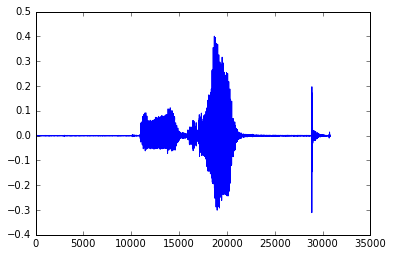

In [5]:
plt.plot(signal)

In [6]:
def getPower(signal, window):
    cumsum = np.cumsum(signal ** 2)
    a = np.arange(len(cumsum) - window)
    b = np.arange(window, len(cumsum))
    power = (cumsum[b] - cumsum[a]) / window
    return power

/usr/local/var/pyenv/versions/anaconda2-4.0.0/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


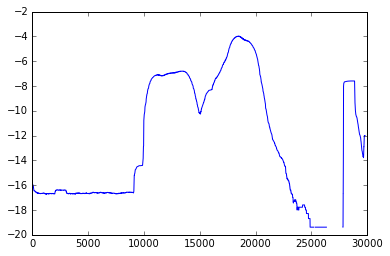

In [7]:
power = getPower(signal, 1000)
plt.plot(np.log(power))

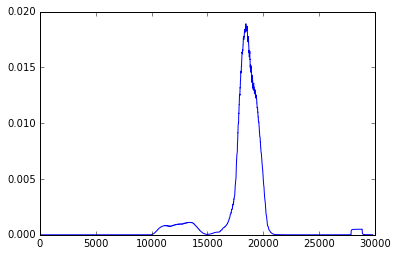

In [8]:
plt.plot(power)

# ピッチの計算

In [9]:
from scipy.fftpack import fft

In [10]:
def pitch0(signal):
    h = fft(signal)
    spec = np.abs(h)
    spec = spec[:len(spec)/2]
    idx = np.arange(len(spec))
    m = sum(spec * idx) / sum(spec)
    return m

In [11]:
low = readfile("/Users/smurakami/Desktop/low.wav")
high = readfile("/Users/smurakami/Desktop/high.wav")

In [12]:
pitch0(low)

3396.6438049785306

In [13]:
pitch0(high)

2658.0685973879945

In [14]:
import scipy.signal as sig

In [71]:
import scipy.fftpack as fft

def pitch1(signal, begin, window):
#     window = 3000
#     begin = 15000
    sample = signal[begin:begin+window]
    cor = sig.correlate(sample, sample, mode='full')
    cor = cor[window:]
    a = np.arange(len(cor))[cor < 0][0]
    term = a + np.argmax(cor[a:]) # 周期
    return 16000 / float(term)

# def auto_corr(sample):
#     return fft.ifft(np.abs(fft.fft(sample)) ** 2)

def auto_corr(sample):
    comb = np.hstack([sample, sample])
    result = []
    for i in xrange(len(sample)):
        val = (sample * comb[i:i+len(sample)]).sum() / len(sample)
        result.append(val)
    return np.array(result)
    

def pitch2(signal, begin, window):
    sample = signal[begin:begin+window]
    cor = auto_corr(sample)
    cor = cor[:len(cor)/2]
    a = np.arange(len(cor))[cor < 0][0]
    term = a + np.argmax(cor[a:]) # 周期
    return 16000 / float(term)

def pitch3(signal):
    window = 1024
    result = []
    for i in range(0, len(sample) - window, window/2):
        result.append(pitch2(sample, i, window))

    result = np.array(result)
    
    result = result[(result < 1000) & (result > 40)].mean()
    
    return np.mean(result)

In [16]:
pitch1(low, 15000, 1000)

111.11111111111111

In [17]:
pitch1(high, 15000, 1000)

275.86206896551727

In [18]:
def test(signal, begin, window):
#     window = 3000
#     begin = 15000
    sample = signal[begin:begin+window]
    cor = sig.correlate(sample, sample, mode='full')
    cor = cor[window:]
    return cor

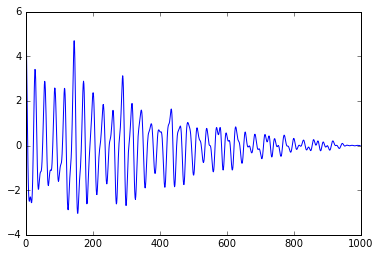

In [19]:
plt.plot(test(low, 15000, 1000))

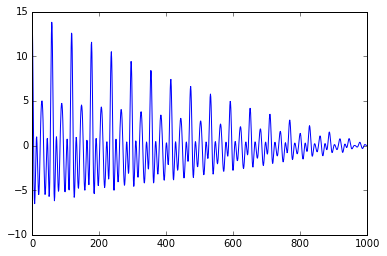

In [20]:
plt.plot(test(high, 15000, 1000))

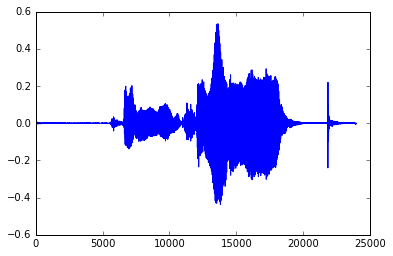

In [21]:
plt.plot(high)

In [22]:
window = 1000
result = np.array([pitch1(low, i, window) for i in xrange(len(low) - window)])

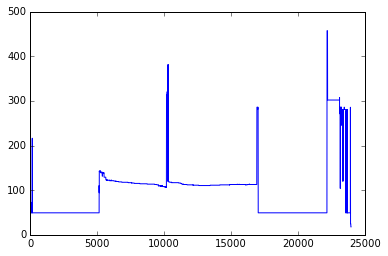

In [23]:
plt.plot(result[ result < 500])

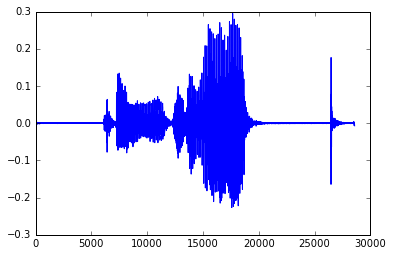

In [24]:
plt.plot(low)

In [25]:
pitch = pitch1

In [26]:
pitch(low, 0, len(low))

111.8881118881119

In [27]:
pitch(high, 0, len(high))

280.70175438596493

In [28]:
w = readfile('/Users/smurakami/Desktop/middle_c.wav')
pitch(w, 0, len(w))

142.85714285714286

In [29]:
w = readfile('/Users/smurakami/Desktop/high_c.wav')
pitch(w, 0, len(w))

197.53086419753086

# 抑揚の計算

In [30]:
low = readfile('/Users/smurakami/Desktop/arigato_low.wav')

In [92]:
def intonation(sample, window):
    p = getPower(sample, window)
    p = p[np.log(p) > -12]
    mean = np.mean(p)
    s = sum((p - mean) ** 2) / len(p)
    return s

In [32]:
intonation(readfile('/Users/smurakami/Desktop/arigato_low.wav'), 1000)

3.796469801975618e-07

In [33]:
intonation(readfile('/Users/smurakami/Desktop/arigato_high.wav'), 1000)

0.00016607725004731192

In [34]:
filepaths = [            "/Users/smurakami/Desktop/taka_kora.wav",
            "/Users/smurakami/Desktop/taka_kanashii.wav",
            "/Users/smurakami/Desktop/taka_ureshii.wav",
            "/Users/smurakami/Desktop/taka_coemoji.wav",
            "/Users/smurakami/Desktop/mura_ureshii.wav",
            "/Users/smurakami/Desktop/mura_kora.wav",
            "/Users/smurakami/Desktop/mura_kanashii.wav",
            "/Users/smurakami/Desktop/mura_coemoji.wav",]


In [83]:
for filepath in filepaths:
    sample = readfile(filepath)
    print filepath
    print pitch3(sample)

/Users/smurakami/Desktop/taka_kora.wav
213.542751734
/Users/smurakami/Desktop/taka_kanashii.wav
151.219973159
/Users/smurakami/Desktop/taka_ureshii.wav
203.796195751
/Users/smurakami/Desktop/taka_coemoji.wav
176.661852439
/Users/smurakami/Desktop/mura_ureshii.wav
118.665506151
/Users/smurakami/Desktop/mura_kora.wav
145.221998899
/Users/smurakami/Desktop/mura_kanashii.wav
125.855445936
/Users/smurakami/Desktop/mura_coemoji.wav
136.205369097


In [36]:
filepath = filepaths[3]

In [37]:
sample = readfile(filepath)

In [38]:
window = 1024
result = []
for i in range(0, len(sample) - window, window/2):
    result.append(pitch1(sample, i, window))

result = np.array(result)


In [39]:
result[(result < 1000) & (result > 40)].mean()

188.9835687726536

In [40]:
len(sample)

36762

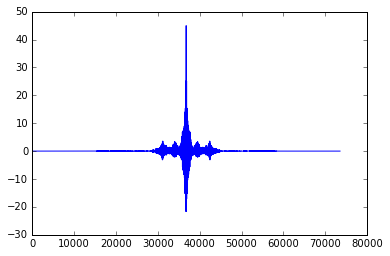

In [76]:
plt.plot(sig.correlate(sample, sample, mode='full'))

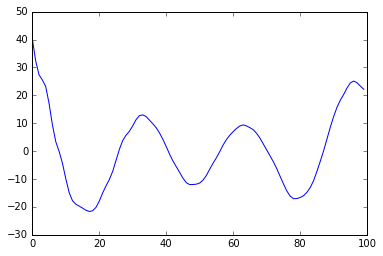

In [80]:
plt.plot(sig.correlate(sample, sample, mode='full')[len(sample):][:100])

In [72]:
cor = auto_corr(sample)

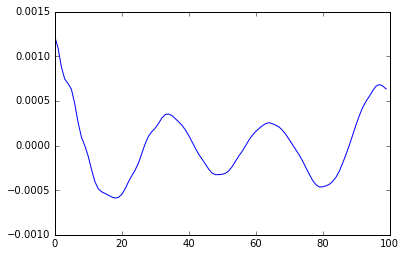

In [73]:
plt.plot(np.real(cor)[:100])

In [81]:
swift_corr = [ 0.001223, 0.001093, 0.000880, 0.000744, 0.000693, 0.000629, 0.000466, 0.000256, 0.000092, -0.000003, -0.000119, -0.000269, -0.000404, -0.000484, -0.000518, -0.000536, -0.000556, -0.000576, -0.000589, -0.000582, -0.000549, -0.000487, -0.000409, -0.000340, -0.000278, -0.000198, -0.000091, 0.000017, 0.000103, 0.000155, 0.000193, 0.000247, 0.000307, 0.000346, 0.000353, 0.000337, 0.000301, 0.000266, 0.000228, 0.000176, 0.000114, 0.000043, -0.000030, -0.000097, -0.000152, -0.000207, -0.000265, -0.000308, -0.000326, -0.000326, -0.000322, -0.000311, -0.000283, -0.000237, -0.000176, -0.000117, -0.000064, -0.000004, 0.000060, 0.000113, 0.000156, 0.000190, 0.000221, 0.000245, 0.000256, 0.000245, 0.000228, 0.000208, 0.000172, 0.000126, 0.000069, 0.000012, -0.000046, -0.000104, -0.000170, -0.000245, -0.000319, -0.000388, -0.000438, -0.000464, -0.000463, -0.000452, -0.000435, -0.000403, -0.000356, -0.000289, -0.000198, -0.000100, 0.000003, 0.000117, 0.000232, 0.000336, 0.000427, 0.000497, 0.000552, 0.000616, 0.000665, 0.000683, 0.000666, 0.000633, 0.000603, 0.000570, 0.000517, 0.000435, 0.000344, 0.000254, 0.000173, 0.000093, 0.000008, -0.000076, -0.000162, -0.000247, -0.000323, -0.000380, -0.000418, -0.000446, -0.000462, -0.000465, -0.000445, -0.000407, -0.000371, -0.000334, -0.000292, -0.000233, -0.000165, -0.000104, -0.000054, -0.000011, 0.000038, 0.000081, 0.000115, 0.000141, 0.000168, 0.000193, 0.000201, 0.000199, 0.000191, 0.000180, 0.000160, 0.000128, 0.000095, 0.000076, 0.000060, 0.000029, -0.000018, -0.000065, -0.000097, -0.000114, -0.000137, -0.000171, -0.000196, -0.000206, -0.000202, -0.000199, -0.000203, -0.000200, -0.000180, -0.000147, -0.000108, -0.000065, -0.000032, -0.000003, 0.000028, 0.000057, 0.000084, 0.000101, 0.000101, 0.000095, 0.000100, 0.000104, 0.000089, 0.000052, 0.000009, -0.000016, -0.000026, -0.000038, -0.000054, -0.000062, -0.000057, -0.000047, -0.000049, -0.000060, -0.000069, -0.000070, -0.000066, -0.000056, -0.000048, -0.000043, -0.000046, -0.000049, -0.000024, 0.000022, 0.000071, 0.000108, 0.000144, 0.000197, 0.000266, 0.000328, 0.000357, 0.000373, 0.000391, 0.000412, 0.000417, 0.000394, 0.000350, 0.000301, 0.000256, 0.000205, 0.000142, 0.000065, -0.000013, -0.000083, -0.000142, -0.000195, -0.000246, -0.000293, -0.000338, -0.000375, -0.000398, -0.000408, -0.000404, -0.000392, -0.000369, -0.000330, -0.000283, -0.000232, -0.000191, -0.000150, -0.000089, -0.000016, 0.000054, 0.000111, 0.000153, 0.000191, 0.000231, 0.000261, 0.000273, 0.000275, 0.000273, 0.000266, 0.000251, 0.000218, 0.000171, 0.000116, 0.000060, -0.000000, -0.000068, -0.000137, -0.000196, -0.000238, -0.000268, -0.000289, -0.000304, -0.000314, -0.000312, -0.000297, -0.000274, -0.000245, -0.000210, -0.000168, -0.000113, -0.000055, -0.000008, 0.000029, 0.000065, 0.000114, 0.000177, 0.000230, 0.000259, 0.000270, 0.000282, 0.000291, 0.000291, 0.000269, 0.000229, 0.000192, 0.000156, 0.000116, 0.000062, 0.000001, -0.000057, -0.000107, -0.000147, -0.000180, -0.000208, -0.000232, -0.000242, -0.000227, -0.000199, -0.000171, -0.000151, -0.000126, -0.000079, -0.000012, 0.000060, 0.000118, 0.000168, 0.000222, 0.000277, 0.000324, 0.000357, 0.000377, 0.000381, 0.000377, 0.000368, 0.000341, 0.000297, 0.000236, 0.000160, 0.000085, 0.000016, -0.000051, -0.000124, -0.000198, -0.000263, -0.000310, -0.000341, -0.000370, -0.000398, -0.000413, -0.000403, -0.000371, -0.000333, -0.000296, -0.000254, -0.000197, -0.000129, -0.000060, -0.000002, 0.000053, 0.000108, 0.000159, 0.000202, 0.000235, 0.000255, 0.000262, 0.000259, 0.000242, 0.000223, 0.000203, 0.000174, 0.000132, 0.000087, 0.000040, -0.000005, -0.000048, -0.000096, -0.000141, -0.000177, -0.000205, -0.000230, -0.000254, -0.000273, -0.000283, -0.000279, -0.000260, -0.000230, -0.000196, -0.000157, -0.000114, -0.000063, 0.000001, 0.000068, 0.000123, 0.000168, 0.000208, 0.000245, 0.000276, 0.000294, 0.000295, 0.000288, 0.000275, 0.000252, 0.000220, 0.000181, 0.000140, 0.000098, 0.000058, 0.000015, -0.000027, -0.000067, -0.000105, -0.000138, -0.000163, -0.000180, -0.000193, -0.000201, -0.000201, -0.000193, -0.000177, -0.000154, -0.000124, -0.000093, -0.000053, -0.000009, 0.000033, 0.000078, 0.000122, 0.000158, 0.000189, 0.000217, 0.000236, 0.000247, 0.000251, 0.000242, 0.000222, 0.000195, 0.000164, 0.000128, 0.000086, 0.000038, -0.000015, -0.000065, -0.000108, -0.000147, -0.000189, -0.000223, -0.000248, -0.000259, -0.000255, -0.000248, -0.000240, -0.000222, -0.000196, -0.000171, -0.000141, -0.000107, -0.000072, -0.000031, 0.000010, 0.000043, 0.000073, 0.000104, 0.000128, 0.000150, 0.000172, 0.000187, 0.000195, 0.000196, 0.000184, 0.000162, 0.000137, 0.000109, 0.000076, 0.000038, -0.000002, -0.000041, -0.000078, -0.000111, -0.000144, -0.000175, -0.000195, -0.000199, -0.000196, -0.000190, -0.000185, -0.000175, -0.000153, -0.000121, -0.000088, -0.000056, -0.000023, 0.000017, 0.000063, 0.000107, 0.000143, 0.000173, 0.000198, 0.000220, 0.000236, 0.000242, 0.000239, 0.000227, 0.000211, 0.000194, 0.000172, 0.000141, 0.000100, 0.000055, 0.000014, -0.000016, -0.000047, -0.000085, -0.000123, -0.000154, -0.000173, -0.000180, -0.000191, -0.000207, -0.000217, -0.000211, -0.000192, -0.000169, -0.000147, -0.000122, -0.000087, -0.000046, -0.000005, 0.000030, 0.000064, 0.000100, 0.000136, 0.000166, 0.000187, 0.000198, 0.000202, 0.000199, 0.000185, 0.000167, 0.000146, 0.000120, 0.000085, 0.000048, 0.000008, -0.000033, -0.000070, -0.000110, -0.000146, -0.000172, -0.000187, -0.000199, -0.000207, -0.000210, -0.000203, -0.000181, -0.000152, -0.000123, -0.000087, -0.000046, -0.000001, 0.000040, 0.000073, 0.000104, 0.000133, 0.000157, 0.000170, 0.000175, 0.000177, 0.000179, 0.000176, 0.000158, 0.000129, 0.000096, 0.000066, 0.000039, 0.000009, -0.000023, -0.000051, -0.000074, -0.000098, -0.000129, -0.000159, -0.000175, -0.000176, -0.000170, -0.000166, -0.000157, -0.000140, -0.000118, -0.000095, -0.000068, -0.000030, 0.000012, 0.000050, 0.000082, 0.000115, 0.000154, 0.000189, 0.000206, 0.000210, 0.000216, 0.000222, 0.000219, 0.000201, 0.000174, 0.000147, 0.000122, 0.000088, 0.000047, 0.000004, -0.000037, -0.000069, -0.000099, -0.000131, -0.000162, -0.000192, -0.000214, -0.000225, -0.000227, -0.000227, -0.000227, -0.000221, -0.000202, -0.000173, -0.000140, -0.000107, -0.000071, -0.000032, 0.000009, 0.000047, 0.000082, 0.000115, 0.000143, 0.000164, 0.000176, 0.000183, 0.000187, 0.000183, 0.000171, 0.000151, 0.000126, 0.000099, 0.000066, 0.000031, -0.000002, -0.000030, -0.000054, -0.000080, -0.000104, -0.000121, -0.000125, -0.000122, -0.000114, -0.000106, -0.000094, -0.000078, -0.000063, -0.000043, -0.000017, 0.000012, 0.000037, 0.000054, 0.000068, 0.000086, 0.000105, 0.000114, 0.000117, 0.000122, 0.000128, 0.000125, 0.000106, 0.000082, 0.000064, 0.000051, 0.000030, -0.000000, -0.000031, -0.000051, -0.000061, -0.000074, -0.000093, -0.000114, -0.000126, -0.000127, -0.000121, -0.000118, -0.000114, -0.000105, -0.000088, -0.000065, -0.000043, -0.000024, -0.000001, 0.000029, 0.000063, 0.000093, 0.000116, 0.000130, 0.000141, 0.000148, 0.000152, 0.000150, 0.000142, 0.000129, 0.000113, 0.000096, 0.000075, 0.000050, 0.000020, -0.000012, -0.000041, -0.000066, -0.000089, -0.000113, -0.000138, -0.000163, -0.000181, -0.000190, -0.000193, -0.000190, -0.000184, -0.000174, -0.000161, -0.000144, -0.000123, -0.000099, -0.000073, -0.000047, -0.000018, 0.000011, 0.000036, 0.000056, 0.000077, 0.000099, 0.000120, 0.000136, 0.000143, 0.000148, 0.000154, 0.000157, 0.000149, 0.000133, 0.000114, 0.000097, 0.000081, 0.000058, 0.000037, 0.000020, 0.000007, -0.000008, -0.000029, -0.000049, -0.000059, -0.000059, -0.000060, -0.000062, -0.000057, -0.000048, -0.000035, -0.000025, -0.000016, -0.000001, 0.000018, 0.000035, 0.000046, 0.000056, 0.000065, 0.000072, 0.000073, 0.000071, 0.000069, 0.000065, 0.000056, 0.000042, 0.000027, 0.000013, -0.000001, -0.000019, -0.000035, -0.000045, -0.000056, -0.000071, -0.000090, -0.000104, -0.000107, -0.000104, -0.000100, -0.000095, -0.000085, -0.000070, -0.000055, -0.000040, -0.000019, 0.000005, 0.000026, 0.000040, 0.000053, 0.000069, 0.000087, 0.000099, 0.000103, 0.000102, 0.000100, 0.000096, 0.000089, 0.000078, 0.000066, 0.000050, 0.000031, 0.000008, -0.000015, -0.000039, -0.000065, -0.000089, -0.000109, -0.000127, -0.000143, -0.000160, -0.000174, -0.000179, -0.000174, -0.000167, -0.000161, -0.000151, -0.000137, -0.000118, -0.000094, -0.000068, -0.000037, -0.000003, 0.000029, 0.000057, 0.000084, 0.000112, 0.000135, 0.000153, 0.000169, 0.000186, 0.000196, 0.000193, 0.000181, 0.000167, 0.000160, 0.000149, 0.000125, 0.000095, 0.000070, 0.000051, 0.000032, 0.000007, -0.000019, -0.000037, -0.000047, -0.000058, -0.000072, -0.000079, -0.000076, -0.000066, -0.000058, -0.000054, -0.000048, -0.000033, -0.000013, 0.000006, 0.000020, 0.000030, 0.000040, 0.000048, 0.000053, 0.000055, 0.000055, 0.000053, 0.000045, 0.000030, 0.000012, -0.000003, -0.000013, -0.000025, -0.000040, -0.000056, -0.000066, -0.000069, -0.000073, -0.000081, -0.000089, -0.000089, -0.000085, -0.000079, -0.000075, -0.000068, -0.000055, -0.000037, -0.000019, -0.000004, 0.000010, 0.000025, 0.000041, 0.000060, 0.000079, 0.000091, 0.000095, 0.000093, 0.000089, 0.000084, 0.000075, 0.000061, 0.000044, 0.000025, 0.000004, -0.000018, -0.000042, -0.000066, -0.000088, -0.000107, -0.000124, -0.000138, -0.000147, -0.000153, -0.000154, -0.000150, -0.000141, -0.000129, -0.000117, -0.000104, -0.000086, -0.000060, -0.000031, -0.000004, 0.000016, 0.000038, 0.000065, 0.000095, 0.000119, 0.000137, 0.000154, 0.000170, 0.000182, 0.000185, 0.000183, 0.000180, 0.000175, 0.000163, 0.000140, 0.000114, 0.000091, 0.000072, 0.000051, 0.000027, 0.000004, -0.000014, -0.000029, -0.000043, -0.000054, -0.000060, -0.000061, -0.000064, -0.000067, -0.000065, -0.000056, -0.000045, -0.000038, -0.000032, -0.000024, -0.000016, -0.000010, -0.000007, -0.000001, 0.000006, 0.000013, 0.000012, 0.000007, 0.000005, 0.000005, 0.000006, 0.000004, -0.000001, -0.000008, -0.000017, -0.000026, -0.000036, -0.000043, -0.000047, -0.000052, -0.000059, -0.000066, -0.000069, -0.000064, -0.000056, -0.000048, -0.000037, -0.000021, -0.000006, 0.000006, 0.000014, 0.000023, 0.000035, 0.000045, 0.000048, 0.000044, 0.000042, 0.000042, 0.000042, 0.000035, 0.000022, 0.000009, -0.000001, -0.000011, -0.000022, -0.000033, -0.000043, -0.000053, -0.000062, -0.000072, -0.000078, -0.000081, -0.000082, -0.000082, -0.000081, -0.000080, -0.000077, -0.000072, -0.000063, -0.000049, -0.000033, -0.000018, -0.000004, 0.000012, 0.000031, 0.000053, 0.000075, 0.000094, 0.000107, 0.000115, 0.000124, 0.000134, 0.000141, 0.000142, 0.000137, 0.000126, 0.000118, 0.000113, 0.000106, 0.000095, 0.000079, 0.000065, 0.000053, 0.000040, 0.000023, 0.000006, -0.000004, -0.000012, -0.000023, -0.000041, -0.000058, -0.000068, -0.000072, -0.000076, -0.000081, -0.000082, -0.000079, -0.000075, -0.000070, -0.000062, -0.000049, -0.000033, -0.000022, -0.000015, -0.000009, 0.000001, 0.000009, 0.000012, 0.000011, 0.000010, 0.000013, 0.000014, 0.000010, 0.000002, -0.000002, -0.000000, -0.000001, -0.000008, -0.000018, -0.000022, -0.000018, -0.000016, -0.000023, -0.000032, -0.000036, -0.000033, -0.000030, -0.000031, -0.000034, -0.000032, -0.000028, -0.000025, -0.000022, -0.000018, -0.000011, -0.000004, -0.000001, -0.000001, 0.000001, 0.000005, 0.000008, 0.000009, 0.000008, 0.000006, 0.000003, -0.000000, -0.000006, -0.000012, -0.000016, -0.000018, -0.000022, -0.000028, -0.000033, -0.000032, -0.000024, -0.000016, -0.000014, -0.000014, -0.000013, -0.000005, 0.000006, 0.000015, 0.000022, 0.000026, 0.000029, 0.000032, 0.000037, 0.000047, 0.000061, 0.000075, 0.000084, 0.000089, 0.000094, 0.000101, 0.000109, 0.000112, 0.000109, 0.000102, 0.000093, 0.000082, 0.000067, 0.000047, 0.000028, 0.000012, -0.000003, -0.000022, -0.000041, -0.000056, -0.000066, -0.000073, -0.000080, -0.000084, -0.000085, -0.000085, -0.000085, -0.000082, -0.000071, -0.000058, -0.000050, -0.000046, -0.000040, -0.000028, -0.000012, -0.000001, 0.000004, 0.000009, 0.000019, 0.000030, 0.000038, 0.000041, 0.000040, 0.000039, 0.000038, 0.000035, 0.000029, 0.000021, 0.000008, -0.000005, -0.000018, -0.000028, -0.000038, -0.000051, -0.000063, -0.000069, -0.000067, -0.000064, -0.000067, -0.000071, -0.000067, -0.000054, -0.000039, -0.000031, -0.000027, -0.000019, -0.000004, 0.000012, 0.000021, 0.000023, 0.000026, 0.000030, 0.000034, 0.000035, 0.000035, 0.000038, 0.000040, 0.000038, 0.000032, 0.000026, 0.000024, 0.000024, 0.000022, 0.000016, 0.000010, 0.000005, -0.000001, -0.000010, -0.000016, -0.000019, -0.000018, -0.000020, -0.000024, -0.000024, -0.000015, -0.000002, 0.000012, 0.000023, 0.000032, 0.000042, 0.000053, 0.000062, 0.000071, 0.000079, 0.000081, 0.000076, 0.000067, 0.000059, 0.000054, 0.000048, 0.000040, 0.000031, 0.000022, 0.000013, 0.000003, -0.000008, -0.000020, -0.000030, -0.000039, -0.000045, -0.000050, -0.000055, -0.000061, -0.000067, -0.000066, -0.000061, -0.000056, -0.000052, -0.000048, -0.000040, -0.000028, -0.000015, -0.000007, -0.000001, 0.000006, 0.000015, 0.000023, 0.000029, 0.000032, 0.000031, 0.000027, 0.000022, 0.000017, 0.000014, 0.000011, 0.000002, -0.000011, -0.000023, -0.000029, -0.000033, -0.000039, -0.000051, -0.000061, -0.000063, -0.000057, -0.000053, -0.000053, -0.000053, -0.000049, -0.000038, -0.000026, -0.000018, -0.000012, -0.000005, 0.000007, 0.000021, 0.000033, 0.000038, 0.000039, 0.000044, 0.000053, 0.000063, 0.000066, 0.000062, 0.000057, 0.000056, 0.000055, 0.000050, 0.000040, 0.000029, 0.000017, 0.000007, -0.000003, -0.000012, -0.000019, -0.000024, -0.000027, -0.000028, -0.000030, -0.000030, -0.000028, -0.000024, -0.000020, -0.000015, -0.000009, -0.000002, 0.000000, 0.000000, 0.000004, 0.000013, 0.000022, 0.000026, 0.000028, 0.000034, 0.000042, 0.000046, 0.000044, 0.000043, 0.000045, 0.000045, 0.000040, 0.000030, 0.000021, 0.000015, 0.000008, -0.000001, -0.000010, -0.000016, -0.000019, -0.000021, -0.000026, -0.000032, -0.000035, -0.000036, -0.000034, -0.000032, -0.000032, -0.000032, -0.000031, -0.000028, -0.000024, -0.000020, -0.000018, -0.000016, -0.000013, -0.000009, -0.000005, -0.000003, -0.000005, -0.000010, -0.000012, -0.000011, -0.000010, -0.000011, -0.000014, -0.000015, -0.000014, -0.000013, -0.000016, -0.000020, -0.000023, -0.000022, -0.000020, -0.000016, -0.000013, -0.000011, -0.000008, -0.000004, 0.000003, 0.000010, 0.000014, 0.000019, 0.000025, 0.000033, 0.000038, 0.000040, 0.000039, 0.000040, 0.000043, 0.000043, 0.000039, 0.000034, 0.000030, 0.000026, 0.000024, 0.000019, 0.000014, 0.000007, 0.000002, -0.000002, -0.000006, -0.000010, -0.000014, -0.000017, -0.000021, -0.000026, -0.000030, -0.000032, -0.000033, -0.000034, -0.000035, -0.000032, -0.000027, -0.000022, -0.000019, -0.000014, -0.000006, 0.000002, 0.000010, 0.000016, 0.000023, 0.000028, 0.000031, 0.000032, 0.000034, 0.000036, 0.000038, 0.000038, 0.000039, 0.000039, 0.000037, 0.000033, 0.000028, 0.000025, 0.000021, 0.000016, 0.000010, 0.000002, -0.000005, -0.000013, -0.000018, -0.000024, -0.000029, -0.000034, -0.000037, -0.000039, -0.000041, -0.000042, -0.000041, -0.000039, -0.000040, -0.000044, -0.000043, -0.000038, -0.000030, -0.000027, -0.000026, -0.000024, -0.000017, -0.000011, -0.000007, -0.000004, 0.000001, 0.000008, 0.000015, 0.000019, 0.000021, 0.000021, 0.000022, 0.000023, 0.000025, 0.000027, 0.000029, 0.000029, 0.000029, 0.000029, 0.000030, 0.000031, 0.000028, 0.000022, 0.000016, 0.000012, 0.000010, 0.000007, 0.000002, -0.000001, -0.000002, -0.000003, -0.000006, -0.000007, -0.000006, -0.000005, -0.000005, -0.000005, -0.000004, -0.000003, -0.000006, -0.000009, -0.000011, -0.000011, -0.000013, -0.000017, -0.000022, -0.000023, -0.000021, -0.000020, -0.000021, -0.000020, -0.000018, -0.000015, -0.000011, -0.000009, -0.000008, -0.000007, -0.000005, -0.000001, 0.000004, 0.000010, 0.000013, 0.000016, 0.000019, 0.000024, 0.000028, 0.000031, 0.000030, 0.000030, 0.000033, 0.000035, 0.000034, 0.000030, 0.000027, 0.000024, 0.000021, 0.000015, 0.000008, 0.000005, 0.000003, -0.000002, -0.000010, -0.000018, -0.000023, -0.000027, -0.000033, -0.000041, -0.000045, -0.000044, -0.000044, -0.000044, -0.000045, -0.000044, -0.000038, -0.000031, -0.000026, -0.000022, -0.000017, -0.000011, -0.000005, 0.000002, 0.000008, 0.000014, 0.000020, 0.000028, 0.000034, 0.000039, 0.000043, 0.000045, 0.000047, 0.000049, 0.000050, 0.000048, 0.000042, 0.000035, 0.000030, 0.000026, 0.000021, 0.000014, 0.000005, -0.000000, -0.000004, -0.000009, -0.000014, -0.000020, -0.000023, -0.000025, -0.000028, -0.000030, -0.000030, -0.000029, -0.000029, -0.000031, -0.000030, -0.000026, -0.000021, -0.000018, -0.000017, -0.000015, -0.000009, -0.000003, -0.000003, -0.000005, -0.000007, -0.000004, -0.000001, -0.000001, -0.000005, -0.000007, -0.000004, 0.000001, 0.000004, 0.000003, 0.000002, 0.000005, 0.000009, 0.000012, 0.000011, 0.000010, 0.000010, 0.000012, 0.000014, 0.000015, 0.000015, 0.000013, 0.000010, 0.000009, 0.000011, 0.000013, 0.000013, 0.000010, 0.000008, 0.000009, 0.000010, 0.000008, 0.000003, -0.000002, -0.000005, -0.000006, -0.000008, -0.000010, -0.000014, -0.000017, -0.000018, -0.000017, -0.000015, -0.000014, -0.000013, -0.000013, -0.000011, -0.000010, -0.000009, -0.000008, -0.000007, -0.000004, -0.000000, 0.000004, 0.000008, 0.000012, 0.000015, 0.000018, 0.000021, 0.000023, 0.000026, 0.000030, 0.000033, 0.000032, 0.000029, 0.000027, 0.000026, 0.000027, 0.000025, 0.000022, 0.000018, 0.000014, 0.000010, 0.000005, 0.000000, -0.000005, -0.000011, -0.000017, -0.000022, -0.000025, -0.000030, -0.000035, -0.000039, -0.000040, -0.000037, -0.000036, -0.000036, -0.000035, -0.000032, -0.000026, -0.000024, -0.000025, -0.000026, -0.000022, -0.000014, -0.000007, -0.000005, -0.000004, -0.000002, 0.000003, 0.000008, 0.000011, 0.000014, 0.000015, 0.000016, 0.000017, 0.000019, 0.000019, 0.000018, 0.000016, 0.000014, 0.000014, 0.000011, 0.000007, 0.000003, 0.000002, 0.000003, 0.000002, -0.000001, -0.000004, -0.000003, -0.000002, -0.000004, -0.000008, -0.000012, -0.000012, -0.000009, -0.000006, -0.000005, -0.000003, 0.000001, 0.000005, 0.000008, 0.000010, 0.000014, 0.000019, 0.000022, 0.000022, 0.000020, 0.000018, 0.000018, 0.000017, 0.000014, 0.000011, 0.000010, 0.000011, 0.000010, 0.000006, 0.000002, -0.000000, 0.000000, 0.000002, 0.000001, -0.000001, -0.000003, -0.000002, -0.000000, 0.000001, 0.000001, 0.000001, 0.000004, 0.000008, 0.000011, 0.000011, 0.000011, 0.000012, 0.000013, 0.000011, 0.000007, 0.000004, 0.000003, 0.000002, -0.000002, -0.000010, -0.000016, -0.000018, -0.000017, -0.000018, -0.000022, -0.000026, -0.000028, -0.000028, -0.000029, -0.000032, -0.000033, -0.000033, -0.000032, -0.000032, -0.000032, -0.000030, -0.000025, -0.000020, -0.000015, -0.000011, -0.000006, -0.000003, 0.000001, 0.000005, 0.000010, 0.000013, 0.000014, 0.000012, 0.000013, 0.000017, 0.000020, 0.000019, 0.000015, 0.000013, 0.000014, 0.000014, 0.000010, 0.000006, 0.000003, 0.000001, -0.000002, -0.000006, -0.000008, -0.000008, -0.000007, -0.000006, -0.000006, -0.000004, 0.000001, 0.000005, 0.000007, 0.000009, 0.000012, 0.000016, 0.000021, 0.000023, 0.000024, 0.000026, 0.000027, 0.000026, 0.000024, 0.000023, 0.000022, 0.000022, 0.000020, 0.000018, 0.000015, 0.000012, 0.000008, 0.000005, 0.000004, 0.000003, 0.000001, -0.000003, -0.000006, -0.000006, -0.000006, -0.000007, -0.000007, -0.000005, -0.000002, -0.000001, -0.000003, -0.000005, -0.000005, -0.000003, -0.000003, -0.000005, -0.000006, -0.000005, -0.000005, -0.000008, -0.000011, -0.000012, -0.000010, -0.000008, -0.000008, -0.000010, -0.000011, -0.000009, -0.000008, -0.000010, -0.000014, -0.000016, -0.000016, -0.000015, -0.000017, -0.000020, -0.000022, -0.000022, -0.000021, -0.000020, -0.000020, -0.000020, -0.000021, -0.000021, -0.000020, -0.000019, -0.000018, -0.000015, -0.000012, -0.000007, -0.000004, 0.000000, 0.000004, 0.000006, 0.000007, 0.000008, 0.000008, 0.000008, 0.000008, 0.000008, 0.000008, 0.000010, 0.000010, 0.000010, 0.000011, 0.000015, 0.000021, 0.000026, 0.000027, 0.000028, 0.000028, 0.000028, 0.000026, 0.000025, 0.000024, 0.000022, 0.000018, 0.000016, 0.000014, 0.000014, 0.000012, 0.000009, 0.000007, 0.000007, 0.000007, 0.000006, 0.000004, 0.000002, 0.000001, 0.000002, 0.000002, 0.000002, 0.000000, 0.000000, 0.000002, 0.000004, 0.000005, 0.000005, 0.000005, 0.000007, 0.000009, 0.000009, 0.000007, 0.000006, 0.000005, 0.000003, -0.000000, -0.000005, -0.000009, -0.000013, -0.000017, -0.000021, -0.000024, -0.000024, -0.000025, -0.000025, -0.000024, -0.000022, -0.000019, -0.000017, -0.000017, -0.000016, -0.000013, -0.000010, -0.000008, -0.000007, -0.000006, -0.000004, -0.000003, -0.000004, -0.000004, -0.000003, -0.000002, -0.000003, -0.000006, -0.000008, -0.000007, -0.000008, -0.000012, -0.000017, -0.000018, -0.000017, -0.000017, -0.000020, -0.000022, -0.000022, -0.000022, -0.000023, -0.000025, -0.000023, -0.000019, -0.000014, -0.000011, -0.000007, -0.000002, 0.000006, 0.000014, 0.000022, 0.000031, 0.000039, 0.000045, 0.000049, 0.000051, 0.000051, 0.000050, 0.000048, 0.000046, 0.000045, 0.000041, 0.000037, 0.000033, 0.000029, 0.000025, 0.000019, 0.000014, 0.000009, 0.000006, 0.000001, -0.000006, -0.000012, -0.000016, -0.000019, -0.000021, -0.000023, -0.000022, -0.000019, -0.000015, -0.000010, -0.000007, -0.000003, 0.000003, 0.000008, 0.000012, 0.000014, 0.000014, 0.000015, 0.000014, 0.000011, 0.000009, 0.000008, 0.000006, 0.000002, -0.000003, -0.000008, -0.000010, -0.000013, -0.000018, -0.000021, -0.000022, -0.000022, -0.000024, -0.000028, -0.000031, -0.000030, -0.000027, -0.000026, -0.000027, -0.000027, -0.000023, -0.000018, -0.000015, -0.000014, -0.000012, -0.000007, -0.000001, 0.000004, 0.000006, 0.000009, 0.000011, 0.000012, 0.000011, 0.000009, 0.000008, 0.000005, -0.000000, -0.000006, -0.000011, -0.000014, -0.000019, -0.000025, -0.000030, -0.000030, -0.000028, -0.000028, -0.000028, -0.000026, -0.000021, -0.000013, -0.000007, -0.000001, 0.000007, 0.000015, 0.000023, 0.000029, 0.000034, 0.000039, 0.000043, 0.000045, 0.000047, 0.000050, 0.000053, 0.000052, 0.000049, 0.000047, 0.000046, 0.000043, 0.000037, 0.000030, 0.000026, 0.000023, 0.000017, 0.000008, -0.000002, -0.000008, -0.000011, -0.000015, -0.000020, -0.000023, -0.000022, -0.000020, -0.000018, -0.000016, -0.000013, -0.000009, -0.000006, -0.000006, -0.000005, -0.000003, -0.000002, -0.000003, -0.000004, -0.000003, -0.000000, 0.000001, -0.000000, -0.000001, 0.000001, 0.000002, -0.000001, -0.000006, -0.000009, -0.000009, -0.000010, -0.000013, -0.000019, -0.000023, -0.000025, -0.000026, -0.000028, -0.000028, -0.000026, -0.000024, -0.000023, -0.000022, -0.000019, -0.000014, -0.000010, -0.000008, -0.000005, -0.000000, 0.000004, 0.000004, 0.000003, 0.000003, 0.000004, 0.000003, -0.000001, -0.000004, -0.000005, -0.000004, -0.000006, -0.000011, -0.000014, -0.000014, -0.000012, -0.000012, -0.000012, -0.000009, -0.000004, -0.000002, -0.000003, -0.000002, 0.000003, 0.000008, 0.000012, 0.000013, 0.000016, 0.000021, 0.000024, 0.000025, 0.000027, 0.000031, 0.000035, 0.000036, 0.000035, 0.000035, 0.000036, 0.000037, 0.000034, 0.000030, 0.000028, 0.000027, 0.000023, 0.000018, 0.000013, 0.000011, 0.000010, 0.000007, 0.000004, 0.000002, 0.000003, 0.000003, 0.000000, -0.000003, -0.000005, -0.000006, -0.000008, -0.000011, -0.000014, -0.000016, -0.000017, -0.000019, -0.000020, -0.000019, -0.000016, -0.000014, -0.000013, -0.000012, -0.000010, -0.000009, -0.000009, -0.000010, -0.000011, -0.000012, -0.000014, -0.000017, -0.000020, -0.000022, -0.000023, -0.000023, -0.000022, -0.000020, -0.000016, -0.000012, -0.000008, -0.000004, -0.000001, 0.000002, 0.000004, 0.000004, 0.000006, 0.000008, 0.000009, 0.000006, 0.000001, -0.000002, -0.000006, -0.000010, -0.000016, -0.000020, -0.000022, -0.000022, -0.000024, -0.000025, -0.000024, -0.000021, -0.000019, -0.000017, -0.000012, -0.000006, -0.000000, 0.000002, 0.000004, 0.000009, 0.000016, 0.000021, 0.000022, 0.000025, 0.000033, 0.000041, 0.000043, 0.000041, 0.000040, 0.000041, 0.000041, 0.000038, 0.000032, 0.000027, 0.000024, 0.000020, 0.000014, 0.000009, 0.000005, 0.000004, 0.000002, 0.000001, 0.000002, 0.000003, 0.000003, 0.000002, 0.000004, 0.000008, 0.000011, 0.000010, 0.000007, 0.000006, 0.000008, 0.000008, 0.000003, -0.000004, -0.000006, -0.000004, -0.000003, -0.000008, -0.000013, -0.000012, -0.000009, -0.000006, -0.000009, -0.000012, -0.000012, -0.000011, -0.000013, -0.000018, -0.000025, -0.000030, -0.000034, -0.000036, -0.000038, -0.000040, -0.000042, -0.000042, -0.000037, -0.000030, -0.000022, -0.000016, -0.000009, 0.000000, 0.000011, 0.000019, 0.000022, 0.000023, 0.000027, 0.000031, 0.000032, 0.000028, 0.000021, 0.000015, 0.000009, 0.000002, -0.000007, -0.000014, -0.000020, -0.000026, -0.000031, -0.000034, -0.000035, -0.000037, -0.000040, -0.000042, -0.000039, -0.000033, -0.000029, -0.000026, -0.000021, -0.000010, 0.000001, 0.000010, 0.000017, 0.000027, 0.000041, 0.000054, 0.000061, 0.000064, 0.000069, 0.000072, 0.000071, 0.000065, 0.000060, 0.000055, 0.000049, 0.000038, 0.000026, 0.000018, 0.000012, 0.000005, -0.000004, -0.000009, -0.000009, -0.000007, -0.000010, -0.000016, -0.000018, -0.000013, -0.000008, -0.000008, -0.000013, -0.000014, -0.000010, -0.000007, -0.000009, -0.000013, -0.000013, -0.000008, -0.000003, -0.000002, -0.000003, -0.000002, 0.000003, 0.000007, 0.000009, 0.000010, 0.000008, 0.000006, 0.000001, -0.000005, -0.000012, -0.000021, -0.000031, -0.000039, -0.000043, -0.000046, -0.000049, -0.000053, -0.000052, -0.000046, -0.000037, -0.000030, -0.000023, -0.000014, -0.000002, 0.000009, 0.000017, 0.000021, 0.000025, 0.000030, 0.000033, 0.000034, 0.000033, 0.000029, 0.000025, 0.000019, 0.000013, 0.000007, -0.000001, -0.000009, -0.000017, -0.000023, -0.000028, -0.000035, -0.000043, -0.000049, -0.000051, -0.000049, -0.000047, -0.000046, -0.000042, -0.000033, -0.000021, -0.000011, -0.000002, 0.000009, 0.000023, 0.000039, 0.000052, 0.000062, 0.000071, 0.000077, 0.000080, 0.000079, 0.000077, 0.000075, 0.000070, 0.000061, 0.000051, 0.000041, 0.000034, 0.000026, 0.000016, 0.000008, 0.000003, 0.000002, -0.000000, -0.000005, -0.000011, -0.000015, -0.000016, -0.000017, -0.000021, -0.000026, -0.000030, -0.000032, -0.000031, -0.000032, -0.000033, -0.000033, -0.000029, -0.000020, -0.000013, -0.000009, -0.000007, -0.000001, 0.000007, 0.000013, 0.000014, 0.000011, 0.000008, 0.000006, 0.000003, -0.000006, -0.000016, -0.000024, -0.000029, -0.000032, -0.000036, -0.000040, -0.000041, -0.000038, -0.000034, -0.000030, -0.000023, -0.000016, -0.000009, -0.000002, 0.000005, 0.000011, 0.000015, 0.000017, 0.000018, 0.000022, 0.000026, 0.000027, 0.000023, 0.000017, 0.000014, 0.000012, 0.000007, -0.000002, -0.000012, -0.000018, -0.000022, -0.000027, -0.000036, -0.000044, -0.000048, -0.000047, -0.000045, -0.000043, -0.000041, -0.000035, -0.000026, -0.000016, -0.000006, 0.000005, 0.000017, 0.000029, 0.000042, 0.000055, 0.000067, 0.000075, 0.000077, 0.000077, 0.000078, 0.000078, 0.000074, 0.000065, 0.000054, 0.000045, 0.000039, 0.000031, 0.000021, 0.000011, 0.000006, 0.000005, 0.000004, 0.000001, -0.000005, -0.000009, -0.000011, -0.000012, -0.000014, -0.000019, -0.000025, -0.000029, -0.000030, -0.000030, -0.000032, -0.000034, -0.000032, -0.000027, -0.000020, -0.000015, -0.000013, -0.000011, -0.000006, -0.000001, 0.000002, 0.000000, -0.000002, -0.000004, -0.000007, -0.000011, -0.000017, -0.000023, -0.000026, -0.000028, -0.000027, -0.000027, -0.000027, -0.000027, -0.000026, -0.000021, -0.000014, -0.000008, -0.000005, -0.000003, 0.000002, 0.000009, 0.000015, 0.000016, 0.000016, 0.000018, 0.000023, 0.000026, 0.000024, 0.000018, 0.000013, 0.000010, 0.000006, -0.000003, -0.000014, -0.000022, -0.000028, -0.000033, -0.000040, -0.000046, -0.000051, -0.000053, -0.000052, -0.000048, -0.000043, -0.000037, -0.000030, -0.000019, -0.000007, 0.000007, 0.000019, 0.000032, 0.000045, 0.000059, 0.000071, 0.000079, 0.000084, 0.000086, 0.000086, 0.000085, 0.000082, 0.000075, 0.000065, 0.000053, 0.000041, 0.000034, 0.000026, 0.000016, 0.000004, -0.000004, -0.000006, -0.000007, -0.000011, -0.000020, -0.000026, -0.000026, -0.000023, -0.000025, -0.000030, -0.000034, -0.000032, -0.000026, -0.000023, -0.000024, -0.000024, -0.000018, -0.000009, -0.000002, -0.000001, -0.000000, 0.000001, 0.000003, 0.000003, 0.000001, -0.000003, -0.000008, -0.000014, -0.000019, -0.000022, -0.000025, -0.000029, -0.000033, -0.000035, -0.000031, -0.000028, -0.000027, -0.000029, -0.000028, -0.000021, -0.000013, -0.000009, -0.000008, -0.000004, 0.000005, 0.000013, 0.000017, 0.000017, 0.000018, 0.000024, 0.000030, 0.000032, 0.000028, 0.000023, 0.000019, 0.000015, 0.000007, -0.000003, -0.000013, -0.000021, -0.000029, -0.000036, -0.000044, -0.000051, -0.000057, -0.000060, -0.000059, -0.000054, -0.000049, -0.000043, -0.000035, -0.000023, -0.000008, 0.000006, 0.000018, 0.000032, 0.000048, 0.000063, 0.000075, 0.000083, 0.000088, 0.000092, 0.000093, 0.000091, 0.000088, 0.000082, 0.000073, 0.000062, 0.000051, 0.000043, 0.000035, 0.000023, 0.000010, 0.000001, -0.000003, -0.000007, -0.000018, -0.000030, -0.000037, -0.000038, -0.000038, -0.000043, -0.000048, -0.000048, -0.000043, -0.000037, -0.000033, -0.000030, -0.000025, -0.000016, -0.000007, -0.000001, 0.000002, 0.000004, 0.000005, 0.000005, 0.000005, 0.000004, 0.000002, -0.000003, -0.000008, -0.000010, -0.000011, -0.000015, -0.000021, -0.000025, -0.000025, -0.000021, -0.000021, -0.000026, -0.000031, -0.000028, -0.000020, -0.000015, -0.000015, -0.000014, -0.000008, 0.000001, 0.000008, 0.000010, 0.000011, 0.000016, 0.000022, 0.000026, 0.000025, 0.000023, 0.000019, 0.000015, 0.000011, 0.000005, -0.000002, -0.000010, -0.000019, -0.000026, -0.000031, -0.000037, -0.000044, -0.000051, -0.000053, -0.000050, -0.000046, -0.000043, -0.000038, -0.000029, -0.000018, -0.000007, 0.000005, 0.000017, 0.000030, 0.000043, 0.000054, 0.000064, 0.000072, 0.000077, 0.000078, 0.000079, 0.000080, 0.000079, 0.000074, 0.000065, 0.000058, 0.000054, 0.000050, 0.000042, 0.000030, 0.000022, 0.000019, 0.000015, 0.000006, -0.000008, -0.000018, -0.000023, -0.000027, -0.000034, -0.000042, -0.000045, -0.000044, -0.000041, -0.000041, -0.000039, -0.000035, -0.000029, -0.000023, -0.000019, -0.000015, -0.000012, -0.000011, -0.000012, -0.000012, -0.000010, -0.000008, -0.000010, -0.000014, -0.000015, -0.000012, -0.000011, -0.000015, -0.000019, -0.000019, -0.000014, -0.000011, -0.000013, -0.000016, -0.000014, -0.000009, -0.000005, -0.000004, -0.000002, 0.000001, 0.000007, 0.000011, 0.000014, 0.000014, 0.000015, 0.000017, 0.000018, 0.000020, 0.000019, 0.000014, 0.000006, -0.000001, -0.000005, -0.000007, -0.000013, -0.000024, -0.000032, -0.000034, -0.000034, -0.000038, -0.000046, -0.000050, -0.000046, -0.000038, -0.000032, -0.000030, -0.000024, -0.000014, -0.000003, 0.000007, 0.000016, 0.000027, 0.000036, 0.000044, 0.000052, 0.000060, 0.000065, 0.000063, 0.000059, 0.000059, 0.000062, 0.000061, 0.000053, 0.000043, 0.000040, 0.000042, 0.000040, 0.000031, 0.000023, 0.000020, 0.000021, 0.000018, 0.000009, 0.000001, -0.000004, -0.000005, -0.000008, -0.000012, -0.000016, -0.000018, -0.000018, -0.000018, -0.000018, -0.000018, -0.000019, -0.000019, -0.000019, -0.000017, -0.000018, -0.000022, -0.000027, -0.000029, -0.000028, -0.000028, -0.000031, -0.000035, -0.000035, -0.000033, -0.000032, -0.000033, -0.000034, -0.000031, -0.000027, -0.000023, -0.000022, -0.000020, -0.000015, -0.000009, -0.000004, 0.000003, 0.000010, 0.000017, 0.000021, 0.000025, 0.000029, 0.000033, 0.000034, 0.000031, 0.000030, 0.000032, 0.000032, 0.000025, 0.000015, 0.000007, 0.000003, -0.000002, -0.000012, -0.000023, -0.000031, -0.000035, -0.000040, -0.000047, -0.000053, -0.000055, -0.000053, -0.000050, -0.000046, -0.000039, -0.000029, -0.000021, -0.000013, -0.000003, 0.000010, 0.000024, 0.000032, 0.000038, 0.000046, 0.000057, 0.000064, 0.000063, 0.000058, 0.000057, 0.000061, 0.000061, 0.000053, 0.000042, 0.000038, 0.000037, 0.000034, 0.000025, 0.000017, 0.000013, 0.000012, 0.000009, 0.000002, -0.000004, -0.000006, -0.000006, -0.000006, -0.000007, -0.000008, -0.000006, -0.000005, -0.000003, -0.000002, -0.000000, 0.000001, 0.000001, -0.000000, -0.000001, -0.000003, -0.000006, -0.000012, -0.000018, -0.000022, -0.000025, -0.000028, -0.000034, -0.000039, -0.000041, -0.000041, -0.000043, -0.000046, -0.000047, -0.000045, -0.000041, -0.000038, -0.000036, -0.000032, -0.000027, -0.000020, -0.000013, -0.000005, 0.000003, 0.000010, 0.000017, 0.000023, 0.000030, 0.000034, 0.000036, 0.000037, 0.000040, 0.000043, 0.000041, 0.000035, 0.000028, 0.000023, 0.000019, 0.000012, 0.000002, -0.000008, -0.000016, -0.000023, -0.000032, -0.000041, -0.000047, -0.000050, -0.000053, -0.000053, -0.000049, -0.000042, -0.000037, -0.000034, -0.000027, -0.000012, 0.000003, 0.000012, 0.000015, 0.000022, 0.000037, 0.000050, 0.000052, 0.000049, 0.000050, 0.000059, 0.000065, 0.000062, 0.000053, 0.000049, 0.000049, 0.000047, 0.000040, 0.000031, 0.000023, 0.000018, 0.000013, 0.000007, 0.000001, -0.000005, -0.000009, -0.000012, -0.000012, -0.000012, -0.000014, -0.000016, -0.000016, -0.000013, -0.000010, -0.000009, -0.000009, -0.000008, -0.000005, -0.000002, -0.000001, -0.000003, -0.000005, -0.000005, -0.000006, -0.000008, -0.000012, -0.000016, -0.000019, -0.000022, -0.000027, -0.000031, -0.000033, -0.000034, -0.000036, -0.000038, -0.000038, -0.000035, -0.000031, -0.000030, -0.000028, -0.000023, -0.000014, -0.000007, -0.000004, -0.000001, 0.000005, 0.000014, 0.000019, 0.000021, 0.000023, 0.000027, 0.000031, 0.000031, 0.000028, 0.000025, 0.000024, 0.000022, 0.000017, 0.000010, 0.000005, -0.000000, -0.000007, -0.000015, -0.000022, -0.000026, -0.000029, -0.000033, -0.000035, -0.000033, -0.000030, -0.000029, -0.000029, -0.000024, -0.000014, -0.000004, -0.000000, 0.000002, 0.000008, 0.000020, 0.000029, 0.000029, 0.000029, 0.000034, 0.000045, 0.000050, 0.000047, 0.000043, 0.000043, 0.000047, 0.000048, 0.000042, 0.000035, 0.000031, 0.000029, 0.000026, 0.000019, 0.000013, 0.000008, 0.000004, 0.000002, -0.000001, -0.000005, -0.000010, -0.000015, -0.000017, -0.000017, -0.000018, -0.000021, -0.000024, -0.000023, -0.000019, -0.000018, -0.000019, -0.000019, -0.000016, -0.000012, -0.000011, -0.000013, -0.000014, -0.000013, -0.000013, -0.000015, -0.000017, -0.000017, -0.000016, -0.000016, -0.000018, -0.000018, -0.000016, -0.000014, -0.000016, -0.000017, -0.000015, -0.000010, -0.000007, -0.000007, -0.000006, -0.000002, 0.000004, 0.000006, 0.000006, 0.000006, 0.000010, 0.000014, 0.000015, 0.000013, 0.000011, 0.000010, 0.000008, 0.000005, 0.000003, 0.000002, -0.000001, -0.000006, -0.000011, -0.000013, -0.000012, -0.000014, -0.000018, -0.000021, -0.000018, -0.000013, -0.000012, -0.000015, -0.000015, -0.000008, 0.000001, 0.000005, 0.000004, 0.000004, 0.000011, 0.000019, 0.000022, 0.000020, 0.000020, 0.000025, 0.000031, 0.000034, 0.000031, 0.000029, 0.000031, 0.000034, 0.000034, 0.000030, 0.000026, 0.000025, 0.000024, 0.000022, 0.000018, 0.000015, 0.000014, 0.000012, 0.000009, 0.000007, 0.000006, 0.000003, -0.000001, -0.000005, -0.000006, -0.000007, -0.000010, -0.000015, -0.000018, -0.000019, -0.000018, -0.000020, -0.000023, -0.000024, -0.000023, -0.000023, -0.000024, -0.000025, -0.000025, -0.000025, -0.000026, -0.000026, -0.000024, -0.000022, -0.000021, -0.000021, -0.000019, -0.000014, -0.000010, -0.000008, -0.000005, -0.000001, 0.000005, 0.000010, 0.000012, 0.000013, 0.000014, 0.000016, 0.000017, 0.000016, 0.000016, 0.000016, 0.000015, 0.000012, 0.000008, 0.000005, 0.000003, -0.000001, -0.000004, -0.000007, -0.000009, -0.000013, -0.000018, -0.000020, -0.000019, -0.000020, -0.000024, -0.000027, -0.000023, -0.000016, -0.000014, -0.000016, -0.000017, -0.000009, 0.000001, 0.000006, 0.000005, 0.000006, 0.000014, 0.000023, 0.000025, 0.000022, 0.000022, 0.000027, 0.000033, 0.000034, 0.000031, 0.000029, 0.000029, 0.000029, 0.000027, 0.000025, 0.000022, 0.000020, 0.000016, 0.000012, 0.000010, 0.000008, 0.000006, 0.000003, 0.000003, 0.000004, 0.000004, 0.000003, 0.000001, 0.000001, 0.000003, 0.000004, 0.000002, -0.000000, -0.000001, -0.000001, -0.000003, -0.000005, -0.000007, -0.000008, -0.000010, -0.000014, -0.000019, -0.000021, -0.000022, -0.000024, -0.000029, -0.000033, -0.000033, -0.000031, -0.000033, -0.000036, -0.000037, -0.000032, -0.000026, -0.000025, -0.000024, -0.000020, -0.000012, -0.000003, 0.000002, 0.000005, 0.000011, 0.000019, 0.000025, 0.000026, 0.000027, 0.000028, 0.000029, 0.000028, 0.000025, 0.000023, 0.000020, 0.000015, 0.000008, 0.000004, 0.000004, 0.000002, -0.000004, -0.000013, -0.000017, -0.000017, -0.000018, -0.000025, -0.000031, -0.000031, -0.000026, -0.000024, -0.000026, -0.000027, -0.000022, -0.000012, -0.000006, -0.000004, -0.000001, 0.000007, 0.000016, 0.000020, 0.000021, 0.000024, 0.000029, 0.000033, 0.000035, 0.000034, 0.000033, 0.000033, 0.000033, 0.000032, 0.000031, 0.000028, 0.000024, 0.000020, 0.000016, 0.000013, 0.000008, 0.000002, -0.000001, -0.000001, -0.000001, -0.000004, -0.000007, -0.000008, -0.000005, -0.000003, -0.000004, -0.000006, -0.000004, -0.000001, 0.000001, -0.000001, -0.000001, 0.000000, 0.000001, -0.000000, -0.000003, -0.000004, -0.000004, -0.000006, -0.000010, -0.000015, -0.000018, -0.000019, -0.000022, -0.000026, -0.000031, -0.000031, -0.000030, -0.000031, -0.000033, -0.000034, -0.000031, -0.000026, -0.000022, -0.000020, -0.000016, -0.000010, -0.000003, 0.000002, 0.000005, 0.000009, 0.000014, 0.000019, 0.000022, 0.000023, 0.000023, 0.000024, 0.000024, 0.000024, 0.000023, 0.000021, 0.000018, 0.000014, 0.000011, 0.000009, 0.000004, -0.000003, -0.000009, -0.000014, -0.000016, -0.000018, -0.000022, -0.000025, -0.000026, -0.000025, -0.000022, -0.000019, -0.000015, -0.000012, -0.000008, -0.000003, 0.000003, 0.000008, 0.000012, 0.000014, 0.000018, 0.000023, 0.000029, 0.000030, 0.000028, 0.000028, 0.000032, 0.000036, 0.000035, 0.000030, 0.000025, 0.000024, 0.000023, 0.000018, 0.000012, 0.000007, 0.000006, 0.000005, 0.000001, -0.000005, -0.000009, -0.000009, -0.000009, -0.000010, -0.000011, -0.000011, -0.000011, -0.000011, -0.000011, -0.000010, -0.000008, -0.000006, -0.000006, -0.000005, -0.000003, -0.000001, -0.000001, -0.000003, -0.000004, -0.000004, -0.000003, -0.000006, -0.000010, -0.000012, -0.000013, -0.000013, -0.000015, -0.000019, -0.000021, -0.000021, -0.000021, -0.000021, -0.000021, -0.000020, -0.000019, -0.000017, -0.000015, -0.000013, -0.000012, -0.000009, -0.000006, -0.000003, 0.000000, 0.000003, 0.000005, 0.000008, 0.000010, 0.000012, 0.000014, 0.000017, 0.000019, 0.000018, 0.000015, 0.000013, 0.000011, 0.000010, 0.000007, 0.000004, -0.000000, -0.000003, -0.000004, -0.000005, -0.000007, -0.000010, -0.000009, -0.000007, -0.000005, -0.000005, -0.000005, -0.000002, 0.000002, 0.000003, 0.000003, 0.000005, 0.000011, 0.000015, 0.000016, 0.000017, 0.000021, 0.000025, 0.000026, 0.000023, 0.000023, 0.000025, 0.000025, 0.000021, 0.000017, 0.000014, 0.000012, 0.000009, 0.000005, 0.000003, 0.000002, -0.000000, -0.000004, -0.000007, -0.000007, -0.000006, -0.000008, -0.000012, -0.000014, -0.000014, -0.000012, -0.000013, -0.000013, -0.000013, -0.000010, -0.000007, -0.000007, -0.000007, -0.000007, -0.000005, -0.000002, -0.000002, -0.000003, -0.000003, -0.000003, -0.000003, -0.000004, -0.000005, -0.000005, -0.000004, -0.000004, -0.000006, -0.000007, -0.000007, -0.000008, -0.000010, -0.000012, -0.000011, -0.000010, -0.000011, -0.000013, -0.000013, -0.000012, -0.000012, -0.000013, -0.000011, -0.000009, -0.000006, -0.000005, -0.000004, -0.000002, -0.000001, -0.000002, -0.000002, 0.000000, 0.000003, 0.000002, -0.000001, -0.000001, 0.000002, 0.000005, 0.000003, 0.000000, 0.000000, 0.000005, 0.000009, 0.000009, 0.000008, 0.000008, 0.000011, 0.000013, 0.000012, 0.000011, 0.000013, 0.000017, 0.000019, 0.000018, 0.000018, 0.000019, 0.000021, 0.000021, 0.000020, 0.000021, 0.000023, 0.000021, 0.000017, 0.000014, 0.000012, 0.000010, 0.000006, 0.000003, 0.000000, -0.000001, -0.000003, -0.000006, -0.000009, -0.000010, -0.000010, -0.000011, -0.000012, -0.000013, -0.000013, -0.000013, -0.000012, -0.000012, -0.000012, -0.000013, -0.000012, -0.000009, -0.000007, -0.000006, -0.000005, -0.000004, -0.000002, -0.000001, -0.000003, -0.000004, -0.000003, -0.000001, 0.000001, 0.000001, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000003, -0.000005, -0.000006, -0.000008, -0.000009, -0.000008, -0.000007, -0.000006, -0.000007, -0.000008, -0.000009, -0.000009, -0.000007, -0.000007, -0.000008, -0.000011, -0.000011, -0.000010, -0.000010, -0.000012, -0.000014, -0.000013, -0.000009, -0.000007, -0.000008, -0.000008, -0.000005, -0.000000, 0.000001, -0.000000, -0.000001, 0.000003, 0.000008, 0.000011, 0.000012, 0.000014, 0.000020, 0.000024, 0.000026, 0.000027, 0.000029, 0.000034, 0.000037, 0.000036, 0.000033, 0.000032, 0.000031, 0.000029, 0.000025, 0.000019, 0.000015, 0.000013, 0.000011, 0.000008, 0.000002, -0.000003, -0.000005, -0.000008, -0.000011, -0.000015, -0.000017, -0.000017, -0.000017, -0.000019, -0.000022, -0.000024, -0.000023, -0.000021, -0.000019, -0.000017, -0.000013, -0.000010, -0.000007, -0.000006, -0.000005, -0.000005, -0.000002, 0.000002, 0.000005, 0.000005, 0.000004, 0.000005, 0.000006, 0.000005, 0.000002, 0.000002, 0.000003, 0.000004, 0.000001, -0.000002, -0.000003, -0.000003, -0.000005, -0.000008, -0.000009, -0.000008, -0.000006, -0.000007, -0.000008, -0.000008, -0.000007, -0.000007, -0.000008, -0.000007, -0.000006, -0.000004, -0.000004, -0.000005, -0.000006, -0.000005, -0.000005, -0.000006, -0.000007, -0.000008, -0.000006, -0.000003, -0.000003, -0.000007, -0.000010, -0.000009, -0.000008, -0.000008, -0.000010, -0.000010, -0.000008, -0.000007, -0.000007, -0.000006, -0.000003, 0.000001, 0.000005, 0.000011, 0.000017, 0.000022, 0.000025, 0.000028, 0.000031, 0.000035, 0.000037, 0.000037, 0.000037, 0.000037, 0.000036, 0.000033, 0.000030, 0.000027, 0.000023, 0.000018, 0.000013, 0.000010, 0.000008, 0.000003, -0.000002, -0.000007, -0.000011, -0.000014, -0.000020, -0.000024, -0.000026, -0.000025, -0.000025, -0.000026, -0.000028, -0.000028, -0.000025, -0.000021, -0.000017, -0.000014, -0.000010, -0.000005, -0.000002, -0.000002, -0.000002, 0.000000, 0.000005, 0.000008, 0.000009, 0.000009, 0.000010, 0.000011, 0.000011, 0.000009, 0.000007, 0.000005, 0.000003, -0.000000, -0.000004, -0.000007, -0.000010, -0.000013, -0.000014, -0.000014, -0.000013, -0.000013, -0.000014, -0.000012, -0.000009, -0.000008, -0.000010, -0.000010, -0.000009, -0.000008, -0.000008, -0.000007, -0.000004, 0.000002, 0.000005, 0.000004, 0.000004, 0.000006, 0.000009, 0.000010, 0.000008, 0.000005, 0.000003, 0.000000, -0.000004, -0.000010, -0.000013, -0.000013, -0.000011, -0.000011, -0.000011, -0.000009, -0.000007, -0.000005, -0.000003, -0.000002, 0.000001, 0.000005, 0.000009, 0.000012, 0.000016, 0.000019, 0.000023, 0.000026, 0.000029, 0.000031, 0.000034, 0.000036, 0.000037, 0.000037, 0.000033, 0.000028, 0.000022, 0.000017, 0.000013, 0.000009, 0.000005, 0.000001, -0.000003, -0.000007, -0.000012, -0.000016, -0.000018, -0.000019, -0.000019, -0.000019, -0.000021, -0.000023, -0.000025, -0.000023, -0.000021, -0.000020, -0.000018, -0.000013, -0.000008, -0.000004, -0.000003, -0.000001, 0.000003, 0.000006, 0.000007, 0.000006, 0.000007, 0.000009, 0.000009, 0.000006, 0.000004, 0.000004, 0.000003, 0.000000, -0.000003, -0.000005, -0.000005, -0.000007, -0.000011, -0.000014, -0.000015, -0.000016, -0.000018, -0.000020, -0.000018, -0.000014, -0.000011, -0.000009, -0.000009, -0.000007, -0.000002, 0.000001, 0.000003, 0.000005, 0.000008, 0.000010, 0.000011, 0.000011, 0.000010, 0.000010, 0.000009, 0.000009, 0.000010, 0.000010, 0.000007, 0.000004, 0.000003, 0.000001, -0.000004, -0.000010, -0.000013, -0.000014, -0.000014, -0.000015, -0.000016, -0.000014, -0.000011, -0.000009, -0.000008, -0.000004, 0.000003, 0.000009, 0.000013, 0.000014, 0.000016, 0.000020, 0.000022, 0.000022, 0.000023, 0.000027, 0.000032, 0.000032, 0.000028, 0.000022, 0.000018, 0.000018, 0.000017, 0.000014, 0.000010, 0.000008, 0.000006, 0.000002, -0.000002, -0.000004, -0.000004, -0.000006, -0.000009, -0.000014, -0.000017, -0.000018, -0.000019, -0.000021, -0.000021, -0.000019, -0.000016, -0.000015, -0.000016, -0.000014, -0.000009, -0.000005, -0.000003, -0.000003, -0.000003, -0.000001, 0.000001, 0.000003, 0.000004, 0.000005, 0.000006, 0.000006, 0.000004, 0.000001, -0.000002, -0.000004, -0.000005, -0.000006, -0.000006, -0.000008, -0.000010, -0.000012, -0.000012, -0.000011, -0.000008, -0.000006, -0.000005, -0.000006, -0.000005, -0.000003, -0.000002, -0.000002, -0.000002, -0.000000, 0.000003, 0.000005, 0.000007, 0.000008, 0.000009, 0.000010, 0.000010, 0.000011, 0.000010, 0.000009, 0.000007, 0.000005, 0.000003, -0.000001, -0.000005, -0.000010, -0.000012, -0.000013, -0.000012, -0.000012, -0.000011, -0.000011, -0.000010, -0.000010, -0.000008, -0.000004, 0.000001, 0.000002, 0.000003, 0.000004, 0.000006, 0.000009, 0.000010, 0.000011, 0.000015, 0.000020, 0.000023, 0.000022, 0.000019, 0.000018, 0.000022, 0.000025, 0.000027, 0.000024, 0.000021, 0.000019, 0.000016, 0.000012, 0.000009, 0.000007, 0.000004, -0.000002, -0.000009, -0.000013, -0.000015, -0.000017, -0.000020, -0.000022, -0.000021, -0.000019, -0.000020, -0.000023, -0.000025, -0.000021, -0.000015, -0.000011, -0.000009, -0.000009, -0.000007, -0.000003, 0.000002, 0.000005, 0.000007, 0.000008, 0.000008, 0.000008, 0.000008, 0.000008, 0.000006, 0.000004, 0.000003, 0.000004, 0.000005, 0.000003, -0.000002, -0.000005, -0.000006, -0.000005, -0.000007, -0.000012, -0.000015, -0.000015, -0.000013, -0.000011, -0.000011, -0.000010, -0.000007, -0.000004, -0.000001, 0.000003, 0.000006, 0.000008, 0.000007, 0.000003, 0.000003, 0.000005, 0.000006, 0.000005, 0.000004, 0.000005, 0.000006, 0.000006, 0.000003, 0.000001, 0.000002, 0.000003, 0.000001, -0.000002, -0.000005, -0.000008, -0.000013, -0.000016, -0.000015, -0.000011, -0.000010, -0.000012, -0.000013, -0.000010, -0.000006, -0.000003, -0.000000, 0.000004, 0.000011, 0.000015, 0.000016, 0.000016, 0.000019, 0.000025, 0.000030, 0.000032, 0.000032, 0.000030, 0.000028, 0.000026, 0.000023, 0.000020, 0.000018, 0.000013, 0.000006, -0.000000, -0.000004, -0.000007, -0.000010, -0.000013, -0.000015, -0.000016, -0.000019, -0.000023, -0.000025, -0.000025, -0.000023, -0.000022, -0.000020, -0.000017, -0.000014, -0.000012, -0.000010, -0.000004, 0.000003, 0.000009, 0.000010, 0.000009, 0.000011, 0.000014, 0.000016, 0.000014, 0.000011, 0.000011, 0.000011, 0.000009, 0.000004, -0.000001, -0.000002, -0.000003, -0.000006, -0.000010, -0.000013, -0.000014, -0.000015, -0.000015, -0.000015, -0.000013, -0.000012, -0.000013, -0.000013, -0.000012, -0.000010, -0.000007, -0.000005, -0.000004, -0.000003, -0.000001, 0.000003, 0.000008, 0.000012, 0.000013, 0.000013, 0.000015, 0.000017, 0.000017, 0.000014, 0.000009, 0.000005, 0.000004, 0.000001, -0.000003, -0.000009, -0.000015, -0.000018, -0.000017, -0.000015, -0.000015, -0.000018, -0.000021, -0.000019, -0.000015, -0.000011, -0.000006, -0.000002, 0.000002, 0.000005, 0.000008, 0.000011, 0.000016, 0.000021, 0.000025, 0.000028, 0.000028, 0.000027, 0.000026, 0.000026, 0.000027, 0.000027, 0.000026, 0.000024, 0.000019, 0.000013, 0.000008, 0.000005, 0.000004, 0.000000, -0.000006, -0.000012, -0.000016, -0.000018, -0.000019, -0.000019, -0.000020, -0.000019, -0.000018, -0.000016, -0.000014, -0.000012, -0.000010, -0.000006, -0.000002, 0.000003, 0.000005, 0.000005, 0.000005, 0.000007, 0.000009, 0.000010, 0.000010, 0.000009, 0.000009, 0.000008, 0.000006, 0.000003, 0.000001, -0.000000, -0.000003, -0.000006, -0.000009, -0.000011, -0.000014, -0.000017, -0.000020, -0.000020, -0.000018, -0.000019, -0.000021, -0.000021, -0.000018, -0.000013, -0.000010, -0.000007, -0.000003, 0.000001, 0.000006, 0.000009, 0.000014, 0.000018, 0.000021, 0.000019, 0.000017, 0.000017, 0.000016, 0.000013, 0.000008, 0.000004, 0.000004, 0.000002, -0.000004, -0.000013, -0.000016, -0.000013, -0.000010, -0.000013, -0.000018, -0.000021, -0.000019, -0.000018, -0.000018, -0.000017, -0.000013, -0.000009, -0.000009, -0.000010, -0.000007, 0.000001, 0.000010, 0.000015, 0.000015, 0.000016, 0.000020, 0.000025, 0.000028, 0.000029, 0.000029, 0.000030, 0.000031, 0.000028, 0.000024, 0.000020, 0.000018, 0.000018, 0.000018, 0.000014, 0.000007, 0.000001, -0.000001, -0.000001, -0.000000, -0.000002, -0.000007, -0.000012, -0.000014, -0.000012, -0.000011, -0.000011, -0.000012, -0.000013, -0.000010, -0.000008, -0.000006, -0.000006, -0.000005, -0.000004, -0.000001, 0.000001, 0.000002, 0.000002, -0.000000, -0.000001, 0.000001, 0.000002, 0.000000, -0.000005, -0.000009, -0.000010, -0.000009, -0.000011, -0.000015, -0.000019, -0.000020, -0.000019, -0.000016, -0.000013, -0.000012, -0.000013, -0.000013, -0.000008, -0.000001, 0.000005, 0.000006, 0.000003, 0.000004, 0.000009, 0.000017, 0.000019, 0.000015, 0.000011, 0.000012, 0.000016, 0.000019, 0.000017, 0.000013, 0.000009, 0.000006, 0.000003, 0.000000, -0.000003, -0.000007, -0.000011, -0.000014, -0.000018, -0.000022, -0.000027, -0.000030, -0.000028, -0.000025, -0.000023, -0.000024, -0.000026, -0.000026, -0.000022, -0.000013, -0.000004, 0.000001, 0.000001, 0.000001, 0.000005, 0.000014, 0.000023, 0.000027, 0.000028, 0.000028, 0.000032, 0.000037, 0.000039, 0.000039, 0.000038, 0.000040, 0.000042, 0.000041, 0.000035, 0.000027, 0.000022, 0.000022, 0.000021, 0.000014, 0.000004, -0.000005, -0.000008, -0.000009, -0.000013, -0.000018, -0.000020, -0.000021, -0.000022, -0.000024, -0.000025, -0.000022, -0.000018, -0.000018, -0.000021, -0.000020, -0.000015, -0.000009, -0.000009, -0.000013, -0.000012, -0.000007, -0.000001, -0.000002, -0.000007, -0.000008, -0.000005, 0.000001, 0.000001, -0.000002, -0.000007, -0.000008, -0.000005, -0.000000, 0.000001, -0.000003, -0.000007, -0.000005, 0.000001, 0.000006, 0.000003, -0.000003, -0.000003, 0.000005, 0.000014, 0.000014, 0.000008, 0.000004, 0.000007, 0.000013, 0.000017, 0.000016, 0.000013, 0.000010, 0.000007, 0.000004, 0.000004, 0.000004, 0.000001, -0.000006, -0.000015, -0.000019, -0.000019, -0.000021, -0.000026, -0.000031, -0.000031, -0.000029, -0.000031, -0.000036, -0.000037, -0.000032, -0.000023, -0.000019, -0.000020, -0.000021, -0.000016, -0.000005, 0.000006, 0.000013, 0.000018, 0.000023, 0.000030, 0.000036, 0.000042, 0.000048, 0.000052, 0.000054, 0.000054, 0.000053, 0.000052, 0.000051, 0.000047, 0.000042, 0.000036, 0.000032, 0.000026, 0.000019, 0.000009, 0.000002, -0.000004, -0.000008, -0.000013, -0.000020, -0.000027, -0.000032, -0.000033, -0.000032, -0.000033, -0.000035, -0.000035, -0.000033, -0.000030, -0.000026, -0.000024, -0.000021, -0.000018, -0.000014, -0.000011, -0.000007, -0.000002, 0.000001, 0.000002, 0.000003, 0.000006, 0.000012, 0.000013, 0.000008, 0.000003, 0.000005, 0.000011, 0.000013, 0.000006, -0.000003, -0.000003, 0.000003, 0.000007, 0.000002, -0.000006, -0.000005, 0.000002, 0.000007, 0.000003, -0.000004, -0.000006, -0.000001, 0.000006, 0.000008, 0.000006, 0.000002, 0.000001, 0.000003, 0.000005, 0.000008, 0.000007, 0.000002, -0.000003, -0.000006, -0.000007, -0.000010, -0.000014, -0.000019, -0.000023, -0.000026, -0.000031, -0.000035, -0.000036, -0.000034, -0.000032, -0.000031, -0.000031, -0.000029, -0.000025, -0.000019, -0.000012, -0.000005, 0.000002, 0.000008, 0.000014, 0.000021, 0.000029, 0.000035, 0.000038, 0.000042, 0.000047, 0.000053, 0.000054, 0.000051, 0.000048, 0.000048, 0.000050, 0.000047, 0.000039, 0.000030, 0.000026, 0.000023, 0.000017, 0.000007, -0.000002, -0.000006, -0.000009, -0.000015, -0.000024, -0.000029, -0.000027, -0.000026, -0.000030, -0.000034, -0.000033, -0.000029, -0.000027, -0.000026, -0.000025, -0.000020, -0.000015, -0.000013, -0.000012, -0.000007, -0.000001, 0.000002, 0.000003, 0.000006, 0.000011, 0.000015, 0.000012, 0.000009, 0.000011, 0.000017, 0.000018, 0.000011, 0.000004, 0.000004, 0.000009, 0.000008, -0.000000, -0.000008, -0.000007, -0.000001, -0.000000, -0.000006, -0.000013, -0.000011, -0.000004, 0.000001, -0.000000, -0.000004, -0.000007, -0.000005, -0.000000, 0.000004, 0.000004, 0.000001, -0.000004, -0.000006, -0.000005, -0.000004, -0.000006, -0.000011, -0.000014, -0.000015, -0.000016, -0.000020, -0.000024, -0.000024, -0.000022, -0.000021, -0.000024, -0.000024, -0.000021, -0.000018, -0.000019, -0.000018, -0.000013, -0.000004, 0.000001, 0.000000, -0.000000, 0.000006, 0.000017, 0.000025, 0.000025, 0.000024, 0.000028, 0.000035, 0.000039, 0.000037, 0.000033, 0.000033, 0.000037, 0.000039, 0.000034, 0.000027, 0.000023, 0.000023, 0.000022, 0.000019, 0.000013, 0.000006, 0.000001, -0.000001, -0.000001, -0.000004, -0.000010, -0.000016, -0.000017, -0.000015, -0.000015, -0.000019, -0.000022, -0.000019, -0.000015, -0.000015, -0.000017, -0.000016, -0.000011, -0.000007, -0.000006, -0.000003, 0.000003, 0.000007, 0.000006, 0.000004, 0.000009, 0.000016, 0.000018, 0.000011, 0.000005, 0.000007, 0.000012, 0.000012, 0.000005, -0.000002, -0.000002, 0.000005, 0.000006, -0.000001, -0.000010, -0.000012, -0.000005, 0.000001, -0.000003, -0.000012, -0.000018, -0.000016, -0.000011, -0.000009, -0.000011, -0.000015, -0.000017, -0.000017, -0.000015, -0.000011, -0.000009, -0.000010, -0.000014, -0.000012, -0.000006, -0.000002, -0.000007, -0.000014, -0.000013, -0.000004, 0.000002, -0.000003, -0.000013, -0.000015, -0.000007, -0.000001, -0.000003, -0.000009, -0.000011, -0.000007, -0.000002, -0.000001, -0.000004, -0.000005, -0.000002, 0.000003, 0.000006, 0.000005, 0.000004, 0.000006, 0.000010, 0.000015, 0.000017, 0.000016, 0.000017, 0.000019, 0.000022, 0.000023, 0.000024, 0.000025, 0.000025, 0.000023, 0.000020, 0.000018, 0.000019, 0.000019, 0.000015, 0.000009, 0.000006, 0.000006, 0.000005, -0.000001, -0.000005, -0.000004, 0.000001, -0.000001, -0.000007, -0.000011, -0.000006, 0.000000, -0.000000, -0.000005, -0.000005, 0.000001, 0.000005, 0.000002, -0.000001, 0.000004, 0.000012, 0.000012, 0.000007, 0.000006, 0.000011, 0.000016, 0.000014, 0.000007, 0.000005, 0.000009, 0.000010, 0.000005, -0.000005, -0.000011, -0.000009, -0.000006, -0.000009, -0.000019, -0.000030, -0.000033, -0.000027, -0.000021, -0.000024, -0.000034, -0.000039, -0.000032, -0.000020, -0.000016, -0.000023, -0.000028, -0.000020, -0.000007, -0.000001, -0.000006, -0.000010, -0.000004, 0.000007, 0.000014, 0.000013, 0.000008, 0.000008, 0.000012, 0.000016, 0.000016, 0.000012, 0.000008, 0.000006, 0.000005, 0.000003, -0.000001, -0.000007, -0.000011, -0.000012, -0.000012, -0.000013, -0.000015, -0.000019, -0.000020, -0.000018, -0.000014, -0.000010, -0.000009, -0.000010, -0.000008, -0.000004, 0.000000, 0.000004, 0.000007, 0.000010, 0.000012, 0.000014, 0.000017, 0.000019, 0.000022, 0.000023, 0.000023, 0.000025, 0.000027, 0.000028, 0.000025, 0.000024, 0.000025, 0.000028, 0.000027, 0.000022, 0.000019, 0.000019, 0.000021, 0.000019, 0.000015, 0.000013, 0.000014, 0.000012, 0.000009, 0.000008, 0.000012, 0.000015, 0.000012, 0.000005, 0.000003, 0.000008, 0.000013, 0.000008, -0.000002, -0.000005, 0.000000, 0.000003, -0.000006, -0.000022, -0.000028, -0.000019, -0.000012, -0.000020, -0.000037, -0.000043, -0.000035, -0.000028, -0.000033, -0.000044, -0.000045, -0.000035, -0.000028, -0.000031, -0.000036, -0.000033, -0.000022, -0.000014, -0.000011, -0.000010, -0.000005, 0.000002, 0.000008, 0.000012, 0.000016, 0.000020, 0.000022, 0.000023, 0.000024, 0.000025, 0.000025, 0.000023, 0.000019, 0.000016, 0.000014, 0.000011, 0.000006, -0.000001, -0.000005, -0.000008, -0.000011, -0.000017, -0.000023, -0.000026, -0.000028, -0.000029, -0.000031, -0.000033, -0.000034, -0.000034, -0.000032, -0.000030, -0.000027, -0.000026, -0.000023, -0.000017, -0.000011, -0.000007, -0.000004, 0.000001, 0.000011, 0.000019, 0.000022, 0.000025, 0.000031, 0.000040, 0.000044, 0.000043, 0.000044, 0.000049, 0.000053, 0.000052, 0.000050, 0.000050, 0.000051, 0.000048, 0.000044, 0.000043, 0.000045, 0.000042, 0.000033, 0.000026, 0.000027, 0.000028, 0.000021, 0.000008, 0.000003, 0.000005, 0.000004, -0.000006, -0.000016, -0.000018, -0.000015, -0.000018, -0.000027, -0.000033, -0.000033, -0.000030, -0.000032, -0.000037, -0.000040, -0.000039, -0.000038, -0.000039, -0.000040, -0.000039, -0.000035, -0.000032, -0.000032, -0.000032, -0.000028, -0.000020, -0.000014, -0.000011, -0.000010, -0.000005, 0.000001, 0.000005, 0.000006, 0.000008, 0.000013, 0.000017, 0.000017, 0.000014, 0.000013, 0.000015, 0.000016, 0.000014, 0.000012, 0.000010, 0.000009, 0.000007, 0.000003, -0.000000, -0.000001, -0.000002, -0.000005, -0.000009, -0.000014, -0.000017, -0.000020, -0.000023, -0.000026, -0.000028, -0.000030, -0.000033, -0.000036, -0.000037, -0.000035, -0.000033, -0.000031, -0.000029, -0.000026, -0.000022, -0.000018, -0.000014, -0.000008, -0.000002, 0.000005, 0.000010, 0.000015, 0.000020, 0.000027, 0.000034, 0.000041, 0.000046, 0.000049, 0.000053, 0.000058, 0.000063, 0.000066, 0.000065, 0.000064, 0.000066, 0.000068, 0.000064, 0.000057, 0.000050, 0.000048, 0.000046, 0.000040, 0.000031, 0.000022, 0.000017, 0.000012, 0.000005, -0.000004, -0.000010, -0.000013, -0.000017, -0.000022, -0.000030, -0.000035, -0.000038, -0.000039, -0.000041, -0.000044, -0.000045, -0.000044, -0.000043, -0.000043, -0.000043, -0.000040, -0.000036, -0.000031, -0.000029, -0.000026, -0.000021, -0.000016, -0.000013, -0.000011, -0.000009, -0.000005, -0.000002, 0.000000, 0.000000, 0.000000, 0.000001, 0.000002, 0.000002, 0.000000, -0.000001, -0.000001, 0.000001, 0.000001, -0.000000, -0.000002, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, -0.000000, -0.000002, -0.000004, -0.000005, -0.000005, -0.000006, -0.000008, -0.000011, -0.000013, -0.000014, -0.000016, -0.000019, -0.000021, -0.000020, -0.000019, -0.000021, -0.000025, -0.000028, -0.000026, -0.000022, -0.000021, -0.000021, -0.000020, -0.000016, -0.000011, -0.000006, -0.000001, 0.000007, 0.000016, 0.000023, 0.000028, 0.000034, 0.000043, 0.000051, 0.000056, 0.000061, 0.000067, 0.000072, 0.000073, 0.000072, 0.000072, 0.000074, 0.000075, 0.000072, 0.000067, 0.000062, 0.000057, 0.000049, 0.000040, 0.000033, 0.000028, 0.000020, 0.000007, -0.000005, -0.000014, -0.000020, -0.000026, -0.000036, -0.000045, -0.000049, -0.000051, -0.000053, -0.000057, -0.000061, -0.000061, -0.000057, -0.000053, -0.000050, -0.000048, -0.000044, -0.000038, -0.000032, -0.000027, -0.000024, -0.000021, -0.000016, -0.000011, -0.000007, -0.000006, -0.000006, -0.000005, -0.000003, 0.000000, 0.000001, 0.000000, -0.000001, 0.000000, 0.000002, 0.000002, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000001, 0.000001, 0.000002, 0.000005, 0.000006, 0.000004, 0.000003, 0.000003, 0.000002, 0.000000, -0.000004, -0.000007, -0.000007, -0.000009, -0.000014, -0.000021, -0.000026, -0.000027, -0.000027, -0.000029, -0.000033, -0.000035, -0.000035, -0.000033, -0.000032, -0.000029, -0.000023, -0.000015, -0.000009, -0.000004, 0.000002, 0.000011, 0.000021, 0.000032, 0.000042, 0.000052, 0.000061, 0.000068, 0.000075, 0.000082, 0.000089, 0.000092, 0.000094, 0.000096, 0.000096, 0.000094, 0.000087, 0.000078, 0.000070, 0.000064, 0.000055, 0.000042, 0.000029, 0.000016, 0.000004, -0.000009, -0.000023, -0.000034, -0.000043, -0.000052, -0.000060, -0.000068, -0.000073, -0.000076, -0.000078, -0.000079, -0.000078, -0.000074, -0.000069, -0.000064, -0.000059, -0.000054, -0.000047, -0.000038, -0.000029, -0.000021, -0.000014, -0.000008, -0.000004, 0.000001, 0.000007, 0.000012, 0.000015, 0.000015, 0.000017, 0.000018, 0.000018, 0.000015, 0.000011, 0.000010, 0.000012, 0.000011, 0.000007, 0.000001, -0.000001, 0.000000, 0.000001, -0.000001, -0.000003, -0.000003, -0.000002, -0.000002, -0.000004, -0.000005, -0.000006, -0.000006, -0.000007, -0.000009, -0.000011, -0.000012, -0.000014, -0.000018, -0.000022, -0.000024, -0.000024, -0.000026, -0.000030, -0.000033, -0.000034, -0.000032, -0.000030, -0.000031, -0.000030, -0.000025, -0.000017, -0.000010, -0.000007, -0.000003, 0.000005, 0.000018, 0.000031, 0.000040, 0.000046, 0.000053, 0.000062, 0.000072, 0.000081, 0.000088, 0.000092, 0.000095, 0.000096, 0.000096, 0.000094, 0.000089, 0.000083, 0.000077, 0.000071, 0.000062, 0.000049, 0.000034, 0.000020, 0.000009, -0.000002, -0.000015, -0.000029, -0.000042, -0.000053, -0.000062, -0.000070, -0.000077, -0.000083, -0.000086, -0.000086, -0.000084, -0.000083, -0.000080, -0.000075, -0.000067, -0.000058, -0.000049, -0.000040, -0.000029, -0.000018, -0.000009, -0.000002, 0.000004, 0.000013, 0.000022, 0.000030, 0.000032, 0.000030, 0.000029, 0.000031, 0.000033, 0.000031, 0.000027, 0.000023, 0.000020, 0.000016, 0.000010, 0.000004, 0.000000, -0.000002, -0.000005, -0.000010, -0.000015, -0.000017, -0.000020, -0.000023, -0.000024, -0.000023, -0.000022, -0.000025, -0.000030, -0.000031, -0.000025, -0.000021, -0.000025, -0.000032, -0.000033, -0.000027, -0.000020, -0.000021, -0.000025, -0.000025, -0.000019, -0.000014, -0.000013, -0.000013, -0.000008, 0.000002, 0.000009, 0.000011, 0.000012, 0.000015, 0.000023, 0.000032, 0.000039, 0.000044, 0.000048, 0.000052, 0.000055, 0.000058, 0.000063, 0.000068, 0.000072, 0.000072, 0.000070, 0.000069, 0.000067, 0.000064, 0.000059, 0.000055, 0.000050, 0.000043, 0.000034, 0.000023, 0.000012, 0.000003, -0.000006, -0.000015, -0.000024, -0.000032, -0.000041, -0.000050, -0.000058, -0.000064, -0.000067, -0.000068, -0.000067, -0.000066, -0.000065, -0.000064, -0.000061, -0.000053, -0.000044, -0.000035, -0.000028, -0.000021, -0.000013, -0.000004, 0.000004, 0.000011, 0.000016, 0.000023, 0.000028, 0.000031, 0.000031, 0.000031, 0.000032, 0.000035, 0.000035, 0.000031, 0.000024, 0.000016, 0.000011, 0.000010, 0.000010, 0.000006, -0.000004, -0.000016, -0.000022, -0.000021, -0.000021, -0.000025, -0.000033, -0.000037, -0.000037, -0.000038, -0.000042, -0.000045, -0.000041, -0.000037, -0.000039, -0.000042, -0.000040, -0.000031, -0.000025, -0.000026, -0.000025, -0.000016, -0.000005, -0.000004, -0.000008, -0.000000, 0.000022, 0.000037, 0.000029, 0.000013, 0.000014, 0.000038, 0.000059, 0.000056, 0.000040, 0.000034, 0.000045, 0.000056, 0.000054, 0.000043, 0.000040, 0.000048, 0.000055, 0.000051, 0.000037, 0.000027, 0.000029, 0.000036, 0.000039, 0.000033, 0.000021, 0.000012, 0.000008, 0.000007, 0.000005, -0.000000, -0.000006, -0.000012, -0.000016, -0.000020, -0.000025, -0.000031, -0.000034, -0.000034, -0.000032, -0.000031, -0.000033, -0.000038, -0.000041, -0.000038, -0.000031, -0.000025, -0.000024, -0.000023, -0.000020, -0.000015, -0.000010, -0.000007, -0.000003, 0.000003, 0.000009, 0.000012, 0.000012, 0.000012, 0.000016, 0.000022, 0.000025, 0.000023, 0.000019, 0.000017, 0.000018, 0.000020, 0.000019, 0.000013, 0.000007, 0.000002, -0.000000, -0.000004, -0.000010, -0.000015, -0.000019, -0.000021, -0.000025, -0.000033, -0.000040, -0.000043, -0.000042, -0.000041, -0.000043, -0.000046, -0.000047, -0.000045, -0.000042, -0.000037, -0.000032, -0.000030, -0.000028, -0.000023, -0.000013, -0.000000, 0.000007, 0.000008, 0.000009, 0.000017, 0.000030, 0.000040, 0.000043, 0.000043, 0.000045, 0.000050, 0.000054, 0.000052, 0.000049, 0.000049, 0.000050, 0.000050, 0.000047, 0.000039, 0.000031, 0.000026, 0.000026, 0.000026, 0.000022, 0.000014, 0.000005, 0.000000, -0.000001, -0.000002, -0.000006, -0.000011, -0.000014, -0.000014, -0.000015, -0.000018, -0.000021, -0.000022, -0.000019, -0.000015, -0.000014, -0.000015, -0.000017, -0.000016, -0.000014, -0.000011, -0.000009, -0.000008, -0.000006, -0.000005, -0.000004, -0.000004, -0.000003, -0.000002, 0.000001, 0.000002, 0.000003, 0.000003, 0.000003, 0.000004, 0.000005, 0.000006, 0.000006, 0.000007, 0.000007, 0.000008, 0.000009, 0.000010, 0.000010, 0.000009, 0.000007, 0.000005, 0.000004, 0.000003, 0.000001, -0.000002, -0.000005, -0.000008, -0.000012, -0.000017, -0.000023, -0.000026, -0.000027, -0.000029, -0.000033, -0.000039, -0.000042, -0.000041, -0.000039, -0.000039, -0.000041, -0.000040, -0.000035, -0.000028, -0.000024, -0.000022, -0.000019, -0.000012, -0.000002, 0.000004, 0.000009, 0.000014, 0.000022, 0.000029, 0.000034, 0.000038, 0.000041, 0.000045, 0.000048, 0.000050, 0.000052, 0.000052, 0.000049, 0.000044, 0.000040, 0.000039, 0.000038, 0.000033, 0.000024, 0.000015, 0.000011, 0.000009, 0.000004, -0.000003, -0.000010, -0.000014, -0.000015, -0.000018, -0.000023, -0.000027, -0.000027, -0.000026, -0.000024, -0.000023, -0.000023, -0.000022, -0.000019, -0.000015, -0.000011, -0.000007, -0.000005, -0.000002, 0.000001, 0.000005, 0.000009, 0.000010, 0.000010, 0.000011, 0.000012, 0.000015, 0.000017, 0.000015, 0.000013, 0.000012, 0.000013, 0.000013, 0.000010, 0.000006, 0.000005, 0.000006, 0.000007, 0.000005, 0.000000, -0.000003, -0.000002, 0.000000, -0.000001, -0.000004, -0.000006, -0.000006, -0.000005, -0.000007, -0.000011, -0.000013, -0.000014, -0.000014, -0.000017, -0.000020, -0.000023, -0.000024, -0.000026, -0.000028, -0.000030, -0.000031, -0.000031, -0.000031, -0.000030, -0.000030, -0.000028, -0.000026, -0.000023, -0.000019, -0.000014, -0.000010, -0.000006, -0.000002, 0.000003, 0.000010, 0.000016, 0.000019, 0.000022, 0.000026, 0.000032, 0.000038, 0.000040, 0.000039, 0.000039, 0.000041, 0.000044, 0.000042, 0.000037, 0.000033, 0.000032, 0.000031, 0.000027, 0.000019, 0.000011, 0.000008, 0.000007, 0.000002, -0.000006, -0.000014, -0.000018, -0.000019, -0.000021, -0.000025, -0.000029, -0.000030, -0.000030, -0.000029, -0.000028, -0.000026, -0.000024, -0.000020, -0.000015, -0.000011, -0.000007, -0.000003, 0.000001, 0.000005, 0.000009, 0.000013, 0.000017, 0.000019, 0.000021, 0.000023, 0.000025, 0.000026, 0.000026, 0.000024, 0.000023, 0.000022, 0.000022, 0.000019, 0.000015, 0.000011, 0.000009, 0.000008, 0.000005, 0.000000, -0.000003, -0.000005, -0.000006, -0.000008, -0.000012, -0.000015, -0.000017, -0.000018, -0.000019, -0.000020, -0.000021, -0.000021, -0.000022, -0.000024, -0.000025, -0.000024, -0.000023, -0.000023, -0.000025, -0.000025, -0.000023, -0.000021, -0.000021, -0.000022, -0.000020, -0.000015, -0.000012, -0.000011, -0.000011, -0.000007, -0.000002, 0.000002, 0.000003, 0.000004, 0.000009, 0.000016, 0.000019, 0.000019, 0.000020, 0.000025, 0.000030, 0.000031, 0.000029, 0.000028, 0.000030, 0.000032, 0.000030, 0.000026, 0.000024, 0.000024, 0.000023, 0.000018, 0.000011, 0.000008, 0.000007, 0.000004, -0.000002, -0.000008, -0.000012, -0.000013, -0.000015, -0.000020, -0.000025, -0.000026, -0.000025, -0.000025, -0.000027, -0.000027, -0.000025, -0.000021, -0.000018, -0.000016, -0.000013, -0.000008, -0.000004, 0.000000, 0.000005, 0.000010, 0.000014, 0.000018, 0.000021, 0.000024, 0.000027, 0.000029, 0.000030, 0.000030, 0.000031, 0.000031, 0.000030, 0.000026, 0.000022, 0.000021, 0.000019, 0.000016, 0.000011, 0.000006, 0.000002, -0.000001, -0.000004, -0.000009, -0.000013, -0.000016, -0.000019, -0.000022, -0.000025, -0.000027, -0.000028, -0.000028, -0.000028, -0.000029, -0.000029, -0.000029, -0.000028, -0.000026, -0.000023, -0.000021, -0.000020, -0.000019, -0.000017, -0.000013, -0.000010, -0.000007, -0.000006, -0.000004, -0.000001, 0.000002, 0.000004, 0.000004, 0.000004, 0.000008, 0.000012, 0.000014, 0.000012, 0.000012, 0.000014, 0.000019, 0.000021, 0.000019, 0.000017, 0.000018, 0.000021, 0.000022, 0.000019, 0.000015, 0.000014, 0.000016, 0.000015, 0.000010, 0.000005, 0.000004, 0.000005, 0.000004, 0.000000, -0.000005, -0.000009, -0.000009, -0.000009, -0.000012, -0.000015, -0.000018, -0.000019, -0.000018, -0.000018, -0.000018, -0.000019, -0.000019, -0.000017, -0.000013, -0.000010, -0.000008, -0.000007, -0.000005, 0.000001, 0.000007, 0.000011, 0.000012, 0.000014, 0.000019, 0.000024, 0.000027, 0.000026, 0.000026, 0.000029, 0.000032, 0.000031, 0.000027, 0.000024, 0.000024, 0.000024, 0.000022, 0.000016, 0.000011, 0.000008, 0.000005, 0.000001, -0.000004, -0.000008, -0.000011, -0.000015, -0.000020, -0.000024, -0.000025, -0.000025, -0.000027, -0.000030, -0.000032, -0.000031, -0.000029, -0.000028, -0.000028, -0.000026, -0.000022, -0.000019, -0.000019, -0.000018, -0.000013, -0.000006, -0.000002, -0.000004, -0.000005, 0.000000, 0.000007, 0.000009, 0.000006, 0.000006, 0.000010, 0.000014, 0.000014, 0.000010, 0.000009, 0.000014, 0.000017, 0.000015, 0.000011, 0.000009, 0.000012, 0.000015, 0.000014, 0.000009, 0.000006, 0.000006, 0.000008, 0.000007, 0.000004, 0.000000, -0.000000, 0.000000, 0.000000, -0.000002, -0.000006, -0.000007, -0.000007, -0.000006, -0.000006, -0.000009, -0.000012, -0.000013, -0.000011, -0.000009, -0.000009, -0.000012, -0.000013, -0.000011, -0.000008, -0.000005, -0.000005, -0.000005, -0.000003, 0.000000, 0.000004, 0.000007, 0.000009, 0.000010, 0.000012, 0.000016, 0.000020, 0.000021, 0.000022, 0.000022, 0.000024, 0.000026, 0.000027, 0.000025, 0.000022, 0.000022, 0.000022, 0.000020, 0.000016, 0.000012, 0.000010, 0.000008, 0.000004, -0.000001, -0.000006, -0.000009, -0.000011, -0.000014, -0.000017, -0.000021, -0.000023, -0.000025, -0.000027, -0.000028, -0.000027, -0.000026, -0.000026, -0.000027, -0.000026, -0.000023, -0.000019, -0.000017, -0.000015, -0.000012, -0.000008, -0.000006, -0.000004, -0.000001, 0.000003, 0.000007, 0.000009, 0.000008, 0.000008, 0.000009, 0.000012, 0.000015, 0.000015, 0.000013, 0.000010, 0.000010, 0.000011, 0.000013, 0.000012, 0.000008, 0.000005, 0.000004, 0.000005, 0.000004, 0.000001, -0.000000, -0.000001, -0.000001, -0.000003, -0.000005, -0.000006, -0.000006, -0.000005, -0.000006, -0.000008, -0.000008, -0.000008, -0.000008, -0.000009, -0.000009, -0.000008, -0.000007, -0.000006, -0.000007, -0.000007, -0.000006, -0.000004, -0.000003, -0.000002, -0.000001, -0.000000, 0.000001, 0.000004, 0.000006, 0.000007, 0.000009, 0.000010, 0.000013, 0.000015, 0.000016, 0.000017, 0.000018, 0.000020, 0.000022, 0.000022, 0.000022, 0.000021, 0.000020, 0.000020, 0.000020, 0.000018, 0.000016, 0.000012, 0.000009, 0.000007, 0.000004, 0.000001, -0.000002, -0.000004, -0.000007, -0.000011, -0.000015, -0.000018, -0.000019, -0.000019, -0.000021, -0.000024, -0.000026, -0.000026, -0.000026, -0.000025, -0.000023, -0.000021, -0.000019, -0.000018, -0.000017, -0.000014, -0.000010, -0.000005, -0.000002, -0.000001, 0.000000, 0.000003, 0.000006, 0.000009, 0.000011, 0.000012, 0.000012, 0.000013, 0.000013, 0.000013, 0.000013, 0.000013, 0.000012, 0.000011, 0.000009, 0.000006, 0.000005, 0.000004, 0.000003, 0.000001, -0.000001, -0.000003, -0.000005, -0.000007, -0.000007, -0.000007, -0.000007, -0.000009, -0.000011, -0.000012, -0.000011, -0.000009, -0.000009, -0.000010, -0.000010, -0.000010, -0.000007, -0.000006, -0.000006, -0.000006, -0.000005, -0.000003, -0.000000, 0.000001, 0.000000, 0.000000, 0.000002, 0.000005, 0.000008, 0.000009, 0.000009, 0.000010, 0.000011, 0.000014, 0.000016, 0.000016, 0.000017, 0.000018, 0.000020, 0.000020, 0.000020, 0.000019, 0.000019, 0.000020, 0.000020, 0.000018, 0.000015, 0.000013, 0.000011, 0.000011, 0.000009, 0.000006, 0.000002, -0.000001, -0.000004, -0.000006, -0.000008, -0.000011, -0.000014, -0.000017, -0.000019, -0.000021, -0.000022, -0.000023, -0.000023, -0.000023, -0.000024, -0.000023, -0.000021, -0.000019, -0.000017, -0.000015, -0.000013, -0.000010, -0.000007, -0.000005, -0.000003, 0.000000, 0.000004, 0.000007, 0.000008, 0.000009, 0.000011, 0.000013, 0.000014, 0.000014, 0.000014, 0.000014, 0.000014, 0.000012, 0.000010, 0.000009, 0.000008, 0.000007, 0.000004, 0.000001, -0.000001, -0.000002, -0.000004, -0.000007, -0.000009, -0.000010, -0.000011, -0.000012, -0.000014, -0.000015, -0.000014, -0.000012, -0.000012, -0.000013, -0.000014, -0.000012, -0.000010, -0.000008, -0.000007, -0.000007, -0.000006, -0.000004, -0.000002, -0.000001, 0.000000, 0.000002, 0.000003, 0.000005, 0.000006, 0.000008, 0.000010, 0.000011, 0.000012, 0.000014, 0.000016, 0.000017, 0.000018, 0.000018, 0.000019, 0.000020, 0.000021, 0.000020, 0.000019, 0.000019, 0.000019, 0.000019, 0.000017, 0.000015, 0.000013, 0.000012, 0.000010, 0.000008, 0.000005, 0.000003, -0.000000, -0.000003, -0.000006, -0.000008, -0.000011, -0.000014, -0.000016, -0.000018, -0.000018, -0.000020, -0.000021, -0.000022, -0.000022, -0.000021, -0.000020, -0.000019, -0.000019, -0.000017, -0.000015, -0.000012, -0.000010, -0.000008, -0.000005, -0.000002, 0.000001, 0.000003, 0.000005, 0.000007, 0.000009, 0.000011, 0.000012, 0.000013, 0.000014, 0.000014, 0.000014, 0.000014, 0.000013, 0.000011, 0.000009, 0.000008, 0.000006, 0.000005, 0.000002, -0.000000, -0.000003, -0.000005, -0.000007, -0.000009, -0.000010, -0.000012, -0.000013, -0.000015, -0.000015, -0.000016, -0.000016, -0.000016, -0.000016, -0.000015, -0.000014, -0.000013, -0.000012, -0.000011, -0.000010, -0.000007, -0.000005, -0.000004, -0.000002, -0.000001, 0.000001, 0.000002, 0.000004, 0.000007, 0.000009, 0.000010, 0.000011, 0.000013, 0.000015, 0.000017, 0.000018, 0.000019, 0.000019, 0.000021, 0.000022, 0.000022, 0.000022, 0.000021, 0.000021, 0.000021, 0.000020, 0.000018, 0.000016, 0.000014, 0.000013, 0.000011, 0.000008, 0.000005, 0.000002, -0.000000, -0.000003, -0.000006, -0.000008, -0.000011, -0.000013, -0.000015, -0.000016, -0.000018, -0.000020, -0.000021, -0.000021, -0.000020, -0.000020, -0.000019, -0.000019, -0.000018, -0.000016, -0.000014, -0.000012, -0.000010, -0.000007, -0.000004, -0.000002, -0.000001, 0.000002, 0.000005, 0.000007, 0.000008, 0.000010, 0.000011, 0.000013, 0.000013, 0.000012, 0.000012, 0.000013, 0.000014, 0.000012, 0.000009, 0.000007, 0.000007, 0.000006, 0.000003, -0.000000, -0.000002, -0.000003, -0.000004, -0.000007, -0.000011, -0.000012, -0.000013, -0.000013, -0.000014, -0.000017, -0.000017, -0.000017, -0.000016, -0.000016, -0.000016, -0.000015, -0.000014, -0.000012, -0.000011, -0.000010, -0.000008, -0.000006, -0.000004, -0.000003, -0.000002, -0.000000, 0.000003, 0.000005, 0.000007, 0.000008, 0.000010, 0.000012, 0.000015, 0.000017, 0.000018, 0.000019, 0.000020, 0.000022, 0.000023, 0.000023, 0.000023, 0.000023, 0.000023, 0.000022, 0.000021, 0.000019, 0.000017, 0.000015, 0.000013, 0.000011, 0.000009, 0.000006, 0.000002, -0.000001, -0.000003, -0.000005, -0.000007, -0.000011, -0.000013, -0.000015, -0.000015, -0.000016, -0.000019, -0.000020, -0.000020, -0.000019, -0.000018, -0.000019, -0.000019, -0.000017, -0.000014, -0.000012, -0.000011, -0.000010, -0.000007, -0.000004, -0.000002, -0.000000, 0.000002, 0.000004, 0.000006, 0.000007, 0.000008, 0.000009, 0.000010, 0.000011, 0.000011, 0.000010, 0.000011, 0.000011, 0.000010, 0.000008, 0.000006, 0.000007, 0.000007, 0.000005, 0.000002, -0.000001, -0.000002, -0.000002, -0.000004, -0.000007, -0.000009, -0.000010, -0.000010, -0.000011, -0.000013, -0.000015, -0.000015, -0.000014, -0.000014, -0.000014, -0.000015, -0.000015, -0.000014, -0.000012, -0.000012, -0.000011, -0.000010, -0.000009, -0.000007, -0.000006, -0.000004, -0.000002, 0.000001, 0.000002, 0.000004, 0.000006, 0.000009, 0.000012, 0.000014, 0.000015, 0.000017, 0.000019, 0.000022, 0.000023, 0.000023, 0.000023, 0.000024, 0.000025, 0.000024, 0.000023, 0.000021, 0.000019, 0.000018, 0.000016, 0.000013, 0.000010, 0.000007, 0.000005, 0.000003, -0.000000, -0.000003, -0.000006, -0.000009, -0.000010, -0.000012, -0.000014, -0.000016, -0.000018, -0.000018, -0.000018, -0.000018, -0.000018, -0.000018, -0.000017, -0.000016, -0.000014, -0.000012, -0.000011, -0.000009, -0.000007, -0.000004, -0.000003, -0.000002, -0.000000, 0.000002, 0.000004, 0.000005, 0.000005, 0.000006, 0.000008, 0.000009, 0.000009, 0.000008, 0.000008, 0.000009, 0.000009, 0.000009, 0.000007, 0.000006, 0.000006, 0.000005, 0.000004, 0.000003, 0.000001, 0.000000, -0.000001, -0.000002, -0.000004, -0.000005, -0.000006, -0.000007, -0.000008, -0.000009, -0.000010, -0.000011, -0.000012, -0.000013, -0.000013, -0.000013, -0.000014, -0.000014, -0.000014, -0.000013, -0.000012, -0.000012, -0.000012, -0.000011, -0.000009, -0.000007, -0.000005, -0.000004, -0.000002, 0.000001, 0.000005, 0.000007, 0.000009, 0.000010, 0.000013, 0.000017, 0.000019, 0.000020, 0.000020, 0.000021, 0.000023, 0.000025, 0.000024, 0.000023, 0.000021, 0.000021, 0.000021, 0.000019, 0.000016, 0.000013, 0.000011, 0.000009, 0.000007, 0.000004, 0.000000, -0.000003, -0.000005, -0.000007, -0.000009, -0.000012, -0.000014, -0.000015, -0.000016, -0.000016, -0.000017, -0.000018, -0.000018, -0.000017, -0.000015, -0.000014, -0.000013, -0.000013, -0.000011, -0.000009, -0.000006, -0.000005, -0.000004, -0.000003, -0.000000, 0.000002, 0.000003, 0.000004, 0.000004, 0.000006, 0.000008, 0.000008, 0.000008, 0.000008, 0.000009, 0.000010, 0.000009, 0.000008, 0.000008, 0.000007, 0.000007, 0.000006, 0.000005, 0.000004, 0.000003, 0.000002, 0.000000, -0.000001, -0.000001, -0.000003, -0.000004, -0.000006, -0.000007, -0.000007, -0.000008, -0.000010, -0.000011, -0.000012, -0.000012, -0.000013, -0.000014, -0.000015, -0.000015, -0.000014, -0.000013, -0.000013, -0.000013, -0.000012, -0.000011, -0.000009, -0.000007, -0.000005, -0.000003, -0.000001, 0.000002, 0.000004, 0.000007, 0.000010, 0.000012, 0.000014, 0.000016, 0.000018, 0.000019, 0.000020, 0.000021, 0.000022, 0.000022, 0.000022, 0.000021, 0.000021, 0.000019, 0.000018, 0.000016, 0.000014, 0.000012, 0.000009, 0.000006, 0.000004, 0.000001, -0.000001, -0.000004, -0.000006, -0.000009, -0.000011, -0.000012, -0.000013, -0.000015, -0.000016, -0.000016, -0.000016, -0.000016, -0.000015, -0.000015, -0.000014, -0.000013, -0.000011, -0.000009, -0.000008, -0.000007, -0.000005, -0.000003, -0.000001, 0.000001, 0.000001, 0.000003, 0.000005, 0.000006, 0.000007, 0.000007, 0.000008, 0.000009, 0.000010, 0.000010, 0.000009, 0.000008, 0.000008, 0.000009, 0.000008, 0.000006, 0.000005, 0.000004, 0.000004, 0.000003, 0.000001, -0.000001, -0.000002, -0.000002, -0.000003, -0.000005, -0.000006, -0.000007, -0.000007, -0.000008, -0.000010, -0.000011, -0.000011, -0.000011, -0.000011, -0.000012, -0.000013, -0.000013, -0.000012, -0.000011, -0.000011, -0.000011, -0.000010, -0.000008, -0.000006, -0.000005, -0.000004, -0.000002, 0.000000, 0.000003, 0.000005, 0.000006, 0.000008, 0.000010, 0.000012, 0.000013, 0.000014, 0.000015, 0.000016, 0.000017, 0.000017, 0.000017, 0.000017, 0.000016, 0.000016, 0.000015, 0.000014, 0.000012, 0.000011, 0.000009, 0.000007, 0.000005, 0.000003, 0.000001, -0.000001, -0.000003, -0.000006, -0.000007, -0.000008, -0.000010, -0.000011, -0.000012, -0.000013, -0.000012, -0.000012, -0.000012, -0.000012, -0.000012, -0.000010, -0.000009, -0.000007, -0.000007, -0.000006, -0.000004, -0.000002, -0.000001, 0.000000, 0.000001, 0.000002, 0.000004, 0.000005, 0.000006, 0.000006, 0.000006, 0.000007, 0.000008, 0.000008, 0.000007, 0.000006, 0.000006, 0.000007, 0.000006, 0.000005, 0.000003, 0.000003, 0.000002, 0.000001, -0.000000, -0.000002, -0.000003, -0.000003, -0.000004, -0.000005, -0.000006, -0.000006, -0.000006, -0.000007, -0.000007, -0.000008, -0.000008, -0.000008, -0.000008, -0.000008, -0.000009, -0.000009, -0.000008, -0.000007, -0.000007, -0.000007, -0.000006, -0.000005, -0.000004, -0.000003, -0.000002, -0.000001, 0.000001, 0.000002, 0.000003, 0.000004, 0.000005, 0.000006, 0.000007, 0.000008, 0.000008, 0.000009, 0.000009, 0.000010, 0.000010, 0.000010, 0.000010, 0.000009, 0.000009, 0.000008, 0.000008, 0.000007, 0.000007, 0.000006, 0.000004, 0.000003, 0.000002, 0.000001, 0.000000, -0.000001, -0.000002, -0.000003, -0.000004, -0.000004, -0.000005, -0.000005, -0.000006, -0.000006, -0.000006, -0.000006, -0.000006, -0.000006, -0.000005, -0.000004, -0.000004, -0.000003, -0.000003, -0.000002, -0.000001, -0.000000, 0.000001, 0.000001, 0.000002, 0.000002, 0.000003, 0.000003, 0.000004, 0.000004, 0.000004, 0.000004, 0.000004, 0.000004, 0.000003, 0.000003, 0.000003, 0.000003, 0.000002, 0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000003, -0.000004, -0.000004, -0.000003, -0.000004, -0.000005, -0.000006, -0.000005, -0.000005, -0.000005, -0.000006, -0.000006, -0.000005, -0.000004, -0.000004, -0.000004, -0.000004, -0.000003, -0.000001, -0.000001, -0.000002, -0.000002, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000002, 0.000003, 0.000003, 0.000003, 0.000002, 0.000003, 0.000004, 0.000004, 0.000003, 0.000003, 0.000002, 0.000003, 0.000003, 0.000002, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000002, -0.000002, -0.000003, -0.000003, -0.000004, -0.000004, -0.000004, -0.000004, -0.000004, -0.000005, -0.000004, -0.000004, -0.000003, -0.000004, -0.000004, -0.000003, -0.000002, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000003, 0.000003, 0.000003, 0.000003, 0.000004, 0.000005, 0.000006, 0.000005, 0.000005, 0.000004, 0.000005, 0.000005, 0.000004, 0.000002, 0.000002, 0.000002, 0.000001, 0.000000, -0.000001, -0.000002, -0.000003, -0.000003, -0.000003, -0.000004, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000004, -0.000004, -0.000003, -0.000002, -0.000002, -0.000001, -0.000000, 0.000001, 0.000002, 0.000003, 0.000003, 0.000003, 0.000004, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000004, 0.000004, 0.000004, 0.000004, 0.000003, 0.000003, 0.000002, 0.000002, 0.000002, 0.000001, 0.000000, 0.000000, 0.000000, -0.000001, -0.000002, -0.000002, -0.000002, -0.000002, -0.000003, -0.000004, -0.000005, -0.000005, -0.000004, -0.000005, -0.000005, -0.000006, -0.000006, -0.000006, -0.000005, -0.000005, -0.000005, -0.000006, -0.000005, -0.000004, -0.000003, -0.000003, -0.000003, -0.000002, -0.000001, 0.000000, 0.000001, 0.000002, 0.000003, 0.000004, 0.000005, 0.000006, 0.000007, 0.000007, 0.000007, 0.000008, 0.000009, 0.000009, 0.000008, 0.000007, 0.000006, 0.000006, 0.000005, 0.000004, 0.000003, 0.000001, -0.000000, -0.000001, -0.000002, -0.000004, -0.000005, -0.000006, -0.000007, -0.000008, -0.000008, -0.000009, -0.000010, -0.000010, -0.000010, -0.000009, -0.000009, -0.000009, -0.000008, -0.000007, -0.000006, -0.000005, -0.000004, -0.000003, -0.000001, 0.000000, 0.000002, 0.000003, 0.000004, 0.000005, 0.000006, 0.000007, 0.000008, 0.000009, 0.000009, 0.000009, 0.000010, 0.000010, 0.000009, 0.000009, 0.000008, 0.000008, 0.000007, 0.000006, 0.000005, 0.000004, 0.000004, 0.000003, 0.000002, 0.000000, -0.000000, -0.000001, -0.000002, -0.000003, -0.000004, -0.000004, -0.000005, -0.000005, -0.000005, -0.000006, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000006, -0.000006, -0.000006, -0.000005, -0.000004, -0.000003, -0.000002, -0.000001, 0.000000, 0.000001, 0.000002, 0.000003, 0.000004, 0.000006, 0.000006, 0.000007, 0.000008, 0.000009, 0.000009, 0.000009, 0.000009, 0.000009, 0.000009, 0.000009, 0.000008, 0.000008, 0.000006, 0.000005, 0.000004, 0.000003, 0.000002, -0.000000, -0.000002, -0.000003, -0.000004, -0.000006, -0.000007, -0.000009, -0.000010, -0.000010, -0.000011, -0.000012, -0.000012, -0.000012, -0.000012, -0.000012, -0.000011, -0.000011, -0.000010, -0.000009, -0.000007, -0.000006, -0.000004, -0.000003, -0.000001, 0.000000, 0.000002, 0.000004, 0.000005, 0.000006, 0.000008, 0.000009, 0.000010, 0.000011, 0.000011, 0.000012, 0.000012, 0.000012, 0.000011, 0.000011, 0.000011, 0.000010, 0.000009, 0.000007, 0.000006, 0.000005, 0.000004, 0.000003, 0.000001, 0.000000, -0.000001, -0.000002, -0.000003, -0.000004, -0.000005, -0.000006, -0.000006, -0.000007, -0.000007, -0.000008, -0.000008, -0.000008, -0.000008, -0.000008, -0.000007, -0.000007, -0.000007, -0.000006, -0.000005, -0.000004, -0.000003, -0.000003, -0.000002, -0.000001, 0.000000, 0.000002, 0.000002, 0.000003, 0.000004, 0.000005, 0.000006, 0.000007, 0.000007, 0.000007, 0.000008, 0.000008, 0.000009, 0.000009, 0.000008, 0.000007, 0.000007, 0.000007, 0.000006, 0.000005, 0.000004, 0.000003, 0.000003, 0.000002, 0.000000, -0.000001, -0.000003, -0.000004, -0.000005, -0.000006, -0.000008, -0.000009, -0.000010, -0.000010, -0.000011, -0.000012, -0.000012, -0.000012, -0.000012, -0.000011, -0.000011, -0.000010, -0.000009, -0.000009, -0.000007, -0.000006, -0.000004, -0.000003, -0.000001, 0.000000, 0.000002, 0.000004, 0.000005, 0.000007, 0.000008, 0.000009, 0.000010, 0.000011, 0.000011, 0.000011, 0.000011, 0.000012, 0.000011, 0.000011, 0.000010, 0.000009, 0.000008, 0.000007, 0.000006, 0.000005, 0.000003, 0.000002, 0.000001, -0.000000, -0.000002, -0.000003, -0.000004, -0.000005, -0.000005, -0.000006, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000006, -0.000006, -0.000005, -0.000004, -0.000003, -0.000003, -0.000002, -0.000001, 0.000001, 0.000001, 0.000002, 0.000003, 0.000004, 0.000004, 0.000004, 0.000005, 0.000005, 0.000006, 0.000006, 0.000006, 0.000006, 0.000006, 0.000006, 0.000005, 0.000005, 0.000005, 0.000004, 0.000004, 0.000003, 0.000003, 0.000002, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000002, -0.000003, -0.000003, -0.000004, -0.000005, -0.000006, -0.000006, -0.000007, -0.000007, -0.000008, -0.000008, -0.000008, -0.000009, -0.000008, -0.000008, -0.000008, -0.000007, -0.000007, -0.000006, -0.000005, -0.000004, -0.000003, -0.000002, -0.000001, 0.000000, 0.000001, 0.000002, 0.000003, 0.000004, 0.000005, 0.000006, 0.000007, 0.000007, 0.000008, 0.000008, 0.000008, 0.000008, 0.000008, 0.000008, 0.000007, 0.000007, 0.000006, 0.000006, 0.000005, 0.000004, 0.000003, 0.000002, 0.000001, 0.000000, -0.000001, -0.000002, -0.000002, -0.000003, -0.000003, -0.000004, -0.000004, -0.000004, -0.000005, -0.000005, -0.000004, -0.000004, -0.000004, -0.000003, -0.000003, -0.000002, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000003, 0.000003, 0.000002, 0.000002, 0.000003, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000002, -0.000002, -0.000003, -0.000003, -0.000004, -0.000004, -0.000004, -0.000004, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000004, -0.000004, -0.000003, -0.000003, -0.000002, -0.000002, -0.000001, -0.000000, 0.000000, 0.000001, 0.000002, 0.000002, 0.000003, 0.000004, 0.000004, 0.000004, 0.000005, 0.000005, 0.000006, 0.000006, 0.000006, 0.000006, 0.000006, 0.000006, 0.000005, 0.000005, 0.000004, 0.000004, 0.000003, 0.000002, 0.000002, 0.000001, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000002, -0.000003, -0.000003, -0.000003, -0.000003, -0.000003, -0.000003, -0.000002, -0.000002, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000003, -0.000003, -0.000003, -0.000004, -0.000004, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000004, -0.000004, -0.000004, -0.000003, -0.000003, -0.000002, -0.000002, -0.000001, -0.000000, 0.000000, 0.000001, 0.000002, 0.000002, 0.000003, 0.000004, 0.000004, 0.000004, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000004, 0.000004, 0.000004, 0.000003, 0.000003, 0.000002, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000003, -0.000003, -0.000003, -0.000003, -0.000003, -0.000003, -0.000003, -0.000003, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000003, 0.000003, 0.000003, 0.000003, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000002, 0.000002, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000002, -0.000002, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, 0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000002, 0.000002, 0.000003, 0.000002, 0.000002, 0.000001, -0.000000, -0.000001, -0.000001, -0.000002, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000001, 0.000000, -0.000001, -0.000002, -0.000002, -0.000002, -0.000002, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000002, 0.000002, 0.000003, 0.000002, 0.000002, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, -0.000001, -0.000002, -0.000003, -0.000003, -0.000003, -0.000002, -0.000001, -0.000000, -0.000000, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, 0.000000, -0.000001, -0.000002, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, -0.000001, -0.000001, -0.000002, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000002, 0.000002, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000001, 0.000000, -0.000000, -0.000001, -0.000002, -0.000002, -0.000002, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000002, -0.000002, -0.000002, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000001, -0.000002, -0.000002, -0.000002, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000002, -0.000002, -0.000001, 0.000000, 0.000001, 0.000001, 0.000002, 0.000002, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000001, -0.000002, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000002, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, 0.000000, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000002, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000002, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000002, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000002, 0.000002, 0.000002, 0.000001, -0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000001, 0.000002, 0.000002, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000000, -0.000001, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000002, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000002, 0.000002, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000002, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, -0.000000, -0.000001, -0.000001, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000001, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000001, -0.000001, -0.000002, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000002, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000002, 0.000001, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000002, -0.000001, -0.000001, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000001, 0.000002, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, -0.000001, -0.000001, -0.000000, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000002, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000002, 0.000002, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000002, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000001, 0.000000, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000002, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000002, 0.000002, 0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000001, -0.000001, -0.000000, 0.000001, 0.000002, 0.000002, 0.000002, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000002, 0.000002, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000002, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000002, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000001, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000001, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000002, 0.000002, 0.000001, 0.000001, 0.000000, -0.000001, -0.000002, -0.000002, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000001, -0.000001, -0.000000, -0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000002, -0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000002, -0.000002, -0.000002, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000002, -0.000002, -0.000002, -0.000001, -0.000000, 0.000000, 0.000001, 0.000002, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000002, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000002, 0.000002, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000001, -0.000001, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000002, -0.000001, 0.000000, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000002, -0.000003, -0.000003, -0.000003, -0.000002, -0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000002, 0.000002, 0.000003, 0.000002, 0.000002, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000002, -0.000002, -0.000001, 0.000000, 0.000001, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000001, -0.000001, -0.000000, 0.000001, 0.000002, 0.000002, 0.000003, 0.000002, 0.000002, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000002, -0.000001, -0.000001, 0.000000, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000002, -0.000002, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000002, -0.000002, -0.000002, -0.000002, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000001, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000002, 0.000001, 0.000001, 0.000001, 0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, -0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000001, 0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000000, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000003, 0.000003, 0.000003, 0.000003, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000003, -0.000003, -0.000003, -0.000003, -0.000003, -0.000003, -0.000003, -0.000003, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, 0.000000, 0.000001, 0.000001, 0.000002, 0.000003, 0.000003, 0.000004, 0.000004, 0.000004, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000004, 0.000004, 0.000004, 0.000003, 0.000002, 0.000002, 0.000001, 0.000000, -0.000000, -0.000001, -0.000002, -0.000002, -0.000003, -0.000003, -0.000004, -0.000004, -0.000004, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000004, -0.000004, -0.000003, -0.000003, -0.000003, -0.000002, -0.000002, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000002, -0.000002, -0.000003, -0.000003, -0.000003, -0.000003, -0.000003, -0.000003, -0.000002, -0.000002, -0.000002, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000001, 0.000002, 0.000002, 0.000003, 0.000004, 0.000004, 0.000005, 0.000005, 0.000006, 0.000006, 0.000006, 0.000006, 0.000006, 0.000006, 0.000005, 0.000005, 0.000004, 0.000004, 0.000004, 0.000003, 0.000002, 0.000002, 0.000001, 0.000000, -0.000000, -0.000001, -0.000002, -0.000002, -0.000003, -0.000003, -0.000004, -0.000004, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000004, -0.000004, -0.000004, -0.000004, -0.000003, -0.000003, -0.000002, -0.000002, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000002, 0.000002, 0.000002, 0.000002, 0.000002, 0.000003, 0.000002, 0.000002, 0.000003, 0.000003, 0.000002, 0.000002, 0.000002, 0.000002, 0.000001, 0.000001, 0.000000, -0.000000, -0.000001, -0.000001, -0.000002, -0.000003, -0.000003, -0.000004, -0.000004, -0.000004, -0.000005, -0.000005, -0.000004, -0.000004, -0.000004, -0.000003, -0.000003, -0.000002, -0.000002, -0.000001, 0.000000, 0.000001, 0.000002, 0.000003, 0.000004, 0.000005, 0.000006, 0.000006, 0.000007, 0.000007, 0.000008, 0.000008, 0.000008, 0.000008, 0.000008, 0.000008, 0.000007, 0.000007, 0.000006, 0.000005, 0.000004, 0.000003, 0.000002, 0.000001, 0.000000, -0.000001, -0.000002, -0.000003, -0.000004, -0.000005, -0.000006, -0.000007, -0.000007, -0.000008, -0.000008, -0.000008, -0.000009, -0.000008, -0.000008, -0.000008, -0.000007, -0.000007, -0.000006, -0.000006, -0.000005, -0.000004, -0.000003, -0.000003, -0.000002, -0.000001, -0.000000, 0.000000, 0.000001, 0.000001, 0.000002, 0.000003, 0.000003, 0.000004, 0.000004, 0.000005, 0.000005, 0.000005, 0.000006, 0.000006, 0.000006, 0.000006, 0.000006, 0.000006, 0.000005, 0.000005, 0.000004, 0.000004, 0.000004, 0.000003, 0.000002, 0.000001, 0.000001, -0.000001, -0.000002, -0.000003, -0.000003, -0.000004, -0.000005, -0.000006, -0.000006, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000006, -0.000005, -0.000005, -0.000004, -0.000003, -0.000002, -0.000000, 0.000001, 0.000002, 0.000003, 0.000005, 0.000006, 0.000007, 0.000008, 0.000009, 0.000010, 0.000011, 0.000011, 0.000012, 0.000011, 0.000011, 0.000011, 0.000011, 0.000010, 0.000009, 0.000008, 0.000007, 0.000005, 0.000004, 0.000002, 0.000000, -0.000001, -0.000003, -0.000004, -0.000006, -0.000007, -0.000009, -0.000009, -0.000010, -0.000011, -0.000011, -0.000012, -0.000012, -0.000012, -0.000012, -0.000011, -0.000010, -0.000010, -0.000009, -0.000008, -0.000006, -0.000005, -0.000004, -0.000003, -0.000001, 0.000000, 0.000002, 0.000003, 0.000003, 0.000004, 0.000005, 0.000006, 0.000007, 0.000007, 0.000007, 0.000008, 0.000009, 0.000009, 0.000008, 0.000008, 0.000007, 0.000007, 0.000007, 0.000006, 0.000005, 0.000004, 0.000003, 0.000002, 0.000002, 0.000000, -0.000001, -0.000002, -0.000003, -0.000003, -0.000004, -0.000005, -0.000006, -0.000007, -0.000007, -0.000007, -0.000008, -0.000008, -0.000008, -0.000008, -0.000008, -0.000007, -0.000007, -0.000006, -0.000006, -0.000005, -0.000004, -0.000003, -0.000002, -0.000001, 0.000000, 0.000001, 0.000003, 0.000004, 0.000005, 0.000006, 0.000007, 0.000009, 0.000010, 0.000011, 0.000011, 0.000011, 0.000012, 0.000012, 0.000012, 0.000011, 0.000011, 0.000010, 0.000009, 0.000008, 0.000006, 0.000005, 0.000004, 0.000002, 0.000000, -0.000001, -0.000003, -0.000004, -0.000006, -0.000007, -0.000009, -0.000010, -0.000011, -0.000011, -0.000012, -0.000012, -0.000012, -0.000012, -0.000012, -0.000011, -0.000010, -0.000010, -0.000009, -0.000007, -0.000006, -0.000004, -0.000003, -0.000002, -0.000000, 0.000002, 0.000003, 0.000004, 0.000005, 0.000006, 0.000008, 0.000008, 0.000009, 0.000009, 0.000009, 0.000009, 0.000009, 0.000009, 0.000009, 0.000008, 0.000007, 0.000006, 0.000006, 0.000004, 0.000003, 0.000002, 0.000001, 0.000000, -0.000001, -0.000002, -0.000003, -0.000004, -0.000005, -0.000006, -0.000006, -0.000006, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000007, -0.000006, -0.000005, -0.000005, -0.000005, -0.000004, -0.000004, -0.000003, -0.000002, -0.000001, -0.000000, 0.000000, 0.000002, 0.000003, 0.000004, 0.000004, 0.000005, 0.000006, 0.000007, 0.000008, 0.000008, 0.000009, 0.000009, 0.000010, 0.000010, 0.000009, 0.000009, 0.000009, 0.000008, 0.000007, 0.000006, 0.000005, 0.000004, 0.000003, 0.000002, 0.000000, -0.000001, -0.000003, -0.000004, -0.000005, -0.000006, -0.000007, -0.000008, -0.000009, -0.000009, -0.000009, -0.000010, -0.000010, -0.000010, -0.000009, -0.000008, -0.000008, -0.000007, -0.000006, -0.000005, -0.000004, -0.000002, -0.000001, -0.000000, 0.000001, 0.000003, 0.000004, 0.000005, 0.000006, 0.000006, 0.000007, 0.000008, 0.000009, 0.000009, 0.000008, 0.000007, 0.000007, 0.000007, 0.000006, 0.000005, 0.000004, 0.000003, 0.000002, 0.000001, 0.000000, -0.000001, -0.000002, -0.000003, -0.000003, -0.000003, -0.000004, -0.000005, -0.000006, -0.000005, -0.000005, -0.000005, -0.000006, -0.000006, -0.000006, -0.000005, -0.000005, -0.000004, -0.000005, -0.000005, -0.000004, -0.000003, -0.000002, -0.000002, -0.000002, -0.000002, -0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000002, 0.000002, 0.000002, 0.000003, 0.000003, 0.000004, 0.000004, 0.000004, 0.000004, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000005, 0.000004, 0.000003, 0.000003, 0.000003, 0.000002, 0.000001, -0.000000, -0.000001, -0.000002, -0.000002, -0.000003, -0.000004, -0.000004, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000005, -0.000004, -0.000003, -0.000003, -0.000003, -0.000002, -0.000001, 0.000000, 0.000001, 0.000002, 0.000002, 0.000002, 0.000004, 0.000005, 0.000005, 0.000004, 0.000005, 0.000005, 0.000006, 0.000005, 0.000004, 0.000003, 0.000003, 0.000003, 0.000003, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000003, -0.000004, -0.000004, -0.000003, -0.000004, -0.000004, -0.000005, -0.000004, -0.000004, -0.000004, -0.000004, -0.000004, -0.000003, -0.000003, -0.000002, -0.000002, -0.000002, -0.000002, -0.000001, -0.000001, -0.000000, -0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000000, 0.000001, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000001, 0.000001, 0.000001, 0.000001, 0.000002, 0.000003, 0.000003, 0.000002, 0.000003, 0.000003, 0.000004, 0.000004, 0.000003, 0.000002, 0.000003, 0.000003, 0.000003, 0.000002, 0.000001, 0.000001, 0.000001, 0.000001, -0.000000, -0.000002, -0.000002, -0.000001, -0.000001, -0.000003, -0.000004, -0.000004, -0.000004, -0.000004, -0.000005, -0.000006, -0.000006, -0.000005, -0.000005, -0.000005, -0.000006, -0.000005, -0.000004, -0.000003, -0.000004, -0.000004, -0.000003, -0.000001, -0.000000, -0.000000, -0.000000, 0.000001, 0.000002, 0.000003, 0.000003, 0.000003, 0.000003, 0.000004, 0.000004, 0.000004, 0.000004, 0.000004, 0.000004, 0.000003, 0.000003, 0.000002, 0.000002, 0.000001, 0.000001, -0.000000, -0.000001, -0.000002, -0.000003, -0.000003, -0.000004, -0.000004, -0.000005, -0.000006, -0.000006, -0.000006, -0.000006, -0.000006, -0.000006, -0.000005, -0.000005, -0.000004, -0.000004, -0.000003, -0.000002, -0.000001, 0.000000, 0.000001, 0.000002, 0.000003, 0.000004, 0.000006, 0.000007, 0.000007, 0.000008, 0.000008, 0.000009, 0.000009, 0.000010, 0.000010, 0.000010, 0.000010, 0.000009, 0.000009, 0.000008, 0.000008, 0.000007, 0.000006, 0.000005, 0.000004, 0.000003, 0.000002, 0.000001, -0.000001, -0.000002, -0.000003, -0.000004, -0.000005, -0.000006, -0.000007, -0.000007, -0.000007, -0.000008, -0.000009, -0.000009, -0.000008, -0.000008, -0.000008, -0.000008, -0.000008, -0.000007, -0.000007, -0.000006, -0.000006, -0.000006, -0.000005, -0.000004, -0.000003, -0.000003, -0.000002, -0.000000, 0.000001, 0.000002, 0.000003, 0.000003, 0.000005, 0.000006, 0.000007, 0.000006, 0.000006, 0.000007, 0.000008, 0.000008, 0.000007, 0.000006, 0.000006, 0.000006, 0.000005, 0.000004, 0.000002, 0.000001, 0.000000, -0.000001, -0.000002, -0.000004, -0.000006, -0.000007, -0.000007, -0.000009, -0.000010, -0.000012, -0.000012, -0.000012, -0.000012, -0.000012, -0.000013, -0.000012, -0.000011, -0.000010, -0.000008, -0.000007, -0.000006, -0.000003, -0.000001, 0.000001, 0.000003, 0.000005, 0.000007, 0.000009, 0.000011, 0.000012, 0.000014, 0.000015, 0.000016, 0.000016, 0.000017, 0.000017, 0.000017, 0.000017, 0.000016, 0.000015, 0.000014, 0.000013, 0.000012, 0.000010, 0.000008, 0.000006, 0.000005, 0.000003, 0.000000, -0.000002, -0.000004, -0.000005, -0.000006, -0.000008, -0.000010, -0.000011, -0.000011, -0.000011, -0.000012, -0.000013, -0.000013, -0.000012, -0.000011, -0.000011, -0.000011, -0.000011, -0.000010, -0.000008, -0.000007, -0.000007, -0.000006, -0.000005, -0.000003, -0.000002, -0.000002, -0.000001, 0.000001, 0.000003, 0.000004, 0.000004, 0.000005, 0.000006, 0.000008, 0.000009, 0.000008, 0.000008, 0.000009, 0.000010, 0.000010, 0.000009, 0.000008, 0.000007, 0.000007, 0.000006, 0.000005, 0.000003, 0.000001, 0.000001, -0.000001, -0.000003, -0.000005, -0.000007, -0.000008, -0.000009, -0.000011, -0.000013, -0.000014, -0.000015, -0.000015, -0.000016, -0.000016, -0.000016, -0.000016, -0.000015, -0.000013, -0.000012, -0.000011, -0.000009, -0.000006, -0.000004, -0.000001, 0.000001, 0.000004, 0.000006, 0.000009, 0.000012, 0.000014, 0.000016, 0.000018, 0.000019, 0.000021, 0.000021, 0.000022, 0.000022, 0.000022, 0.000021, 0.000020, 0.000019, 0.000018, 0.000016, 0.000014, 0.000012, 0.000010, 0.000007, 0.000004, 0.000002, -0.000001, -0.000003, -0.000005, -0.000007, -0.000009, -0.000011, -0.000012, -0.000013, -0.000013, -0.000013, -0.000014, -0.000015, -0.000015, -0.000014, -0.000013, -0.000012, -0.000012, -0.000011, -0.000010, -0.000008, -0.000007, -0.000007, -0.000006, -0.000004, -0.000003, -0.000001, -0.000001, 0.000000, 0.000002, 0.000003, 0.000004, 0.000005, 0.000006, 0.000007, 0.000007, 0.000008, 0.000008, 0.000009, 0.000010, 0.000009, 0.000008, 0.000008, 0.000008, 0.000008, 0.000006, 0.000004, 0.000004, 0.000003, 0.000002, -0.000000, -0.000003, -0.000004, -0.000005, -0.000006, -0.000009, -0.000011, -0.000013, -0.000013, -0.000014, -0.000015, -0.000017, -0.000018, -0.000018, -0.000017, -0.000016, -0.000016, -0.000015, -0.000014, -0.000012, -0.000009, -0.000007, -0.000005, -0.000003, 0.000000, 0.000004, 0.000007, 0.000009, 0.000011, 0.000013, 0.000016, 0.000019, 0.000021, 0.000021, 0.000021, 0.000023, 0.000024, 0.000025, 0.000023, 0.000021, 0.000020, 0.000020, 0.000019, 0.000017, 0.000013, 0.000010, 0.000009, 0.000007, 0.000005, 0.000001, -0.000002, -0.000004, -0.000005, -0.000007, -0.000009, -0.000011, -0.000012, -0.000012, -0.000012, -0.000013, -0.000014, -0.000014, -0.000014, -0.000013, -0.000013, -0.000013, -0.000012, -0.000011, -0.000010, -0.000009, -0.000008, -0.000007, -0.000006, -0.000005, -0.000004, -0.000002, -0.000001, 0.000000, 0.000001, 0.000003, 0.000004, 0.000005, 0.000006, 0.000006, 0.000007, 0.000009, 0.000009, 0.000009, 0.000008, 0.000008, 0.000009, 0.000009, 0.000008, 0.000006, 0.000005, 0.000005, 0.000004, 0.000002, -0.000000, -0.000002, -0.000003, -0.000004, -0.000007, -0.000009, -0.000011, -0.000012, -0.000014, -0.000016, -0.000017, -0.000018, -0.000018, -0.000018, -0.000018, -0.000018, -0.000018, -0.000016, -0.000014, -0.000012, -0.000010, -0.000009, -0.000006, -0.000003, -0.000000, 0.000003, 0.000005, 0.000007, 0.000010, 0.000013, 0.000016, 0.000018, 0.000019, 0.000021, 0.000023, 0.000024, 0.000025, 0.000024, 0.000023, 0.000023, 0.000023, 0.000022, 0.000019, 0.000017, 0.000015, 0.000014, 0.000012, 0.000009, 0.000006, 0.000004, 0.000002, 0.000001, -0.000002, -0.000004, -0.000006, -0.000007, -0.000009, -0.000010, -0.000011, -0.000012, -0.000012, -0.000014, -0.000015, -0.000015, -0.000014, -0.000014, -0.000014, -0.000015, -0.000015, -0.000013, -0.000011, -0.000010, -0.000010, -0.000009, -0.000007, -0.000004, -0.000002, -0.000002, -0.000001, 0.000002, 0.000005, 0.000007, 0.000007, 0.000006, 0.000008, 0.000010, 0.000011, 0.000011, 0.000010, 0.000011, 0.000011, 0.000010, 0.000009, 0.000008, 0.000007, 0.000006, 0.000004, 0.000002, -0.000000, -0.000002, -0.000004, -0.000007, -0.000010, -0.000011, -0.000012, -0.000014, -0.000017, -0.000019, -0.000019, -0.000018, -0.000019, -0.000020, -0.000020, -0.000019, -0.000016, -0.000015, -0.000015, -0.000013, -0.000011, -0.000007, -0.000005, -0.000003, -0.000001, 0.000002, 0.000006, 0.000009, 0.000011, 0.000013, 0.000015, 0.000017, 0.000019, 0.000021, 0.000022, 0.000023, 0.000023, 0.000023, 0.000023, 0.000023, 0.000022, 0.000020, 0.000019, 0.000018, 0.000017, 0.000015, 0.000012, 0.000010, 0.000008, 0.000007, 0.000005, 0.000003, -0.000000, -0.000002, -0.000003, -0.000004, -0.000006, -0.000008, -0.000010, -0.000011, -0.000012, -0.000014, -0.000015, -0.000016, -0.000016, -0.000016, -0.000017, -0.000017, -0.000017, -0.000014, -0.000013, -0.000013, -0.000012, -0.000011, -0.000007, -0.000004, -0.000003, -0.000002, -0.000000, 0.000003, 0.000006, 0.000007, 0.000007, 0.000009, 0.000012, 0.000014, 0.000013, 0.000012, 0.000012, 0.000013, 0.000013, 0.000011, 0.000010, 0.000008, 0.000007, 0.000005, 0.000002, -0.000001, -0.000002, -0.000004, -0.000007, -0.000010, -0.000012, -0.000014, -0.000016, -0.000018, -0.000019, -0.000019, -0.000020, -0.000020, -0.000021, -0.000021, -0.000020, -0.000018, -0.000016, -0.000015, -0.000013, -0.000011, -0.000008, -0.000006, -0.000003, -0.000000, 0.000002, 0.000005, 0.000008, 0.000011, 0.000013, 0.000014, 0.000016, 0.000018, 0.000020, 0.000021, 0.000021, 0.000021, 0.000022, 0.000022, 0.000022, 0.000021, 0.000019, 0.000019, 0.000018, 0.000017, 0.000015, 0.000013, 0.000011, 0.000010, 0.000009, 0.000007, 0.000004, 0.000002, 0.000001, -0.000001, -0.000002, -0.000004, -0.000005, -0.000007, -0.000010, -0.000011, -0.000012, -0.000013, -0.000014, -0.000015, -0.000016, -0.000016, -0.000016, -0.000016, -0.000015, -0.000015, -0.000013, -0.000012, -0.000010, -0.000009, -0.000007, -0.000005, -0.000003, -0.000000, 0.000002, 0.000005, 0.000006, 0.000008, 0.000009, 0.000011, 0.000013, 0.000014, 0.000014, 0.000014, 0.000014, 0.000013, 0.000012, 0.000011, 0.000009, 0.000007, 0.000005, 0.000003, 0.000001, -0.000002, -0.000005, -0.000008, -0.000010, -0.000012, -0.000015, -0.000017, -0.000019, -0.000019, -0.000020, -0.000021, -0.000022, -0.000022, -0.000021, -0.000020, -0.000018, -0.000018, -0.000016, -0.000014, -0.000011, -0.000008, -0.000006, -0.000003, -0.000000, 0.000003, 0.000005, 0.000008, 0.000010, 0.000012, 0.000013, 0.000015, 0.000017, 0.000019, 0.000019, 0.000019, 0.000019, 0.000020, 0.000021, 0.000020, 0.000019, 0.000018, 0.000018, 0.000017, 0.000016, 0.000014, 0.000012, 0.000011, 0.000010, 0.000008, 0.000006, 0.000005, 0.000003, 0.000002, 0.000000, -0.000001, -0.000002, -0.000004, -0.000006, -0.000007, -0.000007, -0.000008, -0.000010, -0.000012, -0.000014, -0.000013, -0.000012, -0.000012, -0.000014, -0.000015, -0.000014, -0.000012, -0.000011, -0.000010, -0.000009, -0.000007, -0.000004, -0.000002, -0.000001, 0.000001, 0.000004, 0.000007, 0.000008, 0.000009, 0.000010, 0.000012, 0.000014, 0.000014, 0.000014, 0.000014, 0.000014, 0.000013, 0.000011, 0.000009, 0.000008, 0.000007, 0.000004, 0.000000, -0.000003, -0.000005, -0.000007, -0.000010, -0.000013, -0.000015, -0.000017, -0.000019, -0.000021, -0.000023, -0.000024, -0.000023, -0.000023, -0.000023, -0.000022, -0.000021, -0.000019, -0.000017, -0.000014, -0.000011, -0.000008, -0.000006, -0.000004, -0.000001, 0.000002, 0.000006, 0.000009, 0.000011, 0.000011, 0.000013, 0.000015, 0.000018, 0.000020, 0.000020, 0.000019, 0.000019, 0.000020, 0.000020, 0.000020, 0.000018, 0.000017, 0.000016, 0.000016, 0.000014, 0.000011, 0.000010, 0.000009, 0.000009, 0.000008, 0.000005, 0.000002, 0.000000, 0.000000, 0.000001, -0.000000, -0.000003, -0.000005, -0.000006, -0.000006, -0.000006, -0.000007, -0.000010, -0.000010, -0.000010, -0.000009, -0.000009, -0.000011, -0.000012, -0.000011, -0.000009, -0.000007, -0.000007, -0.000007, -0.000007, -0.000005, -0.000003, -0.000001, 0.000001, 0.000003, 0.000004, 0.000005, 0.000006, 0.000009, 0.000011, 0.000012, 0.000013, 0.000013, 0.000013, 0.000013, 0.000013, 0.000012, 0.000012, 0.000011, 0.000009, 0.000006, 0.000003, 0.000000, -0.000001, -0.000002, -0.000005, -0.000010, -0.000014, -0.000017, -0.000018, -0.000019, -0.000021, -0.000023, -0.000025, -0.000026, -0.000026, -0.000026, -0.000024, -0.000021, -0.000019, -0.000019, -0.000018, -0.000015, -0.000011, -0.000007, -0.000004, -0.000002, 0.000001, 0.000004, 0.000007, 0.000009, 0.000012, 0.000016, 0.000018, 0.000020, 0.000020, 0.000020, 0.000021, 0.000022, 0.000022, 0.000022, 0.000020, 0.000018, 0.000017, 0.000016, 0.000015, 0.000013, 0.000010, 0.000009, 0.000007, 0.000006, 0.000004, 0.000001, -0.000000, -0.000001, -0.000002, -0.000003, -0.000004, -0.000006, -0.000007, -0.000007, -0.000006, -0.000007, -0.000008, -0.000009, -0.000009, -0.000008, -0.000008, -0.000008, -0.000008, -0.000006, -0.000005, -0.000006, -0.000006, -0.000005, -0.000003, -0.000001, -0.000001, -0.000000, 0.000001, 0.000004, 0.000005, 0.000004, 0.000005, 0.000008, 0.000012, 0.000013, 0.000011, 0.000010, 0.000010, 0.000013, 0.000015, 0.000015, 0.000012, 0.000009, 0.000008, 0.000008, 0.000009, 0.000007, 0.000003, -0.000001, -0.000004, -0.000006, -0.000008, -0.000012, -0.000015, -0.000017, -0.000019, -0.000023, -0.000026, -0.000027, -0.000026, -0.000026, -0.000027, -0.000028, -0.000027, -0.000025, -0.000023, -0.000021, -0.000017, -0.000014, -0.000011, -0.000009, -0.000006, -0.000001, 0.000004, 0.000008, 0.000010, 0.000012, 0.000016, 0.000020, 0.000022, 0.000022, 0.000022, 0.000025, 0.000027, 0.000026, 0.000024, 0.000022, 0.000022, 0.000021, 0.000020, 0.000016, 0.000012, 0.000010, 0.000009, 0.000007, 0.000004, 0.000000, -0.000003, -0.000005, -0.000005, -0.000005, -0.000008, -0.000011, -0.000013, -0.000012, -0.000009, -0.000009, -0.000011, -0.000013, -0.000012, -0.000009, -0.000006, -0.000006, -0.000007, -0.000007, -0.000006, -0.000002, 0.000000, 0.000000, -0.000000, 0.000000, 0.000004, 0.000007, 0.000008, 0.000006, 0.000006, 0.000009, 0.000014, 0.000015, 0.000012, 0.000009, 0.000011, 0.000015, 0.000017, 0.000014, 0.000009, 0.000010, 0.000014, 0.000014, 0.000010, 0.000006, 0.000006, 0.000009, 0.000007, 0.000000, -0.000005, -0.000004, -0.000002, -0.000006, -0.000013, -0.000018, -0.000019, -0.000019, -0.000022, -0.000026, -0.000028, -0.000028, -0.000029, -0.000031, -0.000032, -0.000030, -0.000027, -0.000025, -0.000025, -0.000024, -0.000020, -0.000015, -0.000011, -0.000008, -0.000004, 0.000001, 0.000005, 0.000008, 0.000011, 0.000016, 0.000022, 0.000024, 0.000024, 0.000024, 0.000027, 0.000031, 0.000032, 0.000029, 0.000026, 0.000026, 0.000027, 0.000024, 0.000019, 0.000014, 0.000012, 0.000011, 0.000007, 0.000001, -0.000005, -0.000007, -0.000008, -0.000010, -0.000013, -0.000017, -0.000019, -0.000019, -0.000018, -0.000018, -0.000018, -0.000019, -0.000018, -0.000015, -0.000012, -0.000009, -0.000009, -0.000009, -0.000005, 0.000000, 0.000004, 0.000005, 0.000004, 0.000005, 0.000010, 0.000015, 0.000016, 0.000014, 0.000015, 0.000019, 0.000022, 0.000021, 0.000018, 0.000017, 0.000019, 0.000021, 0.000019, 0.000014, 0.000012, 0.000012, 0.000014, 0.000012, 0.000008, 0.000004, 0.000004, 0.000004, 0.000002, -0.000001, -0.000004, -0.000006, -0.000007, -0.000010, -0.000013, -0.000017, -0.000019, -0.000020, -0.000021, -0.000023, -0.000026, -0.000028, -0.000029, -0.000029, -0.000029, -0.000028, -0.000028, -0.000028, -0.000027, -0.000025, -0.000022, -0.000019, -0.000016, -0.000013, -0.000009, -0.000004, -0.000001, 0.000002, 0.000006, 0.000011, 0.000016, 0.000019, 0.000021, 0.000022, 0.000026, 0.000030, 0.000031, 0.000031, 0.000030, 0.000030, 0.000029, 0.000027, 0.000024, 0.000021, 0.000018, 0.000014, 0.000010, 0.000005, 0.000000, -0.000004, -0.000008, -0.000013, -0.000016, -0.000018, -0.000021, -0.000025, -0.000027, -0.000027, -0.000025, -0.000025, -0.000026, -0.000025, -0.000020, -0.000015, -0.000013, -0.000012, -0.000008, -0.000002, 0.000004, 0.000007, 0.000008, 0.000011, 0.000018, 0.000023, 0.000024, 0.000024, 0.000026, 0.000030, 0.000032, 0.000030, 0.000028, 0.000029, 0.000031, 0.000030, 0.000025, 0.000020, 0.000019, 0.000019, 0.000016, 0.000009, 0.000004, 0.000003, 0.000002, -0.000002, -0.000007, -0.000011, -0.000011, -0.000012, -0.000015, -0.000020, -0.000022, -0.000021, -0.000021, -0.000023, -0.000025, -0.000025, -0.000023, -0.000023, -0.000024, -0.000025, -0.000024, -0.000022, -0.000021, -0.000021, -0.000020, -0.000019, -0.000018, -0.000017, -0.000015, -0.000012, -0.000008, -0.000006, -0.000005, -0.000003, 0.000000, 0.000005, 0.000008, 0.000009, 0.000011, 0.000015, 0.000019, 0.000022, 0.000022, 0.000023, 0.000024, 0.000026, 0.000026, 0.000025, 0.000023, 0.000021, 0.000019, 0.000017, 0.000013, 0.000009, 0.000005, 0.000001, -0.000003, -0.000007, -0.000011, -0.000015, -0.000020, -0.000024, -0.000026, -0.000028, -0.000029, -0.000030, -0.000030, -0.000029, -0.000025, -0.000021, -0.000019, -0.000018, -0.000014, -0.000006, 0.000002, 0.000007, 0.000008, 0.000011, 0.000019, 0.000027, 0.000031, 0.000032, 0.000033, 0.000037, 0.000042, 0.000044, 0.000041, 0.000039, 0.000039, 0.000040, 0.000038, 0.000032, 0.000026, 0.000022, 0.000019, 0.000016, 0.000010, 0.000003, -0.000002, -0.000006, -0.000010, -0.000014, -0.000019, -0.000023, -0.000026, -0.000028, -0.000030, -0.000030, -0.000031, -0.000031, -0.000031, -0.000030, -0.000028, -0.000026, -0.000024, -0.000023, -0.000020, -0.000017, -0.000014, -0.000014, -0.000013, -0.000011, -0.000007, -0.000005, -0.000006, -0.000006, -0.000004, -0.000001, 0.000000, -0.000002, -0.000003, 0.000000, 0.000005, 0.000007, 0.000006, 0.000005, 0.000006, 0.000010, 0.000013, 0.000013, 0.000012, 0.000013, 0.000015, 0.000017, 0.000015, 0.000012, 0.000011, 0.000010, 0.000010, 0.000009, 0.000005, 0.000001, -0.000002, -0.000005, -0.000007, -0.000011, -0.000015, -0.000019, -0.000022, -0.000023, -0.000023, -0.000024, -0.000026, -0.000027, -0.000027, -0.000023, -0.000018, -0.000015, -0.000014, -0.000010, -0.000003, 0.000004, 0.000009, 0.000011, 0.000015, 0.000024, 0.000033, 0.000038, 0.000039, 0.000040, 0.000044, 0.000049, 0.000052, 0.000052, 0.000050, 0.000048, 0.000045, 0.000041, 0.000038, 0.000034, 0.000029, 0.000022, 0.000014, 0.000009, 0.000004, -0.000002, -0.000012, -0.000019, -0.000022, -0.000024, -0.000028, -0.000035, -0.000040, -0.000041, -0.000039, -0.000039, -0.000041, -0.000042, -0.000039, -0.000033, -0.000029, -0.000027, -0.000026, -0.000023, -0.000017, -0.000012, -0.000008, -0.000005, -0.000002, 0.000001, 0.000003, 0.000004, 0.000005, 0.000007, 0.000009, 0.000010, 0.000010, 0.000009, 0.000008, 0.000007, 0.000007, 0.000006, 0.000006, 0.000005, 0.000004, 0.000003, 0.000003, 0.000003, 0.000002, 0.000001, -0.000002, -0.000003, -0.000004, -0.000004, -0.000005, -0.000006, -0.000008, -0.000009, -0.000011, -0.000014, -0.000016, -0.000017, -0.000015, -0.000014, -0.000015, -0.000019, -0.000022, -0.000021, -0.000018, -0.000015, -0.000014, -0.000014, -0.000011, -0.000006, -0.000002, -0.000001, 0.000000, 0.000005, 0.000014, 0.000022, 0.000026, 0.000026, 0.000026, 0.000031, 0.000039, 0.000047, 0.000050, 0.000050, 0.000049, 0.000049, 0.000052, 0.000054, 0.000050, 0.000045, 0.000043, 0.000043, 0.000040, 0.000030, 0.000017, 0.000009, 0.000008, 0.000007, -0.000000, -0.000013, -0.000023, -0.000028, -0.000030, -0.000032, -0.000037, -0.000042, -0.000045, -0.000047, -0.000046, -0.000043, -0.000041, -0.000042, -0.000043, -0.000040, -0.000033, -0.000025, -0.000021, -0.000019, -0.000015, -0.000010, -0.000004, -0.000000, 0.000002, 0.000007, 0.000013, 0.000019, 0.000020, 0.000018, 0.000017, 0.000019, 0.000023, 0.000025, 0.000022, 0.000016, 0.000012, 0.000012, 0.000012, 0.000009, 0.000003, -0.000003, -0.000007, -0.000010, -0.000015, -0.000020, -0.000023, -0.000024, -0.000025, -0.000031, -0.000038, -0.000041, -0.000038, -0.000033, -0.000031, -0.000032, -0.000034, -0.000034, -0.000031, -0.000025, -0.000020, -0.000016, -0.000012, -0.000006, -0.000000, 0.000005, 0.000007, 0.000008, 0.000012, 0.000021, 0.000033, 0.000039, 0.000036, 0.000029, 0.000027, 0.000037, 0.000051, 0.000055, 0.000048, 0.000040, 0.000043, 0.000054, 0.000056, 0.000045, 0.000034, 0.000040, 0.000056, 0.000059, 0.000038, 0.000014, 0.000013, 0.000029, 0.000037, 0.000022, -0.000000, -0.000008, -0.000004, -0.000005, -0.000016, -0.000025, -0.000026, -0.000025, -0.000031, -0.000040, -0.000042, -0.000039, -0.000037, -0.000041, -0.000045, -0.000042, -0.000038, -0.000037, -0.000037, -0.000033, -0.000025, -0.000021, -0.000021, -0.000022, -0.000016, -0.000004, 0.000006, 0.000010, 0.000010, 0.000011, 0.000016, 0.000024, 0.000031, 0.000035, 0.000035, 0.000032, 0.000031, 0.000031, 0.000031, 0.000028, 0.000023, 0.000016, 0.000011, 0.000004, -0.000004, -0.000013, -0.000021, -0.000028, -0.000035, -0.000044, -0.000053, -0.000061, -0.000064, -0.000065, -0.000066, -0.000067, -0.000068, -0.000067, -0.000064, -0.000058, -0.000050, -0.000041, -0.000032, -0.000024, -0.000015, -0.000006, 0.000003, 0.000012, 0.000023, 0.000034, 0.000043, 0.000050, 0.000055, 0.000059, 0.000064, 0.000067, 0.000069, 0.000070, 0.000072, 0.000072, 0.000068, 0.000063, 0.000058, 0.000055, 0.000052, 0.000048, 0.000044, 0.000039, 0.000032, 0.000023, 0.000015, 0.000012, 0.000011, 0.000009, 0.000002, -0.000008, -0.000013, -0.000013, -0.000014, -0.000019, -0.000025, -0.000025, -0.000021, -0.000020, -0.000027, -0.000033, -0.000032, -0.000025, -0.000021, -0.000025, -0.000031, -0.000030, -0.000025, -0.000022, -0.000023, -0.000024, -0.000023, -0.000020, -0.000017, -0.000015, -0.000010, -0.000005, -0.000002, 0.000000, 0.000004, 0.000010, 0.000016, 0.000020, 0.000023, 0.000027, 0.000031, 0.000033, 0.000031, 0.000029, 0.000030, 0.000032, 0.000030, 0.000022, 0.000013, 0.000004, -0.000002, -0.000009, -0.000018, -0.000029, -0.000040, -0.000049, -0.000058, -0.000067, -0.000075, -0.000080, -0.000083, -0.000084, -0.000086, -0.000086, -0.000083, -0.000077, -0.000070, -0.000062, -0.000053, -0.000042, -0.000029, -0.000015, -0.000002, 0.000009, 0.000020, 0.000034, 0.000049, 0.000062, 0.000071, 0.000077, 0.000083, 0.000089, 0.000094, 0.000096, 0.000096, 0.000095, 0.000092, 0.000088, 0.000081, 0.000072, 0.000062, 0.000053, 0.000046, 0.000040, 0.000031, 0.000018, 0.000005, -0.000003, -0.000007, -0.000010, -0.000017, -0.000025, -0.000030, -0.000031, -0.000030, -0.000032, -0.000034, -0.000033, -0.000030, -0.000026, -0.000024, -0.000024, -0.000022, -0.000018, -0.000014, -0.000012, -0.000011, -0.000009, -0.000007, -0.000006, -0.000006, -0.000005, -0.000004, -0.000002, -0.000002, -0.000003, -0.000003, -0.000001, 0.000001, 0.000000, -0.000001, 0.000001, 0.000007, 0.000011, 0.000012, 0.000010, 0.000011, 0.000015, 0.000018, 0.000018, 0.000017, 0.000015, 0.000015, 0.000012, 0.000007, 0.000001, -0.000004, -0.000008, -0.000014, -0.000021, -0.000029, -0.000038, -0.000047, -0.000054, -0.000059, -0.000064, -0.000069, -0.000074, -0.000078, -0.000079, -0.000078, -0.000076, -0.000073, -0.000068, -0.000060, -0.000052, -0.000043, -0.000034, -0.000023, -0.000009, 0.000004, 0.000016, 0.000029, 0.000042, 0.000055, 0.000064, 0.000070, 0.000078, 0.000087, 0.000094, 0.000096, 0.000096, 0.000094, 0.000092, 0.000089, 0.000082, 0.000075, 0.000068, 0.000061, 0.000052, 0.000042, 0.000032, 0.000021, 0.000011, 0.000002, -0.000004, -0.000009, -0.000015, -0.000023, -0.000029, -0.000032, -0.000033, -0.000035, -0.000035, -0.000033, -0.000029, -0.000027, -0.000027, -0.000026, -0.000021, -0.000014, -0.000009, -0.000007, -0.000007, -0.000004, 0.000000, 0.000002, 0.000003, 0.000003, 0.000004, 0.000006, 0.000005, 0.000002, 0.000001, 0.000001, 0.000002, 0.000001, 0.000001, 0.000000, 0.000000, 0.000000, 0.000000, 0.000001, 0.000002, 0.000002, 0.000000, -0.000001, 0.000000, 0.000001, 0.000000, -0.000003, -0.000005, -0.000006, -0.000006, -0.000007, -0.000011, -0.000016, -0.000021, -0.000024, -0.000027, -0.000032, -0.000038, -0.000044, -0.000048, -0.000050, -0.000053, -0.000057, -0.000061, -0.000061, -0.000057, -0.000053, -0.000051, -0.000049, -0.000045, -0.000036, -0.000026, -0.000020, -0.000014, -0.000005, 0.000007, 0.000020, 0.000028, 0.000033, 0.000040, 0.000049, 0.000057, 0.000062, 0.000067, 0.000072, 0.000075, 0.000074, 0.000072, 0.000072, 0.000073, 0.000072, 0.000067, 0.000061, 0.000056, 0.000051, 0.000043, 0.000034, 0.000028, 0.000023, 0.000016, 0.000007, -0.000001, -0.000006, -0.000011, -0.000016, -0.000020, -0.000021, -0.000021, -0.000022, -0.000026, -0.000028, -0.000025, -0.000021, -0.000019, -0.000020, -0.000021, -0.000019, -0.000016, -0.000014, -0.000013, -0.000011, -0.000008, -0.000006, -0.000005, -0.000005, -0.000004, -0.000002, -0.000000, 0.000001, -0.000000, -0.000001, -0.000001, -0.000001, -0.000001, -0.000002, -0.000000, 0.000001, 0.000001, -0.000001, -0.000001, 0.000000, 0.000002, 0.000002, 0.000001, 0.000000, 0.000000, 0.000000, -0.000002, -0.000005, -0.000009, -0.000011, -0.000013, -0.000016, -0.000021, -0.000026, -0.000029, -0.000031, -0.000036, -0.000040, -0.000043, -0.000043, -0.000043, -0.000044, -0.000045, -0.000044, -0.000041, -0.000039, -0.000038, -0.000035, -0.000030, -0.000022, -0.000017, -0.000013, -0.000010, -0.000004, 0.000005, 0.000012, 0.000017, 0.000022, 0.000031, 0.000040, 0.000046, 0.000048, 0.000050, 0.000057, 0.000064, 0.000068, 0.000066, 0.000064, 0.000065, 0.000066, 0.000063, 0.000058, 0.000053, 0.000049, 0.000046, 0.000041, 0.000034, 0.000027, 0.000020, 0.000015, 0.000010, 0.000005, -0.000002, -0.000008, -0.000014, -0.000018, -0.000022, -0.000026, -0.000029, -0.000031, -0.000033, -0.000035, -0.000037, -0.000036, -0.000033, -0.000030, -0.000028, -0.000026, -0.000023, -0.000020, -0.000017, -0.000014, -0.000009, -0.000005, -0.000002, -0.000001, -0.000000, 0.000003, 0.000007, 0.000009, 0.000010, 0.000012, 0.000014, 0.000016, 0.000015, 0.000013, 0.000014, 0.000017, 0.000017, 0.000013, 0.000008, 0.000006, 0.000005, 0.000001, -0.000005, -0.000010, -0.000011, -0.000014, -0.000020, -0.000028, -0.000032, -0.000032, -0.000032, -0.000035, -0.000039, -0.000040, -0.000039, -0.000038, -0.000039, -0.000040, -0.000037, -0.000032, -0.000030, -0.000033, -0.000033, -0.000027, -0.000018, -0.000015, -0.000018, -0.000016, -0.000006, 0.000004, 0.000005, 0.000003, 0.000008, 0.000021, 0.000028, 0.000027, 0.000026, 0.000033, 0.000042, 0.000045, 0.000043, 0.000044, 0.000048, 0.000051, 0.000050, 0.000050, 0.000052, 0.000053, 0.000049, 0.000044, 0.000043, 0.000044, 0.000040, 0.000031, 0.000025, 0.000022, 0.000019, 0.000011, 0.000001, -0.000004, -0.000007, -0.000011, -0.000017, -0.000023, -0.000026, -0.000027, -0.000030, -0.000032, -0.000034, -0.000034, -0.000033, -0.000031, -0.000029, -0.000028, -0.000026, -0.000023, -0.000017, -0.000011, -0.000008, -0.000005, -0.000001, 0.000006, 0.000011, 0.000014, 0.000016, 0.000019, 0.000023, 0.000025, 0.000025, 0.000024, 0.000023, 0.000022, 0.000020, 0.000016, 0.000012, 0.000008, 0.000002, -0.000005, -0.000010, -0.000011, -0.000014, -0.000022, -0.000033, -0.000036, -0.000031, -0.000028, -0.000035, -0.000045, -0.000044, -0.000033, -0.000028, -0.000035, -0.000043, -0.000037, -0.000020, -0.000012, -0.000019, -0.000028, -0.000022, -0.000006, 0.000003, 0.000000, -0.000005, -0.000002, 0.000008, 0.000013, 0.000008, 0.000003, 0.000005, 0.000012, 0.000015, 0.000012, 0.000008, 0.000009, 0.000012, 0.000014, 0.000013, 0.000015, 0.000019, 0.000021, 0.000019, 0.000019, 0.000022, 0.000027, 0.000028, 0.000025, 0.000024, 0.000025, 0.000028, 0.000027, 0.000025, 0.000023, 0.000023, 0.000022, 0.000019, 0.000017, 0.000014, 0.000012, 0.000010, 0.000007, 0.000004, 0.000000, -0.000004, -0.000008, -0.000010, -0.000009, -0.000010, -0.000014, -0.000018, -0.000020, -0.000019, -0.000015, -0.000013, -0.000012, -0.000012, -0.000011, -0.000007, -0.000001, 0.000003, 0.000005, 0.000006, 0.000008, 0.000012, 0.000016, 0.000016, 0.000012, 0.000008, 0.000008, 0.000013, 0.000014, 0.000007, -0.000004, -0.000010, -0.000006, -0.000001, -0.000007, -0.000020, -0.000028, -0.000023, -0.000016, -0.000020, -0.000032, -0.000039, -0.000034, -0.000024, -0.000021, -0.000027, -0.000033, -0.000030, -0.000019, -0.000009, -0.000006, -0.000009, -0.000011, -0.000005, 0.000005, 0.000010, 0.000009, 0.000005, 0.000007, 0.000014, 0.000016, 0.000011, 0.000006, 0.000007, 0.000012, 0.000012, 0.000004, -0.000001, 0.000002, 0.000005, 0.000001, -0.000005, -0.000005, -0.000000, 0.000000, -0.000006, -0.000011, -0.000007, -0.000001, 0.000001, -0.000004, -0.000005, -0.000001, 0.000005, 0.000006, 0.000006, 0.000009, 0.000015, 0.000019, 0.000019, 0.000018, 0.000020, 0.000023, 0.000025, 0.000025, 0.000024, 0.000023, 0.000022, 0.000019, 0.000017, 0.000016, 0.000017, 0.000015, 0.000010, 0.000006, 0.000004, 0.000005, 0.000006, 0.000003, -0.000002, -0.000005, -0.000004, -0.000001, -0.000002, -0.000007, -0.000011, -0.000009, -0.000003, -0.000001, -0.000007, -0.000015, -0.000013, -0.000003, 0.000002, -0.000004, -0.000013, -0.000014, -0.000007, -0.000002, -0.000006, -0.000012, -0.000014, -0.000010, -0.000009, -0.000011, -0.000015, -0.000017, -0.000017, -0.000015, -0.000011, -0.000009, -0.000011, -0.000016, -0.000018, -0.000012, -0.000003, 0.000001, -0.000005, -0.000012, -0.000010, -0.000001, 0.000006, 0.000005, -0.000002, -0.000002, 0.000005, 0.000012, 0.000012, 0.000007, 0.000005, 0.000011, 0.000018, 0.000016, 0.000009, 0.000004, 0.000006, 0.000007, 0.000003, -0.000003, -0.000006, -0.000007, -0.000011, -0.000016, -0.000017, -0.000015, -0.000015, -0.000019, -0.000022, -0.000019, -0.000015, -0.000015, -0.000017, -0.000016, -0.000010, -0.000004, -0.000001, -0.000001, 0.000001, 0.000006, 0.000013, 0.000019, 0.000022, 0.000023, 0.000023, 0.000027, 0.000034, 0.000039, 0.000037, 0.000033, 0.000033, 0.000037, 0.000039, 0.000035, 0.000028, 0.000024, 0.000025, 0.000025, 0.000017, 0.000006, -0.000000, 0.000000, 0.000001, -0.000004, -0.000013, -0.000018, -0.000019, -0.000018, -0.000021, -0.000024, -0.000024, -0.000021, -0.000022, -0.000024, -0.000024, -0.000020, -0.000016, -0.000015, -0.000014, -0.000011, -0.000006, -0.000004, -0.000005, -0.000006, -0.000004, 0.000001, 0.000004, 0.000004, -0.000000, -0.000005, -0.000007, -0.000004, -0.000000, 0.000001, -0.000004, -0.000011, -0.000013, -0.000006, -0.000000, -0.000001, -0.000007, -0.000008, -0.000000, 0.000008, 0.000009, 0.000004, 0.000004, 0.000011, 0.000018, 0.000017, 0.000011, 0.000009, 0.000012, 0.000015, 0.000011, 0.000006, 0.000003, 0.000002, -0.000001, -0.000007, -0.000012, -0.000013, -0.000015, -0.000020, -0.000025, -0.000026, -0.000027, -0.000029, -0.000033, -0.000034, -0.000030, -0.000026, -0.000027, -0.000029, -0.000024, -0.000015, -0.000009, -0.000006, -0.000002, 0.000007, 0.000017, 0.000023, 0.000026, 0.000030, 0.000039, 0.000047, 0.000050, 0.000048, 0.000048, 0.000051, 0.000054, 0.000053, 0.000047, 0.000042, 0.000038, 0.000035, 0.000029, 0.000021, 0.000014, 0.000008, 0.000002, -0.000005, -0.000012, -0.000019, -0.000025, -0.000029, -0.000031, -0.000031, -0.000032, -0.000034, -0.000036, -0.000035, -0.000031, -0.000026, -0.000023, -0.000019, -0.000014, -0.000010, -0.000007, -0.000006, -0.000003, 0.000002, 0.000007, 0.000008, 0.000005, 0.000003, 0.000001, 0.000002, 0.000006, 0.000008, 0.000006, -0.000001, -0.000006, -0.000004, 0.000003, 0.000007, 0.000002, -0.000005, -0.000006, 0.000002, 0.000007, 0.000003, -0.000003, -0.000003, 0.000006, 0.000013, 0.000011, 0.000005, 0.000003, 0.000008, 0.000013, 0.000012, 0.000006, 0.000003, 0.000002, 0.000001, -0.000002, -0.000007, -0.000011, -0.000014, -0.000018, -0.000021, -0.000024, -0.000026, -0.000030, -0.000033, -0.000035, -0.000035, -0.000033, -0.000032, -0.000033, -0.000032, -0.000027, -0.000020, -0.000013, -0.000008, -0.000004, 0.000002, 0.000009, 0.000019, 0.000026, 0.000032, 0.000036, 0.000042, 0.000047, 0.000051, 0.000052, 0.000053, 0.000054, 0.000054, 0.000052, 0.000048, 0.000042, 0.000036, 0.000030, 0.000023, 0.000018, 0.000013, 0.000006, -0.000005, -0.000016, -0.000021, -0.000020, -0.000019, -0.000023, -0.000032, -0.000037, -0.000036, -0.000031, -0.000029, -0.000031, -0.000031, -0.000026, -0.000021, -0.000019, -0.000019, -0.000015, -0.000006, 0.000001, 0.000004, 0.000004, 0.000004, 0.000007, 0.000010, 0.000013, 0.000016, 0.000017, 0.000013, 0.000007, 0.000004, 0.000008, 0.000014, 0.000014, 0.000005, -0.000003, -0.000003, 0.000003, 0.000006, 0.000001, -0.000005, -0.000007, -0.000003, 0.000001, -0.000000, -0.000005, -0.000008, -0.000007, -0.000002, 0.000001, 0.000001, -0.000005, -0.000008, -0.000007, -0.000002, -0.000001, -0.000007, -0.000012, -0.000013, -0.000009, -0.000009, -0.000015, -0.000020, -0.000021, -0.000018, -0.000018, -0.000022, -0.000025, -0.000024, -0.000022, -0.000021, -0.000020, -0.000018, -0.000013, -0.000009, -0.000008, -0.000005, 0.000004, 0.000014, 0.000021, 0.000022, 0.000022, 0.000027, 0.000035, 0.000041, 0.000042, 0.000040, 0.000038, 0.000039, 0.000039, 0.000037, 0.000032, 0.000028, 0.000028, 0.000027, 0.000023, 0.000014, 0.000005, 0.000001, 0.000001, 0.000001, -0.000004, -0.000013, -0.000022, -0.000026, -0.000026, -0.000024, -0.000023, -0.000025, -0.000028, -0.000030, -0.000027, -0.000022, -0.000018, -0.000014, -0.000011, -0.000007, -0.000003, 0.000000, 0.000003, 0.000006, 0.000009, 0.000013, 0.000017, 0.000019, 0.000016, 0.000012, 0.000011, 0.000015, 0.000019, 0.000017, 0.000009, 0.000004, 0.000003, 0.000006, 0.000005, -0.000001, -0.000008, -0.000013, -0.000013, -0.000012, -0.000013, -0.000016, -0.000019, -0.000020, -0.000019, -0.000015, -0.000011, -0.000009, -0.000010, -0.000009, -0.000005, 0.000000, 0.000002, 0.000001, -0.000001, -0.000000, 0.000002, 0.000002, 0.000001, -0.000001, -0.000004, -0.000005, -0.000006, -0.000006, -0.000008, -0.000010, -0.000013, -0.000012, -0.000011, -0.000011, -0.000012, -0.000014, -0.000012, -0.000007, -0.000002, -0.000000, -0.000001, -0.000001, 0.000001, 0.000007, 0.000014, 0.000018, 0.000018, 0.000018, 0.000020, 0.000024, 0.000028, 0.000031, 0.000030, 0.000029, 0.000029, 0.000028, 0.000025, 0.000020, 0.000016, 0.000015, 0.000015, 0.000010, 0.000001, -0.000007, -0.000010, -0.000009, -0.000009, -0.000013, -0.000017, -0.000018, -0.000018, -0.000019, -0.000021, -0.000018, -0.000013, -0.000010, -0.000013, -0.000016, -0.000013, -0.000004, 0.000002, 0.000004, 0.000004, 0.000008, 0.000013, 0.000016, 0.000017, 0.000017, 0.000019, 0.000021, 0.000018, 0.000014, 0.000009, 0.000006, 0.000001, -0.000003, -0.000007, -0.000010, -0.000013, -0.000018, -0.000021, -0.000021, -0.000019, -0.000018, -0.000020, -0.000020, -0.000017, -0.000014, -0.000011, -0.000009, -0.000006, -0.000003, -0.000000, 0.000001, 0.000003, 0.000006, 0.000008, 0.000009, 0.000009, 0.000010, 0.000010, 0.000009, 0.000007, 0.000005, 0.000005, 0.000005, 0.000003, -0.000002, -0.000006, -0.000010, -0.000012, -0.000014, -0.000016, -0.000018, -0.000019, -0.000020, -0.000019, -0.000019, -0.000018, -0.000016, -0.000012, -0.000006, 0.000000, 0.000004, 0.000005, 0.000008, 0.000013, 0.000019, 0.000024, 0.000026, 0.000027, 0.000027, 0.000026, 0.000026, 0.000027, 0.000028, 0.000028, 0.000025, 0.000021, 0.000016, 0.000011, 0.000008, 0.000005, 0.000002, -0.000002, -0.000006, -0.000011, -0.000015, -0.000019, -0.000021, -0.000018, -0.000015, -0.000015, -0.000017, -0.000018, -0.000015, -0.000009, -0.000003, 0.000001, 0.000004, 0.000005, 0.000009, 0.000014, 0.000017, 0.000017, 0.000015, 0.000013, 0.000013, 0.000012, 0.000008, 0.000003, -0.000001, -0.000003, -0.000004, -0.000005, -0.000007, -0.000010, -0.000012, -0.000013, -0.000013, -0.000012, -0.000013, -0.000015, -0.000015, -0.000015, -0.000014, -0.000013, -0.000010, -0.000006, -0.000003, -0.000002, -0.000001, 0.000004, 0.000009, 0.000011, 0.000011, 0.000011, 0.000014, 0.000016, 0.000014, 0.000011, 0.000009, 0.000010, 0.000009, 0.000003, -0.000004, -0.000010, -0.000012, -0.000014, -0.000017, -0.000020, -0.000022, -0.000023, -0.000025, -0.000025, -0.000023, -0.000019, -0.000016, -0.000015, -0.000013, -0.000010, -0.000007, -0.000004, -0.000000, 0.000006, 0.000013, 0.000018, 0.000020, 0.000023, 0.000026, 0.000028, 0.000030, 0.000032, 0.000032, 0.000030, 0.000025, 0.000019, 0.000016, 0.000016, 0.000015, 0.000011, 0.000004, -0.000000, -0.000003, -0.000006, -0.000010, -0.000013, -0.000012, -0.000010, -0.000011, -0.000015, -0.000016, -0.000013, -0.000008, -0.000005, -0.000002, 0.000001, 0.000003, 0.000002, 0.000001, 0.000003, 0.000006, 0.000006, 0.000005, 0.000004, 0.000005, 0.000006, 0.000005, 0.000003, 0.000003, 0.000007, 0.000008, 0.000006, 0.000003, -0.000001, -0.000004, -0.000007, -0.000010, -0.000011, -0.000011, -0.000013, -0.000015, -0.000015, -0.000012, -0.000007, -0.000005, -0.000006, -0.000005, -0.000002, 0.000003, 0.000005, 0.000004, 0.000003, 0.000004, 0.000006, 0.000008, 0.000008, 0.000008, 0.000008, 0.000008, 0.000007, 0.000005, 0.000002, -0.000003, -0.000007, -0.000009, -0.000009, -0.000011, -0.000015, -0.000021, -0.000025, -0.000023, -0.000020, -0.000019, -0.000021, -0.000022, -0.000020, -0.000017, -0.000015, -0.000013, -0.000009, -0.000002, 0.000004, 0.000007, 0.000009, 0.000012, 0.000016, 0.000019, 0.000021, 0.000024, 0.000027, 0.000025, 0.000022, 0.000018, 0.000019, 0.000022, 0.000023, 0.000020, 0.000015, 0.000011, 0.000010, 0.000009, 0.000006, 0.000004, 0.000003, 0.000002, 0.000001, -0.000004, -0.000008, -0.000010, -0.000010, -0.000011, -0.000011, -0.000012, -0.000012, -0.000013, -0.000012, -0.000010, -0.000005, -0.000001, 0.000003, 0.000005, 0.000007, 0.000009, 0.000010, 0.000011, 0.000010, 0.000010, 0.000009, 0.000008, 0.000007, 0.000005, 0.000003, -0.000000, -0.000002, -0.000002, -0.000002, -0.000003, -0.000005, -0.000006, -0.000005, -0.000006, -0.000008, -0.000011, -0.000012, -0.000012, -0.000010, -0.000008, -0.000006, -0.000006, -0.000005, -0.000004, -0.000002, 0.000001, 0.000004, 0.000006, 0.000006, 0.000005, 0.000004, 0.000003, 0.000001, -0.000001, -0.000003, -0.000003, -0.000003, -0.000005, -0.000009, -0.000014, -0.000016, -0.000015, -0.000016, -0.000019, -0.000021, -0.000021, -0.000019, -0.000018, -0.000017, -0.000014, -0.000009, -0.000006, -0.000004, -0.000004, -0.000002, 0.000002, 0.000006, 0.000008, 0.000010, 0.000014, 0.000017, 0.000018, 0.000018, 0.000022, 0.000028, 0.000032, 0.000032, 0.000027, 0.000023, 0.000022, 0.000022, 0.000020, 0.000016, 0.000014, 0.000013, 0.000009, 0.000003, -0.000004, -0.000008, -0.000009, -0.000011, -0.000014, -0.000016, -0.000015, -0.000014, -0.000014, -0.000013, -0.000010, -0.000004, 0.000001, 0.000003, 0.000004, 0.000007, 0.000010, 0.000010, 0.000009, 0.000009, 0.000010, 0.000010, 0.000011, 0.000011, 0.000010, 0.000008, 0.000005, 0.000003, 0.000001, -0.000002, -0.000007, -0.000009, -0.000009, -0.000011, -0.000014, -0.000018, -0.000020, -0.000018, -0.000016, -0.000015, -0.000014, -0.000011, -0.000007, -0.000005, -0.000005, -0.000003, 0.000000, 0.000003, 0.000004, 0.000004, 0.000006, 0.000009, 0.000009, 0.000007, 0.000006, 0.000007, 0.000006, 0.000003, -0.000001, -0.000003, -0.000004, -0.000008, -0.000013, -0.000018, -0.000020, -0.000021, -0.000023, -0.000025, -0.000023, -0.000021, -0.000019, -0.000019, -0.000019, -0.000018, -0.000016, -0.000012, -0.000007, -0.000003, 0.000001, 0.000005, 0.000009, 0.000013, 0.000017, 0.000022, 0.000028, 0.000033, 0.000037, 0.000037, 0.000036, 0.000034, 0.000031, 0.000029, 0.000026, 0.000023, 0.000019, 0.000016, 0.000012, 0.000009, 0.000005, 0.000001, -0.000002, -0.000003, -0.000005, -0.000007, -0.000009, -0.000011, -0.000011, -0.000011, -0.000013, -0.000013, -0.000010, -0.000004, 0.000000, 0.000003, 0.000005, 0.000008, 0.000010, 0.000009, 0.000006, 0.000004, 0.000004, 0.000005, 0.000002, -0.000004, -0.000007, -0.000008, -0.000008, -0.000009, -0.000010, -0.000010, -0.000008, -0.000009, -0.000012, -0.000014, -0.000013, -0.000013, -0.000014, -0.000014, -0.000013, -0.000010, -0.000007, -0.000004, -0.000000, 0.000003, 0.000005, 0.000007, 0.000009, 0.000011, 0.000011, 0.000010, 0.000009, 0.000009, 0.000008, 0.000005, 0.000000, -0.000002, -0.000002, -0.000002, -0.000005, -0.000010, -0.000014, -0.000017, -0.000021, -0.000025, -0.000028, -0.000028, -0.000026, -0.000025, -0.000025, -0.000026, -0.000024, -0.000020, -0.000014, -0.000011, -0.000007, -0.000002, 0.000003, 0.000008, 0.000010, 0.000013, 0.000018, 0.000023, 0.000027, 0.000030, 0.000033, 0.000036, 0.000037, 0.000037, 0.000037, 0.000037, 0.000035, 0.000031, 0.000028, 0.000025, 0.000022, 0.000017, 0.000011, 0.000005, 0.000001, -0.000003, -0.000006, -0.000007, -0.000007, -0.000008, -0.000010, -0.000010, -0.000008, -0.000008, -0.000009, -0.000010, -0.000007, -0.000003, -0.000003, -0.000006, -0.000008, -0.000007, -0.000006, -0.000005, -0.000005, -0.000006, -0.000005, -0.000004, -0.000004, -0.000006, -0.000007, -0.000008, -0.000007, -0.000007, -0.000008, -0.000008, -0.000007, -0.000006, -0.000008, -0.000009, -0.000008, -0.000005, -0.000003, -0.000003, -0.000002, 0.000001, 0.000004, 0.000003, 0.000002, 0.000002, 0.000005, 0.000006, 0.000005, 0.000004, 0.000005, 0.000005, 0.000002, -0.000002, -0.000005, -0.000005, -0.000006, -0.000007, -0.000010, -0.000013, -0.000017, -0.000019, -0.000021, -0.000023, -0.000024, -0.000022, -0.000019, -0.000017, -0.000017, -0.000017, -0.000015, -0.000011, -0.000008, -0.000005, -0.000003, 0.000002, 0.000008, 0.000011, 0.000013, 0.000015, 0.000019, 0.000025, 0.000029, 0.000031, 0.000032, 0.000033, 0.000036, 0.000037, 0.000034, 0.000029, 0.000027, 0.000026, 0.000024, 0.000020, 0.000014, 0.000012, 0.000011, 0.000008, 0.000003, -0.000001, -0.000000, 0.000001, -0.000000, -0.000005, -0.000008, -0.000008, -0.000007, -0.000009, -0.000013, -0.000014, -0.000012, -0.000010, -0.000010, -0.000011, -0.000011, -0.000008, -0.000007, -0.000007, -0.000009, -0.000009, -0.000008, -0.000007, -0.000006, -0.000007, -0.000008, -0.000009, -0.000008, -0.000006, -0.000005, -0.000003, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, 0.000001, 0.000001, -0.000001, -0.000003, -0.000004, -0.000003, -0.000001, -0.000002, -0.000004, -0.000005, -0.000006, -0.000007, -0.000009, -0.000012, -0.000013, -0.000012, -0.000012, -0.000012, -0.000013, -0.000013, -0.000013, -0.000012, -0.000011, -0.000010, -0.000010, -0.000009, -0.000006, -0.000003, -0.000001, 0.000000, 0.000003, 0.000006, 0.000010, 0.000012, 0.000014, 0.000017, 0.000021, 0.000023, 0.000021, 0.000020, 0.000021, 0.000021, 0.000019, 0.000018, 0.000018, 0.000019, 0.000017, 0.000013, 0.000011, 0.000012, 0.000013, 0.000011, 0.000008, 0.000008, 0.000009, 0.000009, 0.000005, 0.000000, 0.000000, 0.000003, 0.000005, 0.000002, -0.000001, -0.000001, 0.000002, 0.000003, 0.000000, -0.000002, -0.000002, -0.000001, -0.000002, -0.000004, -0.000005, -0.000006, -0.000009, -0.000011, -0.000013, -0.000012, -0.000012, -0.000013, -0.000013, -0.000011, -0.000010, -0.000011, -0.000012, -0.000010, -0.000008, -0.000007, -0.000007, -0.000006, -0.000004, -0.000004, -0.000005, -0.000005, -0.000004, -0.000003, -0.000003, -0.000003, -0.000003, -0.000002, -0.000002, -0.000005, -0.000007, -0.000007, -0.000007, -0.000007, -0.000010, -0.000013, -0.000013, -0.000013, -0.000012, -0.000014, -0.000014, -0.000012, -0.000008, -0.000006, -0.000007, -0.000007, -0.000004, -0.000000, 0.000002, 0.000003, 0.000005, 0.000009, 0.000012, 0.000014, 0.000017, 0.000021, 0.000025, 0.000025, 0.000023, 0.000023, 0.000026, 0.000025, 0.000021, 0.000017, 0.000016, 0.000015, 0.000011, 0.000005, 0.000003, 0.000003, 0.000002, -0.000002, -0.000005, -0.000005, -0.000005, -0.000007, -0.000009, -0.000010, -0.000007, -0.000005, -0.000004, -0.000003, -0.000000, 0.000004, 0.000007, 0.000010, 0.000011, 0.000013, 0.000015, 0.000018, 0.000019, 0.000017, 0.000014, 0.000012, 0.000010, 0.000008, 0.000005, 0.000003, 0.000000, -0.000003, -0.000006, -0.000009, -0.000012, -0.000013, -0.000015, -0.000017, -0.000019, -0.000020, -0.000021, -0.000021, -0.000021, -0.000021, -0.000021, -0.000019, -0.000015, -0.000013, -0.000013, -0.000012, -0.000010, -0.000006, -0.000003, -0.000004, -0.000004, -0.000003, -0.000001, -0.000001, -0.000003, -0.000005, -0.000006, -0.000006, -0.000008, -0.000010, -0.000011, -0.000011, -0.000011, -0.000011, -0.000011, -0.000010, -0.000009, -0.000009, -0.000009, -0.000005, 0.000001, 0.000005, 0.000006, 0.000007, 0.000012, 0.000018, 0.000023, 0.000024, 0.000025, 0.000030, 0.000035, 0.000036, 0.000032, 0.000028, 0.000028, 0.000030, 0.000029, 0.000023, 0.000018, 0.000014, 0.000012, 0.000008, 0.000003, -0.000003, -0.000008, -0.000012, -0.000015, -0.000019, -0.000022, -0.000025, -0.000026, -0.000025, -0.000022, -0.000018, -0.000016, -0.000014, -0.000009, -0.000003, 0.000004, 0.000009, 0.000011, 0.000014, 0.000018, 0.000021, 0.000023, 0.000024, 0.000024, 0.000024, 0.000023, 0.000023, 0.000022, 0.000019, 0.000014, 0.000009, 0.000005, 0.000002, -0.000003, -0.000010, -0.000016, -0.000020, -0.000022, -0.000026, -0.000031, -0.000034, -0.000033, -0.000031, -0.000030, -0.000031, -0.000031, -0.000026, -0.000022, -0.000019, -0.000018, -0.000015, -0.000010, -0.000006, -0.000004, -0.000004, -0.000003, -0.000000, 0.000001, 0.000000, -0.000001, -0.000001, 0.000001, -0.000001, -0.000004, -0.000006, -0.000004, -0.000003, -0.000005, -0.000008, -0.000007, -0.000004, -0.000001, -0.000001, -0.000001, 0.000002, 0.000008, 0.000013, 0.000016, 0.000020, 0.000024, 0.000028, 0.000031, 0.000032, 0.000033, 0.000033, 0.000033, 0.000034, 0.000035, 0.000033, 0.000029, 0.000024, 0.000021, 0.000020, 0.000016, 0.000007, -0.000001, -0.000004, -0.000006, -0.000012, -0.000022, -0.000027, -0.000026, -0.000024, -0.000026, -0.000031, -0.000031, -0.000025, -0.000018, -0.000017, -0.000017, -0.000013, -0.000004, 0.000002, 0.000004, 0.000004, 0.000008, 0.000015, 0.000020, 0.000023, 0.000025, 0.000028, 0.000029, 0.000028, 0.000027, 0.000026, 0.000025, 0.000019, 0.000011, 0.000005, 0.000002, -0.000003, -0.000012, -0.000020, -0.000024, -0.000025, -0.000026, -0.000032, -0.000037, -0.000036, -0.000033, -0.000031, -0.000033, -0.000033, -0.000029, -0.000024, -0.000022, -0.000021, -0.000019, -0.000014, -0.000010, -0.000008, -0.000007, -0.000005, -0.000003, -0.000001, -0.000001, -0.000000, 0.000002, 0.000004, 0.000003, 0.000001, 0.000001, 0.000003, 0.000004, 0.000004, 0.000003, 0.000003, 0.000006, 0.000008, 0.000010, 0.000012, 0.000016, 0.000020, 0.000022, 0.000025, 0.000027, 0.000029, 0.000029, 0.000029, 0.000031, 0.000034, 0.000033, 0.000027, 0.000022, 0.000022, 0.000025, 0.000023, 0.000014, 0.000006, 0.000005, 0.000006, 0.000001, -0.000009, -0.000017, -0.000016, -0.000014, -0.000016, -0.000023, -0.000027, -0.000024, -0.000020, -0.000019, -0.000020, -0.000018, -0.000013, -0.000009, -0.000007, -0.000004, -0.000001, 0.000003, 0.000005, 0.000008, 0.000012, 0.000015, 0.000016, 0.000016, 0.000016, 0.000017, 0.000016, 0.000014, 0.000013, 0.000012, 0.000010, 0.000005, -0.000001, -0.000005, -0.000008, -0.000010, -0.000014, -0.000019, -0.000021, -0.000021, -0.000022, -0.000024, -0.000026, -0.000026, -0.000025, -0.000025, -0.000025, -0.000024, -0.000023, -0.000023, -0.000024, -0.000023, -0.000020, -0.000018, -0.000019, -0.000018, -0.000015, -0.000010, -0.000007, -0.000006, -0.000005, -0.000001, 0.000003, 0.000006, 0.000007, 0.000009, 0.000012, 0.000014, 0.000015, 0.000018, 0.000022, 0.000024, 0.000025, 0.000026, 0.000030, 0.000034, 0.000034, 0.000031, 0.000029, 0.000031, 0.000034, 0.000031, 0.000025, 0.000020, 0.000020, 0.000022, 0.000019, 0.000011, 0.000004, 0.000004, 0.000005, 0.000001, -0.000008, -0.000015, -0.000015, -0.000012, -0.000013, -0.000018, -0.000021, -0.000018, -0.000014, -0.000012, -0.000013, -0.000011, -0.000006, -0.000001, 0.000002, 0.000003, 0.000005, 0.000008, 0.000010, 0.000011, 0.000013, 0.000015, 0.000014, 0.000010, 0.000006, 0.000006, 0.000006, 0.000004, -0.000002, -0.000006, -0.000007, -0.000007, -0.000010, -0.000015, -0.000017, -0.000016, -0.000014, -0.000016, -0.000018, -0.000018, -0.000016, -0.000016, -0.000017, -0.000017, -0.000015, -0.000013, -0.000013, -0.000014, -0.000013, -0.000011, -0.000012, -0.000016, -0.000019, -0.000019, -0.000018, -0.000019, -0.000023, -0.000024, -0.000021, -0.000018, -0.000017, -0.000017, -0.000015, -0.000010, -0.000005, -0.000001, 0.000002, 0.000004, 0.000008, 0.000013, 0.000019, 0.000026, 0.000029, 0.000031, 0.000035, 0.000042, 0.000048, 0.000047, 0.000043, 0.000043, 0.000047, 0.000050, 0.000045, 0.000034, 0.000029, 0.000029, 0.000029, 0.000020, 0.000008, 0.000002, -0.000000, -0.000004, -0.000014, -0.000024, -0.000029, -0.000029, -0.000030, -0.000033, -0.000035, -0.000033, -0.000029, -0.000026, -0.000022, -0.000015, -0.000007, -0.000000, 0.000005, 0.000010, 0.000017, 0.000022, 0.000024, 0.000025, 0.000028, 0.000031, 0.000031, 0.000027, 0.000023, 0.000021, 0.000019, 0.000014, 0.000005, -0.000001, -0.000004, -0.000007, -0.000014, -0.000023, -0.000028, -0.000030, -0.000031, -0.000035, -0.000038, -0.000038, -0.000036, -0.000034, -0.000033, -0.000031, -0.000027, -0.000022, -0.000019, -0.000016, -0.000012, -0.000008, -0.000006, -0.000005, -0.000005, -0.000003, -0.000001, -0.000002, -0.000005, -0.000008, -0.000009, -0.000009, -0.000010, -0.000013, -0.000016, -0.000016, -0.000014, -0.000012, -0.000012, -0.000012, -0.000009, -0.000005, 0.000001, 0.000007, 0.000013, 0.000018, 0.000023, 0.000031, 0.000040, 0.000047, 0.000049, 0.000049, 0.000053, 0.000062, 0.000065, 0.000059, 0.000050, 0.000049, 0.000052, 0.000050, 0.000037, 0.000022, 0.000015, 0.000012, 0.000003, -0.000012, -0.000027, -0.000034, -0.000037, -0.000042, -0.000049, -0.000053, -0.000053, -0.000050, -0.000047, -0.000041, -0.000032, -0.000023, -0.000016, -0.000008, 0.000002, 0.000012, 0.000019, 0.000023, 0.000028, 0.000035, 0.000041, 0.000043, 0.000040, 0.000037, 0.000036, 0.000034, 0.000030, 0.000023, 0.000017, 0.000010, 0.000003, -0.000005, -0.000013, -0.000020, -0.000027, -0.000032, -0.000036, -0.000038, -0.000041, -0.000045, -0.000047, -0.000046, -0.000043, -0.000041, -0.000041, -0.000039, -0.000034, -0.000028, -0.000025, -0.000022, -0.000018, -0.000012, -0.000006, -0.000003, -0.000001, -0.000000, 0.000001, 0.000001, -0.000000, -0.000002, -0.000003, -0.000005, -0.000006, -0.000008, -0.000007, -0.000006, -0.000006, -0.000006, -0.000004, 0.000002, 0.000009, 0.000012, 0.000013, 0.000017, 0.000025, 0.000034, 0.000037, 0.000038, 0.000042, 0.000053, 0.000061, 0.000061, 0.000057, 0.000058, 0.000063, 0.000064, 0.000057, 0.000046, 0.000038, 0.000032, 0.000024, 0.000010, -0.000003, -0.000013, -0.000021, -0.000029, -0.000039, -0.000046, -0.000050, -0.000053, -0.000055, -0.000053, -0.000047, -0.000040, -0.000035, -0.000031, -0.000023, -0.000012, -0.000002, 0.000003, 0.000007, 0.000015, 0.000025, 0.000032, 0.000032, 0.000030, 0.000031, 0.000034, 0.000033, 0.000029, 0.000025, 0.000021, 0.000017, 0.000010, 0.000003, -0.000004, -0.000009, -0.000015, -0.000020, -0.000022, -0.000023, -0.000027, -0.000031, -0.000034, -0.000033, -0.000032, -0.000033, -0.000035, -0.000035, -0.000031, -0.000028, -0.000028, -0.000029, -0.000027, -0.000022, -0.000018, -0.000017, -0.000019, -0.000019, -0.000019, -0.000018, -0.000018, -0.000018, -0.000018, -0.000018, -0.000016, -0.000012, -0.000008, -0.000005, -0.000004, 0.000001, 0.000009, 0.000018, 0.000021, 0.000020, 0.000023, 0.000031, 0.000040, 0.000042, 0.000040, 0.000043, 0.000053, 0.000061, 0.000062, 0.000059, 0.000059, 0.000063, 0.000065, 0.000060, 0.000052, 0.000044, 0.000036, 0.000027, 0.000016, 0.000007, -0.000003, -0.000014, -0.000024, -0.000030, -0.000032, -0.000038, -0.000046, -0.000050, -0.000046, -0.000038, -0.000034, -0.000034, -0.000032, -0.000024, -0.000013, -0.000007, -0.000005, -0.000001, 0.000006, 0.000014, 0.000019, 0.000020, 0.000018, 0.000017, 0.000015, 0.000014, 0.000014, 0.000011, 0.000007, 0.000001, -0.000002, -0.000004, -0.000005, -0.000009, -0.000014, -0.000016, -0.000013, -0.000011, -0.000014, -0.000019, -0.000019, -0.000015, -0.000011, -0.000012, -0.000015, -0.000014, -0.000010, -0.000008, -0.000010, -0.000012, -0.000012, -0.000011, -0.000012, -0.000015, -0.000019, -0.000023, -0.000029, -0.000035, -0.000039, -0.000041, -0.000041, -0.000044, -0.000045, -0.000042, -0.000034, -0.000027, -0.000023, -0.000018, -0.000008, 0.000006, 0.000015, 0.000019, 0.000022, 0.000030, 0.000042, 0.000050, 0.000054, 0.000058, 0.000065, 0.000074, 0.000079, 0.000080, 0.000079, 0.000078, 0.000077, 0.000072, 0.000064, 0.000054, 0.000043, 0.000030, 0.000017, 0.000005, -0.000007, -0.000018, -0.000029, -0.000038, -0.000043, -0.000046, -0.000050, -0.000053, -0.000051, -0.000044, -0.000037, -0.000031, -0.000026, -0.000019, -0.000010, -0.000002, 0.000005, 0.000011, 0.000015, 0.000019, 0.000023, 0.000025, 0.000026, 0.000022, 0.000016, 0.000011, 0.000010, 0.000008, 0.000001, -0.000008, -0.000014, -0.000015, -0.000015, -0.000020, -0.000028, -0.000031, -0.000026, -0.000021, -0.000021, -0.000025, -0.000025, -0.000021, -0.000015, -0.000011, -0.000010, -0.000008, -0.000003, 0.000002, 0.000004, 0.000005, 0.000005, 0.000005, 0.000004, 0.000002, -0.000001, -0.000007, -0.000016, -0.000025, -0.000030, -0.000033, -0.000037, -0.000043, -0.000048, -0.000048, -0.000043, -0.000038, -0.000038, -0.000037, -0.000030, -0.000018, -0.000007, -0.000003, 0.000001, 0.000010, 0.000023, 0.000035, 0.000043, 0.000051, 0.000062, 0.000073, 0.000082, 0.000088, 0.000091, 0.000093, 0.000092, 0.000088, 0.000083, 0.000075, 0.000063, 0.000048, 0.000032, 0.000018, 0.000006, -0.000008, -0.000023, -0.000035, -0.000043, -0.000049, -0.000054, -0.000059, -0.000060, -0.000057, -0.000051, -0.000044, -0.000036, -0.000029, -0.000021, -0.000013, -0.000003, 0.000007, 0.000015, 0.000019, 0.000023, 0.000028, 0.000032, 0.000030, 0.000024, 0.000018, 0.000017, 0.000017, 0.000013, 0.000005, -0.000004, -0.000008, -0.000009, -0.000013, -0.000021, -0.000028, -0.000029, -0.000027, -0.000028, -0.000031, -0.000035, -0.000033, -0.000029, -0.000025, -0.000022, -0.000019, -0.000014, -0.000008, -0.000003, 0.000001, 0.000003, 0.000003, 0.000001, -0.000000, -0.000001, -0.000002, -0.000009, -0.000018, -0.000024, -0.000024, -0.000023, -0.000026, -0.000032, -0.000034, -0.000030, -0.000025, -0.000023, -0.000026, -0.000026, -0.000020, -0.000011, -0.000007, -0.000006, -0.000004, 0.000004, 0.000016, 0.000026, 0.000034, 0.000041, 0.000053, 0.000065, 0.000075, 0.000082, 0.000085, 0.000086, 0.000086, 0.000084, 0.000079, 0.000071, 0.000059, 0.000045, 0.000032, 0.000019, 0.000007, -0.000007, -0.000019, -0.000030, -0.000037, -0.000043, -0.000048, -0.000052, -0.000053, -0.000051, -0.000046, -0.000040, -0.000033, -0.000028, -0.000022, -0.000014, -0.000003, 0.000006, 0.000010, 0.000013, 0.000018, 0.000024, 0.000026, 0.000023, 0.000018, 0.000016, 0.000016, 0.000015, 0.000009, 0.000002, -0.000003, -0.000005, -0.000008, -0.000014, -0.000021, -0.000026, -0.000027, -0.000027, -0.000027, -0.000027, -0.000028, -0.000026, -0.000023, -0.000017, -0.000011, -0.000007, -0.000004, -0.000002, 0.000000, 0.000002, -0.000001, -0.000006, -0.000011, -0.000013, -0.000015, -0.000020, -0.000027, -0.000032, -0.000034, -0.000032, -0.000030, -0.000030, -0.000029, -0.000025, -0.000019, -0.000014, -0.000012, -0.000011, -0.000009, -0.000005, 0.000001, 0.000004, 0.000005, 0.000006, 0.000011, 0.000021, 0.000031, 0.000039, 0.000045, 0.000054, 0.000065, 0.000074, 0.000078, 0.000078, 0.000077, 0.000077, 0.000075, 0.000067, 0.000055, 0.000042, 0.000029, 0.000017, 0.000005, -0.000006, -0.000016, -0.000026, -0.000035, -0.000041, -0.000043, -0.000045, -0.000047, -0.000048, -0.000044, -0.000036, -0.000027, -0.000022, -0.000018, -0.000012, -0.000002, 0.000007, 0.000012, 0.000014, 0.000017, 0.000023, 0.000027, 0.000026, 0.000022, 0.000018, 0.000017, 0.000015, 0.000011, 0.000005, -0.000002, -0.000009, -0.000016, -0.000023, -0.000030, -0.000034, -0.000038, -0.000041, -0.000040, -0.000036, -0.000032, -0.000029, -0.000024, -0.000016, -0.000006, 0.000003, 0.000006, 0.000008, 0.000011, 0.000014, 0.000013, 0.000007, -0.000001, -0.000007, -0.000009, -0.000013, -0.000020, -0.000029, -0.000033, -0.000033, -0.000032, -0.000031, -0.000032, -0.000030, -0.000026, -0.000021, -0.000017, -0.000016, -0.000015, -0.000011, -0.000005, -0.000000, 0.000002, 0.000003, 0.000008, 0.000016, 0.000026, 0.000034, 0.000041, 0.000051, 0.000061, 0.000070, 0.000075, 0.000077, 0.000079, 0.000080, 0.000077, 0.000071, 0.000062, 0.000052, 0.000039, 0.000023, 0.000009, -0.000002, -0.000011, -0.000021, -0.000033, -0.000042, -0.000046, -0.000047, -0.000049, -0.000051, -0.000049, -0.000043, -0.000035, -0.000028, -0.000023, -0.000017, -0.000009, -0.000001, 0.000007, 0.000013, 0.000019, 0.000025, 0.000029, 0.000033, 0.000034, 0.000033, 0.000030, 0.000025, 0.000021, 0.000017, 0.000009, -0.000002, -0.000014, -0.000023, -0.000030, -0.000037, -0.000046, -0.000052, -0.000053, -0.000049, -0.000046, -0.000043, -0.000039, -0.000031, -0.000021, -0.000012, -0.000005, 0.000001, 0.000006, 0.000008, 0.000010, 0.000009, 0.000007, 0.000003, -0.000002, -0.000003, -0.000002, -0.000003, -0.000008, -0.000013, -0.000013, -0.000009, -0.000007, -0.000010, -0.000014, -0.000013, -0.000008, -0.000008, -0.000013, -0.000018, -0.000016, -0.000010, -0.000007, -0.000009, -0.000009, -0.000004, 0.000005, 0.000012, 0.000018, 0.000026, 0.000038, 0.000049, 0.000055, 0.000060, 0.000065, 0.000071, 0.000072, 0.000069, 0.000064, 0.000061, 0.000054, 0.000041, 0.000027, 0.000017, 0.000010, 0.000001, -0.000010, -0.000021, -0.000026, -0.000029, -0.000033, -0.000039, -0.000042, -0.000040, -0.000037, -0.000035, -0.000034, -0.000031, -0.000026, -0.000020, -0.000014, -0.000007, 0.000002, 0.000009, 0.000015, 0.000021, 0.000028, 0.000032, 0.000031, 0.000027, 0.000023, 0.000022, 0.000019, 0.000011, 0.000000, -0.000009, -0.000016, -0.000022, -0.000030, -0.000037, -0.000042, -0.000042, -0.000040, -0.000038, -0.000036, -0.000034, -0.000030, -0.000025, -0.000018, -0.000013, -0.000011, -0.000012, -0.000012, -0.000009, -0.000006, -0.000009, -0.000012, -0.000013, -0.000008, -0.000003, -0.000004, -0.000006, -0.000004, 0.000003, 0.000008, 0.000008, 0.000006, 0.000007, 0.000010, 0.000011, 0.000008, 0.000004, 0.000002, 0.000003, 0.000003, 0.000002, 0.000001, 0.000002, 0.000004, 0.000005, 0.000009, 0.000014, 0.000020, 0.000024, 0.000027, 0.000032, 0.000038, 0.000041, 0.000041, 0.000040, 0.000041, 0.000043, 0.000041, 0.000033, 0.000025, 0.000022, 0.000021, 0.000016, 0.000009, 0.000004, 0.000002, -0.000000, -0.000006, -0.000012, -0.000017, -0.000019, -0.000021, -0.000024, -0.000025, -0.000024, -0.000022, -0.000022, -0.000020, -0.000016, -0.000010, -0.000006, -0.000002, 0.000001, 0.000006, 0.000009, 0.000008, 0.000006, 0.000004, 0.000004, 0.000002, -0.000001, -0.000004, -0.000008, -0.000012, -0.000016, -0.000020, -0.000022, -0.000023, -0.000023, -0.000022, -0.000020, -0.000017, -0.000014, -0.000012, -0.000011, -0.000010, -0.000009, -0.000009, -0.000010, -0.000012, -0.000013, -0.000014, -0.000016, -0.000019, -0.000020, -0.000019, -0.000017, -0.000016, -0.000014, -0.000011, -0.000008, -0.000006, -0.000005, -0.000003, 0.000000, 0.000003, 0.000003, 0.000002, 0.000004, 0.000007, 0.000010, 0.000011, 0.000013, 0.000018, 0.000023, 0.000027, 0.000028, 0.000030, 0.000034, 0.000037, 0.000036, 0.000035, 0.000035, 0.000036, 0.000035, 0.000031, 0.000027, 0.000025, 0.000024, 0.000021, 0.000016, 0.000013, 0.000012, 0.000008, 0.000003, -0.000002, -0.000003, -0.000002, -0.000004, -0.000009, -0.000012, -0.000012, -0.000012, -0.000014, -0.000014, -0.000011, -0.000006, -0.000004, -0.000005, -0.000004, -0.000001, 0.000003, 0.000004, 0.000003, 0.000003, 0.000004, 0.000004, -0.000000, -0.000005, -0.000008, -0.000010, -0.000014, -0.000019, -0.000022, -0.000023, -0.000024, -0.000026, -0.000028, -0.000028, -0.000026, -0.000025, -0.000023, -0.000019, -0.000013, -0.000010, -0.000009, -0.000009, -0.000006, -0.000001, 0.000002, 0.000001, -0.000001, -0.000000, 0.000001, -0.000000, -0.000003, -0.000004, -0.000003, -0.000002, -0.000003, -0.000005, -0.000006, -0.000006, -0.000009, -0.000013, -0.000016, -0.000018, -0.000020, -0.000022, -0.000023, -0.000020, -0.000015, -0.000011, -0.000008, -0.000002, 0.000008, 0.000017, 0.000023, 0.000026, 0.000030, 0.000037, 0.000043, 0.000046, 0.000047, 0.000049, 0.000052, 0.000053, 0.000050, 0.000047, 0.000045, 0.000043, 0.000039, 0.000034, 0.000029, 0.000023, 0.000015, 0.000007, -0.000001, -0.000007, -0.000013, -0.000021, -0.000026, -0.000028, -0.000028, -0.000028, -0.000030, -0.000030, -0.000025, -0.000019, -0.000014, -0.000011, -0.000006, -0.000000, 0.000005, 0.000008, 0.000009, 0.000011, 0.000012, 0.000011, 0.000009, 0.000006, 0.000004, -0.000001, -0.000007, -0.000012, -0.000014, -0.000015, -0.000018, -0.000023, -0.000027, -0.000027, -0.000026, -0.000027, -0.000030, -0.000031, -0.000028, -0.000024, -0.000022, -0.000022, -0.000021, -0.000018, -0.000013, -0.000010, -0.000008, -0.000003, 0.000002, 0.000006, 0.000008, 0.000009, 0.000011, 0.000014, 0.000015, 0.000014, 0.000014, 0.000012, 0.000008, 0.000003, -0.000003, -0.000007, -0.000010, -0.000015, -0.000019, -0.000022, -0.000023, -0.000021, -0.000019, -0.000016, -0.000012, -0.000006, 0.000001, 0.000006, 0.000009, 0.000014, 0.000019, 0.000025, 0.000029, 0.000033, 0.000037, 0.000041, 0.000045, 0.000046, 0.000048, 0.000050, 0.000051, 0.000051, 0.000049, 0.000045, 0.000039, 0.000031, 0.000022, 0.000014, 0.000006, -0.000002, -0.000007, -0.000011, -0.000014, -0.000019, -0.000023, -0.000025, -0.000023, -0.000022, -0.000022, -0.000022, -0.000020, -0.000017, -0.000017, -0.000018, -0.000017, -0.000012, -0.000008, -0.000007, -0.000008, -0.000006, -0.000003, -0.000002, -0.000003, -0.000004, -0.000004, -0.000003, -0.000004, -0.000006, -0.000007, -0.000008, -0.000010, -0.000013, -0.000016, -0.000017, -0.000017, -0.000019, -0.000022, -0.000024, -0.000025, -0.000025, -0.000024, -0.000024, -0.000021, -0.000017, -0.000013, -0.000009, -0.000005, -0.000000, 0.000003, 0.000005, 0.000006, 0.000007, 0.000009, 0.000009, 0.000007, 0.000005, 0.000005, 0.000005, 0.000004, 0.000002, 0.000000, 0.000000, 0.000002, 0.000002, 0.000002, 0.000001, 0.000002, 0.000004, 0.000006, 0.000007, 0.000007, 0.000007, 0.000009, 0.000012, 0.000014, 0.000014, 0.000016, 0.000018, 0.000022, 0.000024, 0.000025, 0.000026, 0.000028, 0.000028, 0.000028, 0.000027, 0.000026, 0.000021, 0.000015, 0.000011, 0.000010, 0.000010, 0.000010, 0.000008, 0.000008, 0.000008, 0.000008, 0.000008, 0.000008, 0.000007, 0.000006, 0.000004, 0.000000, -0.000004, -0.000007, -0.000012, -0.000015, -0.000018, -0.000019, -0.000020, -0.000021, -0.000021, -0.000020, -0.000020, -0.000020, -0.000021, -0.000022, -0.000022, -0.000020, -0.000017, -0.000015, -0.000016, -0.000016, -0.000014, -0.000010, -0.000008, -0.000009, -0.000011, -0.000010, -0.000008, -0.000008, -0.000010, -0.000012, -0.000011, -0.000008, -0.000005, -0.000005, -0.000006, -0.000005, -0.000003, -0.000003, -0.000005, -0.000005, -0.000003, -0.000001, -0.000002, -0.000005, -0.000007, -0.000007, -0.000006, -0.000006, -0.000006, -0.000003, 0.000001, 0.000003, 0.000004, 0.000005, 0.000008, 0.000012, 0.000015, 0.000018, 0.000020, 0.000022, 0.000022, 0.000023, 0.000024, 0.000026, 0.000027, 0.000026, 0.000024, 0.000023, 0.000021, 0.000016, 0.000012, 0.000009, 0.000007, 0.000005, 0.000001, -0.000004, -0.000006, -0.000006, -0.000007, -0.000008, -0.000008, -0.000006, -0.000002, 0.000001, 0.000003, 0.000006, 0.000010, 0.000014, 0.000014, 0.000013, 0.000015, 0.000019, 0.000020, 0.000017, 0.000013, 0.000012, 0.000014, 0.000013, 0.000010, 0.000005, 0.000001, -0.000003, -0.000006, -0.000011, -0.000015, -0.000020, -0.000025, -0.000030, -0.000032, -0.000032, -0.000032, -0.000033, -0.000033, -0.000032, -0.000029, -0.000028, -0.000028, -0.000026, -0.000022, -0.000018, -0.000017, -0.000018, -0.000016, -0.000010, -0.000002, 0.000002, 0.000003, 0.000004, 0.000007, 0.000011, 0.000013, 0.000012, 0.000011, 0.000011, 0.000011, 0.000008, 0.000004, 0.000001, 0.000001, 0.000001, -0.000000, -0.000002, -0.000003, -0.000001, 0.000001, 0.000002, 0.000000, -0.000000, 0.000002, 0.000006, 0.000010, 0.000011, 0.000010, 0.000011, 0.000014, 0.000017, 0.000018, 0.000018, 0.000020, 0.000022, 0.000022, 0.000019, 0.000014, 0.000010, 0.000008, 0.000005, 0.000001, -0.000003, -0.000005, -0.000006, -0.000009, -0.000012, -0.000012, -0.000008, -0.000004, -0.000002, -0.000003, -0.000004, -0.000001, 0.000002, 0.000003, 0.000002, 0.000003, 0.000007, 0.000011, 0.000014, 0.000014, 0.000016, 0.000018, 0.000019, 0.000019, 0.000017, 0.000016, 0.000015, 0.000014, 0.000011, 0.000008, 0.000003, -0.000002, -0.000004, -0.000005, -0.000007, -0.000014, -0.000022, -0.000026, -0.000025, -0.000024, -0.000026, -0.000032, -0.000035, -0.000036, -0.000036, -0.000037, -0.000040, -0.000039, -0.000035, -0.000030, -0.000025, -0.000022, -0.000017, -0.000011, -0.000005, 0.000000, 0.000005, 0.000010, 0.000014, 0.000018, 0.000022, 0.000025, 0.000027, 0.000026, 0.000027, 0.000029, 0.000032, 0.000033, 0.000030, 0.000026, 0.000023, 0.000021, 0.000018, 0.000015, 0.000012, 0.000008, 0.000004, -0.000000, -0.000004, -0.000007, -0.000008, -0.000009, -0.000010, -0.000011, -0.000013, -0.000013, -0.000014, -0.000015, -0.000017, -0.000018, -0.000017, -0.000014, -0.000010, -0.000008, -0.000006, -0.000005, -0.000002, 0.000003, 0.000008, 0.000010, 0.000009, 0.000008, 0.000010, 0.000013, 0.000013, 0.000011, 0.000009, 0.000010, 0.000013, 0.000015, 0.000015, 0.000014, 0.000012, 0.000010, 0.000010, 0.000011, 0.000012, 0.000009, 0.000005, 0.000002, 0.000003, 0.000004, 0.000001, -0.000004, -0.000007, -0.000005, -0.000001, -0.000001, -0.000004, -0.000007, -0.000005, -0.000003, -0.000003, -0.000009, -0.000015, -0.000017, -0.000018, -0.000021, -0.000026, -0.000030, -0.000031, -0.000029, -0.000029, -0.000030, -0.000030, -0.000028, -0.000025, -0.000023, -0.000020, -0.000014, -0.000009, -0.000004, -0.000000, 0.000005, 0.000014, 0.000021, 0.000026, 0.000030, 0.000035, 0.000042, 0.000048, 0.000050, 0.000049, 0.000047, 0.000045, 0.000043, 0.000039, 0.000034, 0.000028, 0.000020, 0.000014, 0.000008, 0.000002, -0.000005, -0.000011, -0.000017, -0.000022, -0.000026, -0.000031, -0.000038, -0.000044, -0.000045, -0.000044, -0.000044, -0.000044, -0.000045, -0.000041, -0.000033, -0.000027, -0.000023, -0.000018, -0.000010, -0.000002, 0.000003, 0.000005, 0.000008, 0.000015, 0.000021, 0.000024, 0.000027, 0.000030, 0.000034, 0.000035, 0.000033, 0.000030, 0.000030, 0.000031, 0.000028, 0.000024, 0.000019, 0.000016, 0.000013, 0.000010, 0.000004, -0.000001, -0.000005, -0.000007, -0.000008, -0.000009, -0.000011, -0.000015, -0.000018, -0.000020, -0.000021, -0.000020, -0.000021, -0.000023, -0.000022, -0.000017, -0.000013, -0.000011, -0.000011, -0.000009, -0.000006, -0.000003, -0.000004, -0.000005, -0.000005, -0.000005, -0.000006, -0.000007, -0.000006, -0.000003, -0.000002, -0.000001, 0.000002, 0.000007, 0.000010, 0.000012, 0.000016, 0.000022, 0.000028, 0.000031, 0.000030, 0.000029, 0.000029, 0.000029, 0.000029, 0.000027, 0.000025, 0.000023, 0.000022, 0.000021, 0.000021, 0.000019, 0.000015, 0.000008, 0.000001, -0.000004, -0.000007, -0.000011, -0.000017, -0.000024, -0.000026, -0.000027, -0.000030, -0.000038, -0.000043, -0.000044, -0.000040, -0.000039, -0.000041, -0.000042, -0.000041, -0.000039, -0.000037, -0.000034, -0.000029, -0.000024, -0.000018, -0.000013, -0.000005, 0.000002, 0.000010, 0.000016, 0.000021, 0.000025, 0.000028, 0.000033, 0.000037, 0.000039, 0.000039, 0.000038, 0.000038, 0.000036, 0.000034, 0.000032, 0.000031, 0.000028, 0.000023, 0.000016, 0.000010, 0.000002, -0.000006, -0.000014, -0.000019, -0.000022, -0.000027, -0.000032, -0.000035, -0.000034, -0.000033, -0.000032, -0.000030, -0.000026, -0.000021, -0.000017, -0.000014, -0.000010, -0.000006, -0.000002, 0.000002, 0.000007, 0.000014, 0.000019, 0.000024, 0.000026, 0.000030, 0.000034, 0.000039, 0.000043, 0.000043, 0.000040, 0.000039, 0.000040, 0.000038, 0.000033, 0.000025, 0.000019, 0.000014, 0.000010, 0.000003, -0.000004, -0.000008, -0.000011, -0.000013, -0.000016, -0.000020, -0.000022, -0.000023, -0.000020, -0.000016, -0.000013, -0.000014, -0.000015, -0.000014, -0.000011, -0.000010, -0.000011, -0.000012, -0.000010, -0.000005, -0.000003, -0.000005, -0.000009, -0.000013, -0.000016, -0.000018, -0.000020, -0.000024, -0.000028, -0.000031, -0.000032, -0.000032, -0.000032, -0.000034, -0.000036, -0.000035, -0.000032, -0.000026, -0.000021, -0.000019, -0.000016, -0.000010, -0.000001, 0.000008, 0.000015, 0.000021, 0.000030, 0.000040, 0.000045, 0.000045, 0.000043, 0.000044, 0.000046, 0.000042, 0.000034, 0.000028, 0.000026, 0.000022, 0.000013, 0.000004, 0.000000, 0.000000, -0.000002, -0.000009, -0.000015, -0.000020, -0.000024, -0.000028, -0.000030, -0.000030, -0.000028, -0.000027, -0.000024, -0.000019, -0.000012, -0.000003, 0.000007, 0.000017, 0.000029, 0.000040, 0.000050, 0.000055, 0.000056, 0.000057, 0.000062, 0.000066, 0.000063, 0.000053, 0.000044, 0.000039, 0.000038, 0.000033, 0.000021, 0.000007, -0.000005, -0.000012, -0.000018, -0.000026, -0.000038, -0.000049, -0.000053, -0.000053, -0.000053, -0.000057, -0.000063, -0.000061, -0.000051, -0.000039, -0.000033, -0.000029, -0.000023, -0.000011, 0.000002, 0.000011, 0.000014, 0.000017, 0.000022, 0.000027, 0.000031, 0.000032, 0.000029, 0.000023, 0.000015, 0.000006, -0.000001, -0.000007, -0.000015, -0.000028, -0.000040, -0.000048, -0.000052, -0.000056, -0.000061, -0.000066, -0.000067, -0.000061, -0.000055, -0.000050, -0.000045, -0.000039, -0.000030, -0.000020, -0.000008, 0.000003, 0.000013, 0.000022, 0.000031, 0.000040, 0.000048, 0.000054, 0.000059, 0.000067, 0.000076, 0.000081, 0.000079, 0.000071, 0.000062, 0.000053, 0.000042, 0.000032, 0.000023, 0.000012, -0.000002, -0.000015, -0.000024, -0.000024, -0.000020, -0.000018, -0.000019, -0.000016, -0.000010, -0.000001, 0.000005, 0.000010, 0.000016, 0.000022, 0.000024, 0.000024, 0.000026, 0.000032, 0.000038, 0.000040, 0.000038, 0.000035, 0.000035, 0.000034, 0.000030, 0.000026, 0.000023, 0.000021, 0.000012, -0.000004, -0.000019, -0.000027, -0.000031, -0.000039, -0.000054, -0.000067, -0.000071, -0.000067, -0.000064, -0.000067, -0.000069, -0.000063, -0.000051, -0.000038, -0.000028, -0.000018, -0.000005, 0.000008, 0.000021, 0.000029, 0.000035, 0.000038, 0.000039, 0.000040, 0.000041, 0.000038, 0.000030, 0.000019, 0.000009, 0.000004, -0.000001, -0.000012, -0.000028, -0.000040, -0.000046, -0.000050, -0.000058, -0.000071, -0.000082, -0.000085, -0.000085, -0.000085, -0.000084, -0.000080, -0.000073, -0.000066, -0.000056, -0.000041, -0.000022, -0.000003, 0.000012, 0.000028, 0.000047, 0.000067, 0.000082, 0.000093, 0.000102, 0.000109, 0.000112, 0.000109, 0.000101, 0.000094, 0.000089, 0.000084, 0.000075, 0.000061, 0.000047, 0.000037, 0.000032, 0.000029, 0.000026, 0.000022, 0.000015, 0.000006, -0.000005, -0.000013, -0.000014, -0.000014, -0.000016, -0.000024, -0.000032, -0.000033, -0.000028, -0.000022, -0.000018, -0.000016, -0.000012, -0.000006, -0.000000, 0.000003, 0.000006, 0.000008, 0.000009, 0.000008, 0.000005, 0.000001, -0.000001, -0.000001, -0.000004, -0.000011, -0.000018, -0.000022, -0.000025, -0.000028, -0.000032, -0.000034, -0.000031, -0.000030, -0.000033, -0.000036, -0.000032, -0.000023, -0.000016, -0.000018, -0.000022, -0.000018, -0.000008, -0.000001, -0.000000, -0.000002, 0.000002, 0.000010, 0.000014, 0.000013, 0.000010, 0.000011, 0.000012, 0.000009, 0.000001, -0.000009, -0.000015, -0.000022, -0.000033, -0.000049, -0.000062, -0.000070, -0.000075, -0.000079, -0.000082, -0.000081, -0.000076, -0.000072, -0.000068, -0.000058, -0.000041, -0.000023, -0.000012, -0.000004, 0.000006, 0.000023, 0.000040, 0.000053, 0.000065, 0.000079, 0.000095, 0.000106, 0.000113, 0.000118, 0.000126, 0.000137, 0.000142, 0.000141, 0.000134, 0.000124, 0.000115, 0.000107, 0.000094, 0.000075, 0.000053, 0.000031, 0.000012, -0.000004, -0.000018, -0.000033, -0.000049, -0.000063, -0.000072, -0.000077, -0.000080, -0.000081, -0.000082, -0.000082, -0.000081, -0.000078, -0.000072, -0.000062, -0.000053, -0.000043, -0.000033, -0.000022, -0.000011, -0.000001, 0.000009, 0.000022, 0.000035, 0.000042, 0.000042, 0.000042, 0.000044, 0.000048, 0.000045, 0.000035, 0.000023, 0.000014, 0.000006, -0.000006, -0.000021, -0.000037, -0.000048, -0.000056, -0.000064, -0.000069, -0.000066, -0.000059, -0.000052, -0.000047, -0.000043, -0.000036, -0.000026, -0.000017, -0.000008, -0.000001, 0.000004, 0.000006, 0.000005, 0.000005, 0.000007, 0.000012, 0.000013, 0.000006, -0.000001, -0.000007, -0.000010, -0.000016, -0.000024, -0.000032, -0.000038, -0.000045, -0.000056, -0.000065, -0.000067, -0.000064, -0.000061, -0.000060, -0.000054, -0.000043, -0.000029, -0.000014, 0.000004, 0.000027, 0.000051, 0.000072, 0.000091, 0.000114, 0.000140, 0.000163, 0.000175, 0.000180, 0.000183, 0.000185, 0.000182, 0.000170, 0.000154, 0.000137, 0.000119, 0.000095, 0.000065, 0.000038, 0.000016, -0.000004, -0.000031, -0.000060, -0.000086, -0.000104, -0.000117, -0.000129, -0.000141, -0.000150, -0.000154, -0.000153, -0.000147, -0.000138, -0.000124, -0.000107, -0.000088, -0.000066, -0.000042, -0.000018, 0.000004, 0.000025, 0.000044, 0.000061, 0.000075, 0.000084, 0.000089, 0.000093, 0.000095, 0.000091, 0.000079, 0.000060, 0.000041, 0.000025, 0.000010, -0.000004, -0.000019, -0.000037, -0.000055, -0.000068, -0.000075, -0.000079, -0.000085, -0.000089, -0.000089, -0.000081, -0.000073, -0.000069, -0.000066, -0.000056, -0.000040, -0.000025, -0.000013, -0.000003, 0.000012, 0.000030, 0.000045, 0.000053, 0.000055, 0.000055, 0.000053, 0.000048, 0.000040, 0.000030, 0.000020, 0.000006, -0.000013, -0.000033, -0.000048, -0.000054, -0.000058, -0.000066, -0.000076, -0.000079, -0.000072, -0.000058, -0.000047, -0.000037, -0.000019, 0.000007, 0.000032, 0.000051, 0.000070, 0.000095, 0.000125, 0.000149, 0.000160, 0.000167, 0.000181, 0.000193, 0.000196, 0.000186, 0.000169, 0.000153, 0.000135, 0.000112, 0.000084, 0.000057, 0.000029, -0.000003, -0.000037, -0.000068, -0.000094, -0.000118, -0.000137, -0.000151, -0.000161, -0.000167, -0.000174, -0.000179, -0.000174, -0.000160, -0.000143, -0.000127, -0.000109, -0.000089, -0.000065, -0.000039, -0.000015, 0.000008, 0.000031, 0.000050, 0.000066, 0.000078, 0.000089, 0.000096, 0.000100, 0.000102, 0.000103, 0.000099, 0.000087, 0.000069, 0.000053, 0.000040, 0.000026, 0.000005, -0.000019, -0.000040, -0.000055, -0.000070, -0.000085, -0.000095, -0.000100, -0.000104, -0.000107, -0.000104, -0.000090, -0.000071, -0.000056, -0.000045, -0.000035, -0.000019, -0.000001, 0.000013, 0.000027, 0.000042, 0.000056, 0.000065, 0.000069, 0.000071, 0.000073, 0.000072, 0.000065, 0.000056, 0.000046, 0.000035, 0.000018, -0.000001, -0.000016, -0.000025, -0.000035, -0.000048, -0.000057, -0.000062, -0.000060, -0.000059, -0.000059, -0.000049, -0.000029, -0.000008, 0.000007, 0.000020, 0.000037, 0.000058, 0.000081, 0.000097, 0.000114, 0.000133, 0.000149, 0.000157, 0.000154, 0.000148, 0.000143, 0.000136, 0.000120, 0.000099, 0.000077, 0.000056, 0.000036, 0.000011, -0.000018, -0.000047, -0.000073, -0.000099, -0.000123, -0.000144, -0.000161, -0.000174, -0.000184, -0.000190, -0.000193, -0.000190, -0.000181, -0.000163, -0.000138, -0.000113, -0.000089, -0.000066, -0.000041, -0.000012, 0.000020, 0.000050, 0.000075, 0.000096, 0.000113, 0.000129, 0.000142, 0.000150, 0.000152, 0.000148, 0.000141, 0.000130, 0.000116, 0.000093, 0.000063, 0.000029, -0.000001, -0.000024, -0.000043, -0.000065, -0.000088, -0.000105, -0.000114, -0.000118, -0.000121, -0.000127, -0.000126, -0.000114, -0.000093, -0.000074, -0.000061, -0.000051, -0.000031, -0.000000, 0.000030, 0.000051, 0.000064, 0.000082, 0.000106, 0.000125, 0.000128, 0.000122, 0.000117, 0.000114, 0.000105, 0.000086, 0.000068, 0.000054, 0.000037, 0.000012, -0.000017, -0.000043, -0.000063, -0.000078, -0.000094, -0.000106, -0.000114, -0.000122, -0.000125, -0.000121, -0.000104, -0.000080, -0.000054, -0.000030, -0.000002, 0.000031, 0.000066, 0.000099, 0.000126, 0.000151, 0.000171, 0.000183, 0.000187, 0.000183, 0.000176, 0.000164, 0.000143, 0.000115, 0.000082, 0.000047, 0.000009, -0.000032, -0.000071, -0.000107, -0.000140, -0.000173, -0.000202, -0.000221, -0.000227, -0.000227, -0.000227, -0.000225, -0.000214, -0.000192, -0.000162, -0.000131, -0.000099, -0.000069, -0.000037, 0.000004, 0.000047, 0.000088, 0.000122, 0.000147, 0.000174, 0.000201, 0.000219, 0.000222, 0.000216, 0.000210, 0.000206, 0.000189, 0.000154, 0.000115, 0.000082, 0.000050, 0.000012, -0.000030, -0.000068, -0.000095, -0.000118, -0.000140, -0.000157, -0.000166, -0.000170, -0.000176, -0.000175, -0.000159, -0.000129, -0.000098, -0.000074, -0.000051, -0.000023, 0.000009, 0.000039, 0.000066, 0.000096, 0.000129, 0.000158, 0.000176, 0.000179, 0.000177, 0.000175, 0.000170, 0.000157, 0.000133, 0.000104, 0.000073, 0.000040, -0.000001, -0.000046, -0.000087, -0.000123, -0.000152, -0.000181, -0.000203, -0.000210, -0.000207, -0.000199, -0.000187, -0.000172, -0.000146, -0.000110, -0.000070, -0.000033, 0.000008, 0.000048, 0.000085, 0.000120, 0.000146, 0.000167, 0.000185, 0.000199, 0.000202, 0.000198, 0.000187, 0.000166, 0.000136, 0.000100, 0.000064, 0.000030, -0.000005, -0.000046, -0.000087, -0.000122, -0.000147, -0.000169, -0.000192, -0.000211, -0.000217, -0.000207, -0.000191, -0.000180, -0.000173, -0.000154, -0.000123, -0.000085, -0.000047, -0.000016, 0.000014, 0.000055, 0.000100, 0.000141, 0.000172, 0.000194, 0.000211, 0.000227, 0.000239, 0.000242, 0.000236, 0.000220, 0.000198, 0.000173, 0.000143, 0.000107, 0.000063, 0.000017, -0.000023, -0.000056, -0.000088, -0.000121, -0.000153, -0.000175, -0.000185, -0.000190, -0.000196, -0.000199, -0.000195, -0.000175, -0.000144, -0.000111, -0.000078, -0.000041, -0.000002, 0.000038, 0.000076, 0.000109, 0.000137, 0.000162, 0.000184, 0.000196, 0.000195, 0.000187, 0.000172, 0.000150, 0.000128, 0.000104, 0.000073, 0.000043, 0.000010, -0.000031, -0.000072, -0.000107, -0.000141, -0.000171, -0.000196, -0.000222, -0.000240, -0.000248, -0.000255, -0.000259, -0.000248, -0.000223, -0.000189, -0.000147, -0.000108, -0.000065, -0.000015, 0.000038, 0.000086, 0.000128, 0.000164, 0.000195, 0.000222, 0.000242, 0.000251, 0.000247, 0.000236, 0.000217, 0.000189, 0.000158, 0.000122, 0.000078, 0.000033, -0.000009, -0.000053, -0.000093, -0.000124, -0.000154, -0.000177, -0.000193, -0.000201, -0.000201, -0.000193, -0.000180, -0.000163, -0.000138, -0.000105, -0.000067, -0.000027, 0.000015, 0.000058, 0.000098, 0.000140, 0.000181, 0.000220, 0.000252, 0.000275, 0.000288, 0.000295, 0.000294, 0.000276, 0.000245, 0.000208, 0.000168, 0.000123, 0.000068, 0.000001, -0.000063, -0.000114, -0.000157, -0.000196, -0.000230, -0.000260, -0.000279, -0.000283, -0.000273, -0.000254, -0.000230, -0.000205, -0.000177, -0.000141, -0.000096, -0.000048, -0.000005, 0.000040, 0.000087, 0.000132, 0.000174, 0.000203, 0.000223, 0.000242, 0.000259, 0.000262, 0.000255, 0.000235, 0.000202, 0.000159, 0.000108, 0.000053, -0.000002, -0.000060, -0.000129, -0.000197, -0.000254, -0.000296, -0.000333, -0.000371, -0.000403, -0.000413, -0.000398, -0.000370, -0.000341, -0.000310, -0.000263, -0.000198, -0.000124, -0.000051, 0.000016, 0.000085, 0.000160, 0.000236, 0.000297, 0.000341, 0.000368, 0.000377, 0.000381, 0.000377, 0.000357, 0.000324, 0.000277, 0.000222, 0.000168, 0.000118, 0.000060, -0.000012, -0.000079, -0.000126, -0.000151, -0.000171, -0.000199, -0.000227, -0.000242, -0.000232, -0.000208, -0.000180, -0.000147, -0.000107, -0.000057, 0.000001, 0.000062, 0.000116, 0.000156, 0.000192, 0.000229, 0.000269, 0.000291, 0.000291, 0.000282, 0.000270, 0.000259, 0.000230, 0.000177, 0.000114, 0.000065, 0.000029, -0.000008, -0.000055, -0.000113, -0.000168, -0.000210, -0.000245, -0.000274, -0.000297, -0.000312, -0.000314, -0.000304, -0.000289, -0.000268, -0.000238, -0.000196, -0.000137, -0.000068, -0.000000, 0.000060, 0.000116, 0.000171, 0.000218, 0.000251, 0.000266, 0.000273, 0.000275, 0.000273, 0.000261, 0.000231, 0.000191, 0.000153, 0.000111, 0.000054, -0.000016, -0.000089, -0.000150, -0.000191, -0.000232, -0.000283, -0.000330, -0.000369, -0.000392, -0.000404, -0.000408, -0.000398, -0.000375, -0.000338, -0.000293, -0.000246, -0.000195, -0.000142, -0.000083, -0.000013, 0.000065, 0.000142, 0.000205, 0.000256, 0.000301, 0.000350, 0.000394, 0.000417, 0.000412, 0.000391, 0.000373, 0.000357, 0.000328, 0.000266, 0.000197, 0.000144, 0.000108, 0.000071, 0.000022, -0.000024, -0.000049, -0.000046, -0.000043, -0.000048, -0.000056, -0.000066, -0.000070, -0.000069, -0.000060, -0.000049, -0.000047, -0.000057, -0.000062, -0.000054, -0.000038, -0.000026, -0.000016, 0.000009, 0.000052, 0.000089, 0.000104, 0.000100, 0.000095, 0.000101, 0.000101, 0.000084, 0.000057, 0.000028, -0.000003, -0.000032, -0.000065, -0.000108, -0.000147, -0.000180, -0.000200, -0.000203, -0.000199, -0.000202, -0.000206, -0.000196, -0.000171, -0.000137, -0.000114, -0.000097, -0.000065, -0.000018, 0.000029, 0.000060, 0.000076, 0.000095, 0.000128, 0.000160, 0.000180, 0.000191, 0.000199, 0.000201, 0.000193, 0.000168, 0.000141, 0.000115, 0.000081, 0.000038, -0.000011, -0.000054, -0.000104, -0.000165, -0.000233, -0.000292, -0.000334, -0.000371, -0.000407, -0.000445, -0.000465, -0.000462, -0.000446, -0.000418, -0.000380, -0.000323, -0.000247, -0.000162, -0.000076, 0.000008, 0.000093, 0.000173, 0.000254, 0.000344, 0.000435, 0.000517, 0.000570, 0.000603, 0.000633, 0.000666, 0.000683, 0.000665, 0.000616, 0.000552, 0.000497, 0.000427, 0.000336, 0.000232, 0.000117, 0.000003, -0.000100, -0.000198, -0.000289, -0.000356, -0.000403, -0.000435, -0.000452, -0.000463, -0.000464, -0.000438, -0.000388, -0.000319, -0.000245, -0.000170, -0.000104, -0.000046, 0.000012, 0.000069, 0.000126, 0.000172, 0.000208, 0.000228, 0.000245, 0.000256, 0.000245, 0.000221, 0.000190, 0.000156, 0.000113, 0.000060, -0.000004, -0.000064, -0.000117, -0.000176, -0.000237, -0.000283, -0.000311, -0.000322, -0.000326, -0.000326, -0.000308, -0.000265, -0.000207, -0.000152, -0.000097, -0.000030, 0.000043, 0.000114, 0.000176, 0.000228, 0.000266, 0.000301, 0.000337, 0.000353, 0.000346, 0.000307, 0.000247, 0.000193, 0.000155, 0.000103, 0.000017, -0.000091, -0.000198, -0.000278, -0.000340, -0.000409, -0.000487, -0.000549, -0.000582, -0.000589, -0.000576, -0.000556, -0.000536, -0.000518, -0.000484, -0.000404, -0.000269, -0.000119, -0.000003, 0.000092, 0.000256, 0.000466, 0.000629, 0.000693, 0.000744, 0.000880, 0.001093, ] 




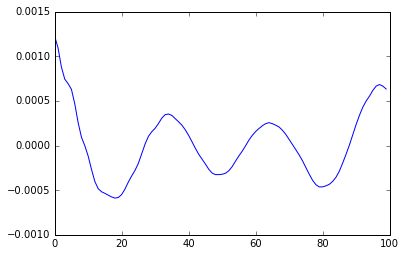

In [82]:
plt.plot(swift_corr[:100])

In [60]:
sample[0]

-0.00048828125

In [64]:
np.abs(fft.fft(sample)) ** 2

array([ 0.01261234,  0.01740134,  0.01351149, ...,  0.01854515,
        0.01351149,  0.01740134], dtype=float32)

In [70]:
(np.real(fft.fft(sample)) / swift_corr)[:15]

/usr/local/var/pyenv/versions/anaconda2-4.0.0/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


array([ 0.46771209,  0.56826907,  0.57967856,  1.05820913,  4.79549747,
       -1.22244429, -0.27117901, -0.18341189, -0.85128981, -0.19801385,
       -0.30462164, -0.7372946 ,  0.84833051,  0.35306406,  0.48542538])

In [93]:
for filepath in filepaths:
    sample = readfile(filepath)
    print filepath
    print np.log(intonation(sample, 1000))

/Users/smurakami/Desktop/taka_kora.wav
-5.0411264983
/Users/smurakami/Desktop/taka_kanashii.wav
-14.1322346118
/Users/smurakami/Desktop/taka_ureshii.wav
-9.69341279723
/Users/smurakami/Desktop/taka_coemoji.wav
-10.9218848278
/Users/smurakami/Desktop/mura_ureshii.wav
-10.810404984
/Users/smurakami/Desktop/mura_kora.wav
-6.85423160137
/Users/smurakami/Desktop/mura_kanashii.wav
-15.5018674867
/Users/smurakami/Desktop/mura_coemoji.wav
-11.7793065064


/usr/local/var/pyenv/versions/anaconda2-4.0.0/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
